In [2]:
import numpy as np
import cmath
from tqdm import tqdm
import matplotlib.pyplot as plt

## Function to generate F

In [3]:
def get_F(N, L):
    '''
    Generate IDFT Matrix
    : N : No of frequencies
    : L : channel taps 
    
    Returns:
    Float Matrix: N*L
    '''
    F = np.zeros((N,L), dtype = np.complex_) 
    for i in range(N):
        for j in range(L):
            F[i, j] = cmath.rect(1, 2*np.pi*i*j/N)

    return F

## Function to generate X

In [4]:
def get_X(xx, N, guard):
    '''
    Generates diagonal matrix with known symbols
    : Sequence xx of required length
    '''
    X = np.zeros([N,N], dtype=np.complex_)
    X[guard:N-guard,guard:N-guard] = np.diag(xx)
    return X

## Function to generate h

In [5]:
def get_h(L, d=0.2, sigma2_real=0.5, sigma2_imag=0.5):
    '''
    n tap time domain channel vector
    Generates h vec according to exponentially decaying power-delay profile
    : sigma_real : variance of zero mean gaussian dist for real part
    : sigma_imag : variance of zero mean gaussian dist for imag part
    '''
    a = np.random.normal(0, np.sqrt(sigma2_real), size = L)
    b = np.random.normal(0, np.sqrt(sigma2_imag), size = L)
    p = np.exp(-d*np.arange(L))
    h = p * (a + b*1j)
    h = h/np.linalg.norm(p)
    return h[:,None]


In [6]:
def get_h_sparse(L, zero_ind,d=0.2, sigma2_real=0.5, sigma2_imag=0.5):
    '''
    n tap time domain channel sparse vector
    Generates h vec according to exponentially decaying power-delay profile
    : sigma_real : variance of zero mean gaussian dist for real part
    : sigma_imag : variance of zero mean gaussian dist for imag part
    '''
    h = get_h(L,d,sigma2_real,sigma2_imag)
    h[zero_ind] = 0 + 0j
    return h

## Function to generate y 

In [7]:
def get_y(X,F,h,sigma_imag=0.1,sigma_real=0.05):
    '''
    Generates y vector
    Returns: 
    : y of size N 
    : h_actual of size n
    '''
    y = np.matmul(np.matmul(X,F),h)
    N = y.shape[0]
    y = y + (np.random.normal(0,np.sqrt(sigma_real),size=N) + np.random.normal(0,np.sqrt(sigma_imag),size=N) * 1j)[:,None]
    return y


In [8]:
def get_A(X,F):
    return np.matrix(np.matmul(X,F),dtype=np.complex_)


In [9]:
def get_MSE(y,h_est,A):
    err = np.matmul(A,np.linalg.inv(np.matmul(A.getH(),A))) #+lam*np.eye(A.shape[1],dtype=np.complex_))
    err = np.matmul(err,A.getH())
    err = np.matmul(np.eye(A.shape[1],dtype=np.complex_)-err,y)
    err = np.matmul(y.getH(),err)
    return err
    

## Least Squares Estimate

$$h_{est}=(A^{H}A+\lambda I)^{-1}A^{H}y$$

In [10]:
def get_estim_h(A,y,lam=0):
    '''
    LSE estimate of Ah = y 
    Regularisation lambda
    '''
    h_est = np.linalg.inv(np.matmul(A.getH(),A)+lam*np.eye(A.shape[1],dtype=np.complex_))
    h_est = np.matmul(h_est,A.getH())
    h_est = np.matmul(h_est,y)
    return h_est


System:
$$y=Ah+n$$
Constraint:
$$Ch=b$$
Solution:
$$h_{cons}= h_{est} - (A^{H}A+\lambda I)^{-1}C^{H} (C(A^{H}A+\lambda I)^{-1}C^{H})^{-1}(Ch_{est}-b)$$

where 
$$h_{est}=(A^{H}A+\lambda I)^{-1}A^{H}y$$

For implementation, 
$$Z = (A^{H}A+\lambda I)^{-1}C^{H}$$
$$W=Ch_{est}-b$$
Then,
$$h_{cons}= h_{est} - Z(CZ)^{-1}W$$

In [11]:
def get_estim_sparse_h(A,y,zero_ind,lam=0):
    '''
    LSE estimate of Ah = y 
    Regularisation lambda
    With sparsity in known indices
    '''
    h_est = get_estim_h(A,y)
    L = h_est.shape[0]
    r = len(zero_ind)
    C_m = np.eye(L)
    C_m = np.matrix(C_m[zero_ind,:],dtype=np.complex_)
    c_b = np.zeros([r,1],dtype=np.complex_)
    Z = np.matmul(np.linalg.inv(np.matmul(A.getH(),A)+lam*np.eye(A.shape[1],dtype=np.complex_)),C_m.getH())
    W = np.matmul(C_m,h_est) - c_b
    h_sparse_estim = h_est - np.matmul(np.matmul(Z,np.linalg.inv(np.matmul(C_m,Z))),W)
    return h_sparse_estim

## To handle constrained least squares

Constarint of the form C_m h= c_b

In [12]:
def get_estim_cons_h(A,y,C_m,c_b,lam=0):
    '''
    LSE estimate of Ah = y 
    Regularisation lambda
    With known linear constraints
    '''
    h_est = get_estim_h(A,y)
    L = h_est.shape[0]
    tempM = np.matmul(np.linalg.inv(np.matmul(A.getH(),A)+lam*np.eye(A.shape[1],dtype=np.complex_)),C_m.getH())
    constraint = np.matmul(C_m,h_est) - c_b
    h_sparse_estim = h_est - np.matmul(np.matmul(tempM,np.linalg.inv(np.matmul(C_m,tempM))),constraint)
    return h_sparse_estim


In [13]:
def get_random_xx(x_ii, N):
    '''
    Generate random sequence of symbols
    '''
    xx = np.random.randint(low=0, high=4, size=N)
    xx = xx*(1 + 0j)
    for i in range(4):
        xx[np.where(xx == i)] = x_ii[i]

    return xx


In [14]:
def q1(N,L, trials):
    '''
    LSE of h_act for 10,000 trials
    '''
    print("\n\n -----\n Question 1\n LSE of h_act for 10,000 trials")
    h_act = get_h(L)
    h_est = np.zeros_like(h_act, dtype=np.complex_)
    error = 0
    pbar = tqdm(range(trials))
    for trial in pbar:
        xx = get_random_xx(x_ii,N)
        X = get_X(xx,N,guard=0)
        F = get_F(N,L)
        y = get_y(X,F,h_act)
        A = get_A(X,F)
        h_est_tt = get_estim_h(A,y)
        error_tt = np.linalg.norm(h_act - h_est_tt)
        h_est += (h_est_tt - h_est)/(trial + 1)
        error += (error_tt - error)/(trial + 1)
        pbar.set_description(f"Trial {trial+1} error {error}")
    
    print(f"h actual {h_act}")
    print(f"h estimated {h_est}")
    print(f"Error L2 in linear estimation is {error}")
    return h_act,h_est


In [15]:
def q2(N,L, zero_ind,trials):
    '''
    LSE of sparse h_act for 10,000 trials
    '''
    print("\n\n -----\n Question 2\n LSE of sparse h_act for 10,000 trials")
    h_act = get_h_sparse(L,zero_ind)
    h_est = np.zeros_like(h_act, dtype=np.complex_)
    error = 0
    pbar = tqdm(range(trials))
    for trial in pbar:
        xx = get_random_xx(x_ii,N)
        X = get_X(xx,N,guard=0)
        F = get_F(N,L)
        y = get_y(X,F,h_act)
        A = get_A(X,F)
        h_est_tt = get_estim_sparse_h(A,y,zero_ind)
        error_tt = np.linalg.norm(h_act - h_est_tt)
        h_est += (h_est_tt - h_est)/(trial + 1)
        error += (error_tt - error)/(trial + 1)
        pbar.set_description(f"Trial {trial+1} error {error}")
    
    print(f"h actual {h_act}")
    print(f"h estimated {h_est}")
    print(f"Error L2 in linear estimation is {error}")
    return h_act,h_est

In [30]:
def q3(guard, N, L, lam,trials):
    '''
    180 zero guard bands
    '''
    print("\n\n -----\n Question 3\n 180 zero guard bands, each side")
    h_act = get_h(L)
    error = 0
    mse=0
    h_est = np.zeros_like(h_act, dtype=np.complex_)
    pbar = tqdm(range(trials))
    for trial in pbar:
        xx = get_random_xx(x_ii,N)[:N-2*guard]
        X = get_X(xx,N,guard)
        F = get_F(N,L)
        y = get_y(X,F,h_act)
        A = get_A(X,F)

        h_est_tt = get_estim_h(A,y,lam)
        error = np.linalg.norm(h_act - h_est_tt)
        error_tt = np.linalg.norm(h_act - h_est_tt)
        mse_tt=np.linalg.norm(y-np.matmul(A,h_est_tt))

        h_est += (h_est_tt - h_est)/(trial + 1)
        error += (error_tt - error)/(trial + 1)
        mse += (mse_tt - mse)/(trial + 1)

        pbar.set_description(f"Trial {trial+1} error {error}")
    
    print(f"h actual {h_act}")
    print(f"h estimated {h_est}")
    print(f"Error L2 in linear estimation is {error}")
    print(f"mse is {mse*mse}")
    return h_act,h_est,error,mse

In [20]:
def q4(N,L,eq_cons_ind,trials):
    '''
    LSE of constrained h_act for 10,000 trials
    '''
    print("\n\n -----\n Question 4\n LSE of constrained h_act for 10,000 trials")
    h_act = get_h(L)
    h_act[0]=h_act[1]
    h_act[2]=h_act[3]
    h_act[4]=h_act[5]
    C_m = np.zeros([eq_cons_ind.shape[1],L],dtype=np.complex_)
    C_m[np.arange(eq_cons_ind.shape[1]),eq_cons_ind[0]] = 1 + 0j
    C_m[np.arange(eq_cons_ind.shape[1]),eq_cons_ind[1]] = -1 + 0j
    C_m = np.matrix(C_m)    
    c_b = np.zeros([eq_cons_ind.shape[1],1],dtype=np.complex_)
    h_est = np.zeros_like(h_act, dtype=np.complex_)
    error = 0
    mse=0
    pbar = tqdm(range(trials))
    for trial in pbar:
        xx = get_random_xx(x_ii,N)
        X = get_X(xx,N,guard=0)
        F = get_F(N,L)
        y = get_y(X,F,h_act)
        A = get_A(X,F)
        h_est_tt = get_estim_cons_h(A,y,C_m,c_b)
        error_tt = np.linalg.norm(h_act - h_est_tt)
        mse_tt=np.linalg.norm(y-np.matmul(A,h_est_tt))
        h_est += (h_est_tt - h_est)/(trial + 1)
        error += (error_tt - error)/(trial + 1)
        mse += (mse_tt - mse)/(trial + 1)
        pbar.set_description(f"Trial {trial+1} error {error}")
    
    print(f"h actual {h_act}")
    print(f"h estimated {h_est}")
    print(f"Error  in h_est is {error}")
    print(f"mse is {mse*mse}")
    return h_act, h_est,

In [18]:
def plot_h(h_true, h_estim):
    h_true_mag = np.absolute(h_true)
    h_estim_mag = np.absolute(h_estim)
    plt.plot(h_true_mag, 'o', label='True h')
    plt.plot(h_estim_mag, 'o', label='Estimated h')
    plt.legend(loc='best')
    plt.show()

# Finding non-zero locations

## The Algorithm to find non-zero locations

![](zerolocfinder.PNG)

## Function to find non-zero locations

In [19]:
def nonzerolocfinder(N,L,k,A,y):    
    r=y
    t_k=np.zeros(L)
    non_zero_ind_est=[]
    for i in range(0,k):
        for j in range(L):
            t_k[j]=np.abs(np.dot(A[:,j].getH(),r))
        non_zero_ind_est.append(np.argmax(t_k))
        A_int = A[:,non_zero_ind_est]
        P_k = np.linalg.inv(np.matmul(A_int.getH(),A_int))
        P_k = np.matmul(P_k,A_int.getH())
        P_k = np.matmul(A_int,P_k)
        r=np.matmul(np.eye(N,dtype=np.complex_)-P_k,y)
    non_zero_ind_est=sorted(non_zero_ind_est)  
    return non_zero_ind_est

## Toy Example

In [191]:
N=12 #no.of observations
L=8 # h vector length
k=3 # sparsity - no.of non zero elements in h

non_zero_ind_act = [1,2,6]
zero_ind_act = np.delete(np.arange(L),non_zero_ind_act)

h_act = get_h_sparse(L,zero_ind_act)
xx = get_random_xx(x_ii,N)
X = get_X(xx,N,guard)
F = get_F(N,L)
y = get_y(X,F,h_act)
A = get_A(X,F)
np.abs(h_act)

array([[0.        ],
       [0.85637335],
       [0.39105633],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.13776673],
       [0.        ]])

In [184]:
nonzerolocfinder(N,L,k,A,y)

[1, 2, 6]

In [227]:
def q5(N,L, zero_ind_act,trials):
    '''
    LSE of sparse h_act for 10,000 trials
    
    Non zero locations also estimated
    
    '''
    print("\n\n -----\n Question 5\n LSE of sparse h_act for 10,000 trials")
    h_act = get_h_sparse(L,zero_ind_act)
    h_est = np.zeros_like(h_act, dtype=np.complex_)
    error = 0
    pbar = tqdm(range(trials))
    for trial in pbar:
        xx = get_random_xx(x_ii,N)
        X = get_X(xx,N,guard=0)
        F = get_F(N,L)
        y = get_y(X,F,h_act)
        A = get_A(X,F)
        k= L-len(zero_ind_act)
        non_zero_ind_est= nonzerolocfinder(N,L,k,A,y)
        zero_ind_est = np.delete(np.arange(L),non_zero_ind_est)
        h_est_tt = get_estim_sparse_h(A,y,zero_ind_est)
        error_tt = np.linalg.norm(h_act - h_est_tt)
        h_est += (h_est_tt - h_est)/(trial + 1)
        error += (error_tt - error)/(trial + 1)
        pbar.set_description(f"Trial {trial+1} error {error}")
    
    print(f"h actual {h_act}")
    print(f"h estimated {h_est}")
    print(f"Error L2 in linear estimation is {error}")
    return h_act,h_est

# Questions 1-5

In [27]:
x_ii = np.array([1 + 1j,-1 + 1j,1 - 1j,-1 - 1j], dtype= np.complex_)    # diag of X belongs to
N = 512                          # no of freqs
L = 32                            # no of channel taps
trials = 10000                    # no of trials per estimation

#sigma = 0.1
#sigma_real = sigma/2
#sigma_imag = sigma/2

#d = 0.2                           # Decay factor
guard = 180                        # Guard Bands

lam = 0.4
non_zero_ind = [2,5,7,9,10,12]
zero_ind = np.delete(np.arange(L),non_zero_ind)
eq_cons_ind = np.array([[0,2,4],[1,3,5]])



 -----
 Question 1
 LSE of h_act for 10,000 trials




  0%|          | 0/10000 [00:00<?, ?it/s]

Trial 1 error 0.06501953176872194:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 2 error 0.06775605311319023:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 3 error 0.06994526641239854:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 4 error 0.06783427410792557:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 5 error 0.06801170937967754:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 6 error 0.0688423856590804:   0%|          | 0/10000 [00:00<?, ?it/s] 

Trial 6 error 0.0688423856590804:   0%|          | 6/10000 [00:00<03:14, 51.48it/s]

Trial 7 error 0.06893104109722219:   0%|          | 6/10000 [00:00<03:14, 51.48it/s]

Trial 8 error 0.06871682657755107:   0%|          | 6/10000 [00:00<03:14, 51.48it/s]

Trial 9 error 0.06845470262120314:   0%|          | 6/10000 [00:00<03:14, 51.48it/s]

Trial 10 error 0.06774452333884312:   0%|          | 6/10000 [00:00<03:14, 51.48it/s]

Trial 11 error 0.06821890229989297:   0%|          | 6/10

Trial 159 error 0.06856288628699439:   2%|▏         | 156/10000 [00:03<03:12, 51.12it/s]

Trial 160 error 0.06864115968779023:   2%|▏         | 156/10000 [00:03<03:12, 51.12it/s]

Trial 161 error 0.06866497632976552:   2%|▏         | 156/10000 [00:03<03:12, 51.12it/s]

Trial 162 error 0.06864775866549973:   2%|▏         | 156/10000 [00:03<03:12, 51.12it/s]

Trial 162 error 0.06864775866549973:   2%|▏         | 162/10000 [00:03<03:22, 48.65it/s]

Trial 163 error 0.06863969388547662:   2%|▏         | 162/10000 [00:03<03:22, 48.65it/s]

Trial 164 error 0.0686281886339934:   2%|▏         | 162/10000 [00:03<03:22, 48.65it/s] 

Trial 165 error 0.06864404428960127:   2%|▏         | 162/10000 [00:03<03:22, 48.65it/s]

Trial 166 error 0.06854905755699243:   2%|▏         | 162/10000 [00:03<03:22, 48.65it/s]

Trial 167 error 0.06850344855455003:   2%|▏         | 162/10000 [00:03<03:22, 48.65it/s]

Trial 168 error 0.06859775616411071:   2%|▏         | 162/10000 [00:03<03:22, 48.65it/s]

Trial 168 

Trial 315 error 0.06820330159973179:   3%|▎         | 311/10000 [00:06<02:54, 55.42it/s]

Trial 316 error 0.06821615330084099:   3%|▎         | 311/10000 [00:06<02:54, 55.42it/s]

Trial 317 error 0.06819104842748124:   3%|▎         | 311/10000 [00:06<02:54, 55.42it/s]

Trial 317 error 0.06819104842748124:   3%|▎         | 317/10000 [00:06<02:55, 55.20it/s]

Trial 318 error 0.06820930504321268:   3%|▎         | 317/10000 [00:06<02:55, 55.20it/s]

Trial 319 error 0.06818696127748082:   3%|▎         | 317/10000 [00:06<02:55, 55.20it/s]

Trial 320 error 0.06819904437074241:   3%|▎         | 317/10000 [00:06<02:55, 55.20it/s]

Trial 321 error 0.0681708194644231:   3%|▎         | 317/10000 [00:06<02:55, 55.20it/s] 

Trial 322 error 0.06818625908170661:   3%|▎         | 317/10000 [00:06<02:55, 55.20it/s]

Trial 323 error 0.06816361628063544:   3%|▎         | 317/10000 [00:06<02:55, 55.20it/s]

Trial 323 error 0.06816361628063544:   3%|▎         | 323/10000 [00:06<02:57, 54.45it/s]

Trial 324 

Trial 470 error 0.06844467067981622:   5%|▍         | 469/10000 [00:09<03:17, 48.28it/s]

Trial 471 error 0.06844946967873908:   5%|▍         | 469/10000 [00:09<03:17, 48.28it/s]

Trial 472 error 0.06846908158784079:   5%|▍         | 469/10000 [00:09<03:17, 48.28it/s]

Trial 473 error 0.06845034381162922:   5%|▍         | 469/10000 [00:09<03:17, 48.28it/s]

Trial 474 error 0.06843900274157089:   5%|▍         | 469/10000 [00:09<03:17, 48.28it/s]

Trial 475 error 0.06844630634084473:   5%|▍         | 469/10000 [00:09<03:17, 48.28it/s]

Trial 475 error 0.06844630634084473:   5%|▍         | 475/10000 [00:09<03:11, 49.66it/s]

Trial 476 error 0.06843780876782556:   5%|▍         | 475/10000 [00:09<03:11, 49.66it/s]

Trial 477 error 0.06843030656032292:   5%|▍         | 475/10000 [00:09<03:11, 49.66it/s]

Trial 478 error 0.06841808300923981:   5%|▍         | 475/10000 [00:09<03:11, 49.66it/s]

Trial 479 error 0.06841495138366287:   5%|▍         | 475/10000 [00:09<03:11, 49.66it/s]

Trial 480 

Trial 624 error 0.06842646351182352:   6%|▌         | 623/10000 [00:12<03:25, 45.59it/s]

Trial 625 error 0.06842745299884:   6%|▌         | 623/10000 [00:12<03:25, 45.59it/s]   

Trial 626 error 0.0684313463056146:   6%|▌         | 623/10000 [00:12<03:25, 45.59it/s]

Trial 627 error 0.0684333348196846:   6%|▌         | 623/10000 [00:12<03:25, 45.59it/s]

Trial 628 error 0.06845100164075306:   6%|▌         | 623/10000 [00:12<03:25, 45.59it/s]

Trial 628 error 0.06845100164075306:   6%|▋         | 628/10000 [00:12<03:25, 45.66it/s]

Trial 629 error 0.06844657455103964:   6%|▋         | 628/10000 [00:12<03:25, 45.66it/s]

Trial 630 error 0.06845958337389145:   6%|▋         | 628/10000 [00:12<03:25, 45.66it/s]

Trial 631 error 0.06844639837831858:   6%|▋         | 628/10000 [00:12<03:25, 45.66it/s]

Trial 632 error 0.06842300463237315:   6%|▋         | 628/10000 [00:12<03:25, 45.66it/s]

Trial 633 error 0.06843844486664366:   6%|▋         | 628/10000 [00:12<03:25, 45.66it/s]

Trial 633 er

Trial 776 error 0.0684508210552653:   8%|▊         | 776/10000 [00:15<03:18, 46.47it/s]

Trial 777 error 0.06845583768333605:   8%|▊         | 776/10000 [00:15<03:18, 46.47it/s]

Trial 778 error 0.06845544423149003:   8%|▊         | 776/10000 [00:15<03:18, 46.47it/s]

Trial 779 error 0.06845208831749997:   8%|▊         | 776/10000 [00:15<03:18, 46.47it/s]

Trial 780 error 0.06845971387597283:   8%|▊         | 776/10000 [00:15<03:18, 46.47it/s]

Trial 781 error 0.0684506775900078:   8%|▊         | 776/10000 [00:15<03:18, 46.47it/s] 

Trial 781 error 0.0684506775900078:   8%|▊         | 781/10000 [00:15<03:21, 45.77it/s]

Trial 782 error 0.0684523124560651:   8%|▊         | 781/10000 [00:15<03:21, 45.77it/s]

Trial 783 error 0.06845726463079627:   8%|▊         | 781/10000 [00:15<03:21, 45.77it/s]

Trial 784 error 0.06844794606656121:   8%|▊         | 781/10000 [00:15<03:21, 45.77it/s]

Trial 785 error 0.0684624900761389:   8%|▊         | 781/10000 [00:15<03:21, 45.77it/s] 

Trial 786 err

Trial 929 error 0.06838947967536389:   9%|▉         | 924/10000 [00:19<03:17, 45.96it/s]

Trial 930 error 0.068389021535625:   9%|▉         | 924/10000 [00:19<03:17, 45.96it/s]  

Trial 930 error 0.068389021535625:   9%|▉         | 930/10000 [00:19<03:16, 46.27it/s]

Trial 931 error 0.06839280208592442:   9%|▉         | 930/10000 [00:19<03:16, 46.27it/s]

Trial 932 error 0.06840349167485192:   9%|▉         | 930/10000 [00:19<03:16, 46.27it/s]

Trial 933 error 0.0684084649766813:   9%|▉         | 930/10000 [00:19<03:16, 46.27it/s] 

Trial 934 error 0.06840408007356412:   9%|▉         | 930/10000 [00:19<03:16, 46.27it/s]

Trial 935 error 0.06839890879469332:   9%|▉         | 930/10000 [00:19<03:16, 46.27it/s]

Trial 936 error 0.06839799793895576:   9%|▉         | 930/10000 [00:19<03:16, 46.27it/s]

Trial 936 error 0.06839799793895576:   9%|▉         | 936/10000 [00:19<03:03, 49.33it/s]

Trial 937 error 0.06840034747807726:   9%|▉         | 936/10000 [00:19<03:03, 49.33it/s]

Trial 938 er

Trial 1080 error 0.06834564556063731:  11%|█         | 1079/10000 [00:22<03:09, 47.03it/s]

Trial 1081 error 0.06834045351717424:  11%|█         | 1079/10000 [00:22<03:09, 47.03it/s]

Trial 1082 error 0.06834265179473138:  11%|█         | 1079/10000 [00:22<03:09, 47.03it/s]

Trial 1083 error 0.06834976912726427:  11%|█         | 1079/10000 [00:22<03:09, 47.03it/s]

Trial 1084 error 0.06834319205051953:  11%|█         | 1079/10000 [00:22<03:09, 47.03it/s]

Trial 1084 error 0.06834319205051953:  11%|█         | 1084/10000 [00:22<03:08, 47.40it/s]

Trial 1085 error 0.0683482660299389:  11%|█         | 1084/10000 [00:22<03:08, 47.40it/s] 

Trial 1086 error 0.06834310867677142:  11%|█         | 1084/10000 [00:22<03:08, 47.40it/s]

Trial 1087 error 0.06835001723099417:  11%|█         | 1084/10000 [00:22<03:08, 47.40it/s]

Trial 1088 error 0.06834249996381471:  11%|█         | 1084/10000 [00:22<03:08, 47.40it/s]

Trial 1089 error 0.06833708110724172:  11%|█         | 1084/10000 [00:22<03:08, 

Trial 1230 error 0.06833518621595899:  12%|█▏        | 1230/10000 [00:25<02:45, 53.14it/s]

Trial 1231 error 0.06833251640335387:  12%|█▏        | 1230/10000 [00:25<02:45, 53.14it/s]

Trial 1232 error 0.06834272999102355:  12%|█▏        | 1230/10000 [00:25<02:45, 53.14it/s]

Trial 1233 error 0.06834336554855612:  12%|█▏        | 1230/10000 [00:25<02:45, 53.14it/s]

Trial 1234 error 0.06834497393493101:  12%|█▏        | 1230/10000 [00:25<02:45, 53.14it/s]

Trial 1235 error 0.06834718504499553:  12%|█▏        | 1230/10000 [00:25<02:45, 53.14it/s]

Trial 1236 error 0.06834338819696356:  12%|█▏        | 1230/10000 [00:25<02:45, 53.14it/s]

Trial 1236 error 0.06834338819696356:  12%|█▏        | 1236/10000 [00:25<02:54, 50.12it/s]

Trial 1237 error 0.06834276067884852:  12%|█▏        | 1236/10000 [00:25<02:54, 50.12it/s]

Trial 1238 error 0.068345754298203:  12%|█▏        | 1236/10000 [00:25<02:54, 50.12it/s]  

Trial 1239 error 0.06833513204819458:  12%|█▏        | 1236/10000 [00:25<02:54, 

Trial 1383 error 0.06827430385451527:  14%|█▍        | 1383/10000 [00:28<02:44, 52.31it/s]

Trial 1384 error 0.06827153138267054:  14%|█▍        | 1383/10000 [00:28<02:44, 52.31it/s]

Trial 1385 error 0.06826997117398684:  14%|█▍        | 1383/10000 [00:28<02:44, 52.31it/s]

Trial 1386 error 0.06827346729608867:  14%|█▍        | 1383/10000 [00:28<02:44, 52.31it/s]

Trial 1387 error 0.06828204833210265:  14%|█▍        | 1383/10000 [00:28<02:44, 52.31it/s]

Trial 1388 error 0.06828410592259748:  14%|█▍        | 1383/10000 [00:28<02:44, 52.31it/s]

Trial 1389 error 0.0682864048442068:  14%|█▍        | 1383/10000 [00:28<02:44, 52.31it/s] 

Trial 1389 error 0.0682864048442068:  14%|█▍        | 1389/10000 [00:28<02:45, 52.18it/s]

Trial 1390 error 0.06828554568433927:  14%|█▍        | 1389/10000 [00:28<02:45, 52.18it/s]

Trial 1391 error 0.06827996423405303:  14%|█▍        | 1389/10000 [00:28<02:45, 52.18it/s]

Trial 1392 error 0.06828339486339983:  14%|█▍        | 1389/10000 [00:28<02:45, 5

Trial 1536 error 0.06834361215905371:  15%|█▌        | 1532/10000 [00:31<02:30, 56.39it/s]

Trial 1537 error 0.06834924392763887:  15%|█▌        | 1532/10000 [00:31<02:30, 56.39it/s]

Trial 1538 error 0.06835662123436247:  15%|█▌        | 1532/10000 [00:31<02:30, 56.39it/s]

Trial 1538 error 0.06835662123436247:  15%|█▌        | 1538/10000 [00:31<02:39, 53.20it/s]

Trial 1539 error 0.06835569494519664:  15%|█▌        | 1538/10000 [00:31<02:39, 53.20it/s]

Trial 1540 error 0.06835401496676435:  15%|█▌        | 1538/10000 [00:31<02:39, 53.20it/s]

Trial 1541 error 0.06835406745668787:  15%|█▌        | 1538/10000 [00:31<02:39, 53.20it/s]

Trial 1542 error 0.06834904968559571:  15%|█▌        | 1538/10000 [00:31<02:39, 53.20it/s]

Trial 1543 error 0.06833868366504157:  15%|█▌        | 1538/10000 [00:31<02:39, 53.20it/s]

Trial 1544 error 0.06834437065814102:  15%|█▌        | 1538/10000 [00:31<02:39, 53.20it/s]

Trial 1544 error 0.06834437065814102:  15%|█▌        | 1544/10000 [00:31<02:33, 

Trial 1688 error 0.06833644288159037:  17%|█▋        | 1684/10000 [00:34<02:47, 49.52it/s]

Trial 1689 error 0.06833151083014671:  17%|█▋        | 1684/10000 [00:34<02:47, 49.52it/s]

Trial 1689 error 0.06833151083014671:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1690 error 0.06833179064677916:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1691 error 0.06832581914545371:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1692 error 0.06831986155044839:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1693 error 0.06832343316479035:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1694 error 0.06832409995572082:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1695 error 0.06832079736868077:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1696 error 0.06832038686038865:  17%|█▋        | 1689/10000 [00:34<02:48, 49.41it/s]

Trial 1696 error 0.06832038686038865:  17%|█▋        | 1696/10000 [00:34<02:39, 

Trial 1841 error 0.06829825949982418:  18%|█▊        | 1836/10000 [00:37<02:37, 51.88it/s]

Trial 1842 error 0.06830408874467273:  18%|█▊        | 1836/10000 [00:37<02:37, 51.88it/s]

Trial 1842 error 0.06830408874467273:  18%|█▊        | 1842/10000 [00:37<02:31, 53.97it/s]

Trial 1843 error 0.06830568963078598:  18%|█▊        | 1842/10000 [00:37<02:31, 53.97it/s]

Trial 1844 error 0.06830201167515033:  18%|█▊        | 1842/10000 [00:37<02:31, 53.97it/s]

Trial 1845 error 0.06830385924367738:  18%|█▊        | 1842/10000 [00:37<02:31, 53.97it/s]

Trial 1846 error 0.06830669196513378:  18%|█▊        | 1842/10000 [00:37<02:31, 53.97it/s]

Trial 1847 error 0.06830619400006335:  18%|█▊        | 1842/10000 [00:37<02:31, 53.97it/s]

Trial 1848 error 0.06830603392028653:  18%|█▊        | 1842/10000 [00:37<02:31, 53.97it/s]

Trial 1848 error 0.06830603392028653:  18%|█▊        | 1848/10000 [00:37<02:32, 53.60it/s]

Trial 1849 error 0.06830332423189493:  18%|█▊        | 1848/10000 [00:37<02:32, 

Trial 1992 error 0.06828234404627131:  20%|█▉        | 1989/10000 [00:40<02:31, 52.71it/s]

Trial 1993 error 0.06828192102893328:  20%|█▉        | 1989/10000 [00:40<02:31, 52.71it/s]

Trial 1994 error 0.06828534078937672:  20%|█▉        | 1989/10000 [00:40<02:31, 52.71it/s]

Trial 1995 error 0.06828264682673243:  20%|█▉        | 1989/10000 [00:40<02:31, 52.71it/s]

Trial 1995 error 0.06828264682673243:  20%|█▉        | 1995/10000 [00:40<02:40, 49.85it/s]

Trial 1996 error 0.06828070669860913:  20%|█▉        | 1995/10000 [00:40<02:40, 49.85it/s]

Trial 1997 error 0.06828165425683823:  20%|█▉        | 1995/10000 [00:40<02:40, 49.85it/s]

Trial 1998 error 0.0682852185540687:  20%|█▉        | 1995/10000 [00:40<02:40, 49.85it/s] 

Trial 1999 error 0.06828423975041084:  20%|█▉        | 1995/10000 [00:40<02:40, 49.85it/s]

Trial 2000 error 0.06827557645259612:  20%|█▉        | 1995/10000 [00:40<02:40, 49.85it/s]

Trial 2001 error 0.06827738690079277:  20%|█▉        | 1995/10000 [00:40<02:40, 

Trial 2143 error 0.06822139052513479:  21%|██▏       | 2140/10000 [00:43<02:55, 44.71it/s]

Trial 2144 error 0.06821806091760602:  21%|██▏       | 2140/10000 [00:43<02:55, 44.71it/s]

Trial 2145 error 0.0682166598336855:  21%|██▏       | 2140/10000 [00:43<02:55, 44.71it/s] 

Trial 2145 error 0.0682166598336855:  21%|██▏       | 2145/10000 [00:43<02:51, 45.83it/s]

Trial 2146 error 0.06820961928564093:  21%|██▏       | 2145/10000 [00:43<02:51, 45.83it/s]

Trial 2147 error 0.06820574110339325:  21%|██▏       | 2145/10000 [00:43<02:51, 45.83it/s]

Trial 2148 error 0.06820408901699773:  21%|██▏       | 2145/10000 [00:43<02:51, 45.83it/s]

Trial 2149 error 0.0682087103347612:  21%|██▏       | 2145/10000 [00:43<02:51, 45.83it/s] 

Trial 2150 error 0.06820646857886821:  21%|██▏       | 2145/10000 [00:43<02:51, 45.83it/s]

Trial 2150 error 0.06820646857886821:  22%|██▏       | 2150/10000 [00:43<02:53, 45.26it/s]

Trial 2151 error 0.0682086232636979:  22%|██▏       | 2150/10000 [00:43<02:53, 45

Trial 2292 error 0.0681965071016616:  23%|██▎       | 2287/10000 [00:46<02:43, 47.11it/s] 

Trial 2292 error 0.0681965071016616:  23%|██▎       | 2292/10000 [00:46<02:40, 47.90it/s]

Trial 2293 error 0.06820342688482077:  23%|██▎       | 2292/10000 [00:46<02:40, 47.90it/s]

Trial 2294 error 0.06820025220558079:  23%|██▎       | 2292/10000 [00:46<02:40, 47.90it/s]

Trial 2295 error 0.06820117144174938:  23%|██▎       | 2292/10000 [00:46<02:40, 47.90it/s]

Trial 2296 error 0.06819825256139703:  23%|██▎       | 2292/10000 [00:46<02:40, 47.90it/s]

Trial 2297 error 0.0681957371745803:  23%|██▎       | 2292/10000 [00:46<02:40, 47.90it/s] 

Trial 2297 error 0.0681957371745803:  23%|██▎       | 2297/10000 [00:46<02:43, 47.04it/s]

Trial 2298 error 0.06819934743880515:  23%|██▎       | 2297/10000 [00:46<02:43, 47.04it/s]

Trial 2299 error 0.06820113313248052:  23%|██▎       | 2297/10000 [00:46<02:43, 47.04it/s]

Trial 2300 error 0.0681953799821476:  23%|██▎       | 2297/10000 [00:46<02:43, 47.

Trial 2442 error 0.06816601343138237:  24%|██▍       | 2439/10000 [00:49<02:40, 47.04it/s]

Trial 2443 error 0.06817004024647902:  24%|██▍       | 2439/10000 [00:49<02:40, 47.04it/s]

Trial 2444 error 0.06817176121033894:  24%|██▍       | 2439/10000 [00:49<02:40, 47.04it/s]

Trial 2444 error 0.06817176121033894:  24%|██▍       | 2444/10000 [00:49<02:38, 47.75it/s]

Trial 2445 error 0.06817374448624723:  24%|██▍       | 2444/10000 [00:49<02:38, 47.75it/s]

Trial 2446 error 0.06817527161476686:  24%|██▍       | 2444/10000 [00:49<02:38, 47.75it/s]

Trial 2447 error 0.06817721491353847:  24%|██▍       | 2444/10000 [00:49<02:38, 47.75it/s]

Trial 2448 error 0.06817964066414633:  24%|██▍       | 2444/10000 [00:49<02:38, 47.75it/s]

Trial 2449 error 0.06818031546417641:  24%|██▍       | 2444/10000 [00:49<02:38, 47.75it/s]

Trial 2449 error 0.06818031546417641:  24%|██▍       | 2449/10000 [00:49<02:38, 47.61it/s]

Trial 2450 error 0.06817683213442831:  24%|██▍       | 2449/10000 [00:49<02:38, 

Trial 2594 error 0.0681868511762674:  26%|██▌       | 2592/10000 [00:52<02:21, 52.34it/s] 

Trial 2595 error 0.06818570697623837:  26%|██▌       | 2592/10000 [00:52<02:21, 52.34it/s]

Trial 2596 error 0.06818585771600356:  26%|██▌       | 2592/10000 [00:52<02:21, 52.34it/s]

Trial 2597 error 0.06818622964579353:  26%|██▌       | 2592/10000 [00:52<02:21, 52.34it/s]

Trial 2598 error 0.06818647796237753:  26%|██▌       | 2592/10000 [00:52<02:21, 52.34it/s]

Trial 2598 error 0.06818647796237753:  26%|██▌       | 2598/10000 [00:52<02:20, 52.59it/s]

Trial 2599 error 0.06819284670608837:  26%|██▌       | 2598/10000 [00:52<02:20, 52.59it/s]

Trial 2600 error 0.06819276336092073:  26%|██▌       | 2598/10000 [00:52<02:20, 52.59it/s]

Trial 2601 error 0.06819241948804439:  26%|██▌       | 2598/10000 [00:52<02:20, 52.59it/s]

Trial 2602 error 0.06818867716601301:  26%|██▌       | 2598/10000 [00:52<02:20, 52.59it/s]

Trial 2603 error 0.06819048188998926:  26%|██▌       | 2598/10000 [00:52<02:20, 

Trial 2746 error 0.06814511641953983:  27%|██▋       | 2743/10000 [00:55<02:32, 47.69it/s]

Trial 2747 error 0.06814411959553306:  27%|██▋       | 2743/10000 [00:55<02:32, 47.69it/s]

Trial 2748 error 0.06814221572693792:  27%|██▋       | 2743/10000 [00:55<02:32, 47.69it/s]

Trial 2748 error 0.06814221572693792:  27%|██▋       | 2748/10000 [00:55<02:33, 47.29it/s]

Trial 2749 error 0.06814267853032518:  27%|██▋       | 2748/10000 [00:55<02:33, 47.29it/s]

Trial 2750 error 0.06813966992857533:  27%|██▋       | 2748/10000 [00:55<02:33, 47.29it/s]

Trial 2751 error 0.06813804816695862:  27%|██▋       | 2748/10000 [00:55<02:33, 47.29it/s]

Trial 2752 error 0.06813488218181409:  27%|██▋       | 2748/10000 [00:55<02:33, 47.29it/s]

Trial 2753 error 0.0681302255699732:  27%|██▋       | 2748/10000 [00:56<02:33, 47.29it/s] 

Trial 2753 error 0.0681302255699732:  28%|██▊       | 2753/10000 [00:56<02:46, 43.60it/s]

Trial 2754 error 0.06812592415471216:  28%|██▊       | 2753/10000 [00:56<02:46, 4

Trial 2897 error 0.0681033463890342:  29%|██▉       | 2896/10000 [00:58<02:14, 52.82it/s] 

Trial 2898 error 0.0681049988639739:  29%|██▉       | 2896/10000 [00:58<02:14, 52.82it/s]

Trial 2899 error 0.06810413939320646:  29%|██▉       | 2896/10000 [00:58<02:14, 52.82it/s]

Trial 2900 error 0.06810660574588186:  29%|██▉       | 2896/10000 [00:58<02:14, 52.82it/s]

Trial 2901 error 0.06810654454609491:  29%|██▉       | 2896/10000 [00:58<02:14, 52.82it/s]

Trial 2902 error 0.06810636704827412:  29%|██▉       | 2896/10000 [00:59<02:14, 52.82it/s]

Trial 2902 error 0.06810636704827412:  29%|██▉       | 2902/10000 [00:59<02:19, 50.98it/s]

Trial 2903 error 0.06810955627714617:  29%|██▉       | 2902/10000 [00:59<02:19, 50.98it/s]

Trial 2904 error 0.0681063060498426:  29%|██▉       | 2902/10000 [00:59<02:19, 50.98it/s] 

Trial 2905 error 0.06810830139284721:  29%|██▉       | 2902/10000 [00:59<02:19, 50.98it/s]

Trial 2906 error 0.06810897969145788:  29%|██▉       | 2902/10000 [00:59<02:19, 5

Trial 3049 error 0.06811033975959421:  30%|███       | 3049/10000 [01:01<02:12, 52.47it/s]

Trial 3050 error 0.06811120417664741:  30%|███       | 3049/10000 [01:01<02:12, 52.47it/s]

Trial 3051 error 0.06810904297356637:  30%|███       | 3049/10000 [01:01<02:12, 52.47it/s]

Trial 3052 error 0.0681098647961969:  30%|███       | 3049/10000 [01:01<02:12, 52.47it/s] 

Trial 3053 error 0.06810943328659175:  30%|███       | 3049/10000 [01:01<02:12, 52.47it/s]

Trial 3054 error 0.06811002491503597:  30%|███       | 3049/10000 [01:02<02:12, 52.47it/s]

Trial 3055 error 0.06810509130157993:  30%|███       | 3049/10000 [01:02<02:12, 52.47it/s]

Trial 3055 error 0.06810509130157993:  31%|███       | 3055/10000 [01:02<02:21, 49.09it/s]

Trial 3056 error 0.06810284871146476:  31%|███       | 3055/10000 [01:02<02:21, 49.09it/s]

Trial 3057 error 0.06810472139072575:  31%|███       | 3055/10000 [01:02<02:21, 49.09it/s]

Trial 3058 error 0.0681055596620349:  31%|███       | 3055/10000 [01:02<02:21, 4

Trial 3199 error 0.06807852771699202:  32%|███▏      | 3194/10000 [01:05<02:33, 44.28it/s]

Trial 3199 error 0.06807852771699202:  32%|███▏      | 3199/10000 [01:05<02:45, 41.04it/s]

Trial 3200 error 0.06807776004783096:  32%|███▏      | 3199/10000 [01:05<02:45, 41.04it/s]

Trial 3201 error 0.06807568917129328:  32%|███▏      | 3199/10000 [01:05<02:45, 41.04it/s]

Trial 3202 error 0.06807774787067432:  32%|███▏      | 3199/10000 [01:05<02:45, 41.04it/s]

Trial 3203 error 0.06807709187783377:  32%|███▏      | 3199/10000 [01:05<02:45, 41.04it/s]

Trial 3204 error 0.06807764015887685:  32%|███▏      | 3199/10000 [01:05<02:45, 41.04it/s]

Trial 3204 error 0.06807764015887685:  32%|███▏      | 3204/10000 [01:05<02:44, 41.40it/s]

Trial 3205 error 0.06807716752766892:  32%|███▏      | 3204/10000 [01:05<02:44, 41.40it/s]

Trial 3206 error 0.06808025213642696:  32%|███▏      | 3204/10000 [01:05<02:44, 41.40it/s]

Trial 3207 error 0.06808178726505511:  32%|███▏      | 3204/10000 [01:05<02:44, 

Trial 3350 error 0.06806276790991847:  33%|███▎      | 3348/10000 [01:08<02:16, 48.88it/s]

Trial 3351 error 0.0680637857661046:  33%|███▎      | 3348/10000 [01:08<02:16, 48.88it/s] 

Trial 3352 error 0.06806363283086642:  33%|███▎      | 3348/10000 [01:08<02:16, 48.88it/s]

Trial 3353 error 0.06806273826052125:  33%|███▎      | 3348/10000 [01:08<02:16, 48.88it/s]

Trial 3353 error 0.06806273826052125:  34%|███▎      | 3353/10000 [01:08<02:31, 43.88it/s]

Trial 3354 error 0.06806270686115591:  34%|███▎      | 3353/10000 [01:08<02:31, 43.88it/s]

Trial 3355 error 0.06806437110680784:  34%|███▎      | 3353/10000 [01:08<02:31, 43.88it/s]

Trial 3356 error 0.06806552094518507:  34%|███▎      | 3353/10000 [01:08<02:31, 43.88it/s]

Trial 3357 error 0.06806848708388577:  34%|███▎      | 3353/10000 [01:08<02:31, 43.88it/s]

Trial 3358 error 0.0680667664580789:  34%|███▎      | 3353/10000 [01:08<02:31, 43.88it/s] 

Trial 3358 error 0.0680667664580789:  34%|███▎      | 3358/10000 [01:08<02:38, 4

Trial 3499 error 0.06808480282112742:  35%|███▍      | 3499/10000 [01:11<02:11, 49.40it/s]

Trial 3500 error 0.06808603727754493:  35%|███▍      | 3499/10000 [01:11<02:11, 49.40it/s]

Trial 3501 error 0.06808707770118835:  35%|███▍      | 3499/10000 [01:11<02:11, 49.40it/s]

Trial 3502 error 0.06808753551099353:  35%|███▍      | 3499/10000 [01:11<02:11, 49.40it/s]

Trial 3503 error 0.06809092554154957:  35%|███▍      | 3499/10000 [01:11<02:11, 49.40it/s]

Trial 3504 error 0.06809056089259193:  35%|███▍      | 3499/10000 [01:11<02:11, 49.40it/s]

Trial 3505 error 0.06809134826277778:  35%|███▍      | 3499/10000 [01:11<02:11, 49.40it/s]

Trial 3506 error 0.0680892934083429:  35%|███▍      | 3499/10000 [01:12<02:11, 49.40it/s] 

Trial 3506 error 0.0680892934083429:  35%|███▌      | 3506/10000 [01:12<02:03, 52.63it/s]

Trial 3507 error 0.06809032137486691:  35%|███▌      | 3506/10000 [01:12<02:03, 52.63it/s]

Trial 3508 error 0.06808795212451065:  35%|███▌      | 3506/10000 [01:12<02:03, 5

Trial 3651 error 0.06812271162349642:  36%|███▋      | 3646/10000 [01:15<02:32, 41.76it/s]

Trial 3651 error 0.06812271162349642:  37%|███▋      | 3651/10000 [01:15<02:29, 42.61it/s]

Trial 3652 error 0.06812454424478179:  37%|███▋      | 3651/10000 [01:15<02:29, 42.61it/s]

Trial 3653 error 0.06812701319731039:  37%|███▋      | 3651/10000 [01:15<02:29, 42.61it/s]

Trial 3654 error 0.06812670127577093:  37%|███▋      | 3651/10000 [01:15<02:29, 42.61it/s]

Trial 3655 error 0.06812618642644812:  37%|███▋      | 3651/10000 [01:15<02:29, 42.61it/s]

Trial 3656 error 0.06812393152729587:  37%|███▋      | 3651/10000 [01:15<02:29, 42.61it/s]

Trial 3656 error 0.06812393152729587:  37%|███▋      | 3656/10000 [01:15<02:31, 41.87it/s]

Trial 3657 error 0.06812429045512453:  37%|███▋      | 3656/10000 [01:15<02:31, 41.87it/s]

Trial 3658 error 0.06812299494954703:  37%|███▋      | 3656/10000 [01:15<02:31, 41.87it/s]

Trial 3659 error 0.06812335704667673:  37%|███▋      | 3656/10000 [01:15<02:31, 

Trial 3795 error 0.0680888168778962:  38%|███▊      | 3793/10000 [01:18<02:42, 38.12it/s] 

Trial 3796 error 0.06808889138285548:  38%|███▊      | 3793/10000 [01:18<02:42, 38.12it/s]

Trial 3797 error 0.06808965002072244:  38%|███▊      | 3793/10000 [01:18<02:42, 38.12it/s]

Trial 3798 error 0.06808912037034685:  38%|███▊      | 3793/10000 [01:18<02:42, 38.12it/s]

Trial 3798 error 0.06808912037034685:  38%|███▊      | 3798/10000 [01:18<02:34, 40.12it/s]

Trial 3799 error 0.06809127588423693:  38%|███▊      | 3798/10000 [01:19<02:34, 40.12it/s]

Trial 3800 error 0.06808832600939109:  38%|███▊      | 3798/10000 [01:19<02:34, 40.12it/s]

Trial 3801 error 0.06808692976109258:  38%|███▊      | 3798/10000 [01:19<02:34, 40.12it/s]

Trial 3802 error 0.06808716062487752:  38%|███▊      | 3798/10000 [01:19<02:34, 40.12it/s]

Trial 3803 error 0.06808872720703821:  38%|███▊      | 3798/10000 [01:19<02:34, 40.12it/s]

Trial 3803 error 0.06808872720703821:  38%|███▊      | 3803/10000 [01:19<02:36, 

Trial 3945 error 0.06810460416460327:  39%|███▉      | 3944/10000 [01:22<02:02, 49.44it/s]

Trial 3946 error 0.06810916083076764:  39%|███▉      | 3944/10000 [01:22<02:02, 49.44it/s]

Trial 3947 error 0.06810797556846553:  39%|███▉      | 3944/10000 [01:22<02:02, 49.44it/s]

Trial 3948 error 0.0681081001815196:  39%|███▉      | 3944/10000 [01:22<02:02, 49.44it/s] 

Trial 3949 error 0.06810778688521937:  39%|███▉      | 3944/10000 [01:22<02:02, 49.44it/s]

Trial 3949 error 0.06810778688521937:  39%|███▉      | 3949/10000 [01:22<02:05, 48.04it/s]

Trial 3950 error 0.06810736895851464:  39%|███▉      | 3949/10000 [01:22<02:05, 48.04it/s]

Trial 3951 error 0.06810629381373856:  39%|███▉      | 3949/10000 [01:22<02:05, 48.04it/s]

Trial 3952 error 0.0681072952474482:  39%|███▉      | 3949/10000 [01:22<02:05, 48.04it/s] 

Trial 3953 error 0.0681079774427238:  39%|███▉      | 3949/10000 [01:22<02:05, 48.04it/s]

Trial 3954 error 0.06811078984142202:  39%|███▉      | 3949/10000 [01:22<02:05, 4

Trial 4097 error 0.06808015918720216:  41%|████      | 4094/10000 [01:25<01:59, 49.47it/s]

Trial 4098 error 0.06808095679154189:  41%|████      | 4094/10000 [01:25<01:59, 49.47it/s]

Trial 4099 error 0.06808211123909054:  41%|████      | 4094/10000 [01:25<01:59, 49.47it/s]

Trial 4100 error 0.06808222744915039:  41%|████      | 4094/10000 [01:25<01:59, 49.47it/s]

Trial 4100 error 0.06808222744915039:  41%|████      | 4100/10000 [01:25<01:59, 49.39it/s]

Trial 4101 error 0.06808269758930843:  41%|████      | 4100/10000 [01:25<01:59, 49.39it/s]

Trial 4102 error 0.06808340302439933:  41%|████      | 4100/10000 [01:25<01:59, 49.39it/s]

Trial 4103 error 0.06808348419885234:  41%|████      | 4100/10000 [01:25<01:59, 49.39it/s]

Trial 4104 error 0.06808369100516387:  41%|████      | 4100/10000 [01:25<01:59, 49.39it/s]

Trial 4105 error 0.06808578914601225:  41%|████      | 4100/10000 [01:25<01:59, 49.39it/s]

Trial 4105 error 0.06808578914601225:  41%|████      | 4105/10000 [01:25<02:02, 

Trial 4249 error 0.0681247346368701:  42%|████▏     | 4243/10000 [01:28<01:58, 48.49it/s]

Trial 4249 error 0.0681247346368701:  42%|████▏     | 4249/10000 [01:28<01:53, 50.84it/s]

Trial 4250 error 0.06812743589649822:  42%|████▏     | 4249/10000 [01:28<01:53, 50.84it/s]

Trial 4251 error 0.06812851315762096:  42%|████▏     | 4249/10000 [01:28<01:53, 50.84it/s]

Trial 4252 error 0.0681274394510128:  42%|████▏     | 4249/10000 [01:28<01:53, 50.84it/s] 

Trial 4253 error 0.0681254500384624:  42%|████▏     | 4249/10000 [01:28<01:53, 50.84it/s]

Trial 4254 error 0.06812741240744351:  42%|████▏     | 4249/10000 [01:28<01:53, 50.84it/s]

Trial 4255 error 0.06812829617235033:  42%|████▏     | 4249/10000 [01:28<01:53, 50.84it/s]

Trial 4255 error 0.06812829617235033:  43%|████▎     | 4255/10000 [01:28<01:55, 49.55it/s]

Trial 4256 error 0.06812742618550187:  43%|████▎     | 4255/10000 [01:28<01:55, 49.55it/s]

Trial 4257 error 0.06812783692094668:  43%|████▎     | 4255/10000 [01:28<01:55, 49.

Trial 4400 error 0.06814117563539053:  44%|████▍     | 4400/10000 [01:31<01:50, 50.52it/s]

Trial 4401 error 0.06813973568512527:  44%|████▍     | 4400/10000 [01:31<01:50, 50.52it/s]

Trial 4402 error 0.0681398942710179:  44%|████▍     | 4400/10000 [01:31<01:50, 50.52it/s] 

Trial 4403 error 0.06813906494055584:  44%|████▍     | 4400/10000 [01:31<01:50, 50.52it/s]

Trial 4404 error 0.06813981844282188:  44%|████▍     | 4400/10000 [01:31<01:50, 50.52it/s]

Trial 4405 error 0.0681396383360188:  44%|████▍     | 4400/10000 [01:31<01:50, 50.52it/s] 

Trial 4406 error 0.06813990057197454:  44%|████▍     | 4400/10000 [01:31<01:50, 50.52it/s]

Trial 4406 error 0.06813990057197454:  44%|████▍     | 4406/10000 [01:31<01:51, 50.15it/s]

Trial 4407 error 0.06814098915286143:  44%|████▍     | 4406/10000 [01:31<01:51, 50.15it/s]

Trial 4408 error 0.06814261007150985:  44%|████▍     | 4406/10000 [01:31<01:51, 50.15it/s]

Trial 4409 error 0.06814154416266122:  44%|████▍     | 4406/10000 [01:31<01:51, 

Trial 4549 error 0.06816307046996757:  45%|████▌     | 4547/10000 [01:34<02:01, 44.77it/s]

Trial 4550 error 0.0681629972657408:  45%|████▌     | 4547/10000 [01:34<02:01, 44.77it/s] 

Trial 4551 error 0.06816281768157283:  45%|████▌     | 4547/10000 [01:34<02:01, 44.77it/s]

Trial 4552 error 0.0681610411164656:  45%|████▌     | 4547/10000 [01:34<02:01, 44.77it/s] 

Trial 4552 error 0.0681610411164656:  46%|████▌     | 4552/10000 [01:34<02:07, 42.58it/s]

Trial 4553 error 0.0681630800691984:  46%|████▌     | 4552/10000 [01:34<02:07, 42.58it/s]

Trial 4554 error 0.06816385306862437:  46%|████▌     | 4552/10000 [01:34<02:07, 42.58it/s]

Trial 4555 error 0.06816530981002582:  46%|████▌     | 4552/10000 [01:34<02:07, 42.58it/s]

Trial 4556 error 0.06816494369935884:  46%|████▌     | 4552/10000 [01:34<02:07, 42.58it/s]

Trial 4557 error 0.06816596738932393:  46%|████▌     | 4552/10000 [01:34<02:07, 42.58it/s]

Trial 4557 error 0.06816596738932393:  46%|████▌     | 4557/10000 [01:34<02:04, 43

Trial 4698 error 0.06819659457853328:  47%|████▋     | 4698/10000 [01:37<01:51, 47.68it/s]

Trial 4699 error 0.06819524895347844:  47%|████▋     | 4698/10000 [01:37<01:51, 47.68it/s]

Trial 4700 error 0.0681962709107822:  47%|████▋     | 4698/10000 [01:37<01:51, 47.68it/s] 

Trial 4701 error 0.06819632503578599:  47%|████▋     | 4698/10000 [01:37<01:51, 47.68it/s]

Trial 4702 error 0.06819505437219628:  47%|████▋     | 4698/10000 [01:37<01:51, 47.68it/s]

Trial 4703 error 0.06819407499259228:  47%|████▋     | 4698/10000 [01:37<01:51, 47.68it/s]

Trial 4703 error 0.06819407499259228:  47%|████▋     | 4703/10000 [01:37<01:54, 46.39it/s]

Trial 4704 error 0.06819592452672621:  47%|████▋     | 4703/10000 [01:37<01:54, 46.39it/s]

Trial 4705 error 0.06819568529081674:  47%|████▋     | 4703/10000 [01:37<01:54, 46.39it/s]

Trial 4706 error 0.06819529446132258:  47%|████▋     | 4703/10000 [01:38<01:54, 46.39it/s]

Trial 4707 error 0.06819632219367627:  47%|████▋     | 4703/10000 [01:38<01:54, 

Trial 4849 error 0.06819639328893788:  48%|████▊     | 4844/10000 [01:41<01:43, 49.97it/s]

Trial 4850 error 0.06819709953802465:  48%|████▊     | 4844/10000 [01:41<01:43, 49.97it/s]

Trial 4850 error 0.06819709953802465:  48%|████▊     | 4850/10000 [01:41<01:42, 50.23it/s]

Trial 4851 error 0.06819702330813773:  48%|████▊     | 4850/10000 [01:41<01:42, 50.23it/s]

Trial 4852 error 0.06819942834538523:  48%|████▊     | 4850/10000 [01:41<01:42, 50.23it/s]

Trial 4853 error 0.06820346362982785:  48%|████▊     | 4850/10000 [01:41<01:42, 50.23it/s]

Trial 4854 error 0.06820477491897038:  48%|████▊     | 4850/10000 [01:41<01:42, 50.23it/s]

Trial 4855 error 0.06820254650510381:  48%|████▊     | 4850/10000 [01:41<01:42, 50.23it/s]

Trial 4856 error 0.06820042137156847:  48%|████▊     | 4850/10000 [01:41<01:42, 50.23it/s]

Trial 4856 error 0.06820042137156847:  49%|████▊     | 4856/10000 [01:41<01:44, 49.09it/s]

Trial 4857 error 0.06819862105228913:  49%|████▊     | 4856/10000 [01:41<01:44, 

Trial 5001 error 0.0681954382528497:  50%|████▉     | 4997/10000 [01:44<01:39, 50.37it/s] 

Trial 5002 error 0.06819690598232983:  50%|████▉     | 4997/10000 [01:44<01:39, 50.37it/s]

Trial 5003 error 0.06819699339435072:  50%|████▉     | 4997/10000 [01:44<01:39, 50.37it/s]

Trial 5003 error 0.06819699339435072:  50%|█████     | 5003/10000 [01:44<01:39, 50.01it/s]

Trial 5004 error 0.06819856798300868:  50%|█████     | 5003/10000 [01:44<01:39, 50.01it/s]

Trial 5005 error 0.06819905147789529:  50%|█████     | 5003/10000 [01:44<01:39, 50.01it/s]

Trial 5006 error 0.06819928623378785:  50%|█████     | 5003/10000 [01:44<01:39, 50.01it/s]

Trial 5007 error 0.0681986205880778:  50%|█████     | 5003/10000 [01:44<01:39, 50.01it/s] 

Trial 5008 error 0.06820030486625997:  50%|█████     | 5003/10000 [01:44<01:39, 50.01it/s]

Trial 5009 error 0.06820134256194582:  50%|█████     | 5003/10000 [01:44<01:39, 50.01it/s]

Trial 5009 error 0.06820134256194582:  50%|█████     | 5009/10000 [01:44<01:39, 

Trial 5153 error 0.06816601529760047:  51%|█████▏    | 5147/10000 [01:47<01:46, 45.69it/s]

Trial 5153 error 0.06816601529760047:  52%|█████▏    | 5153/10000 [01:47<01:39, 48.72it/s]

Trial 5154 error 0.0681638536929091:  52%|█████▏    | 5153/10000 [01:47<01:39, 48.72it/s] 

Trial 5155 error 0.06816564764098579:  52%|█████▏    | 5153/10000 [01:47<01:39, 48.72it/s]

Trial 5156 error 0.06816315465804976:  52%|█████▏    | 5153/10000 [01:47<01:39, 48.72it/s]

Trial 5157 error 0.06816195336552838:  52%|█████▏    | 5153/10000 [01:47<01:39, 48.72it/s]

Trial 5158 error 0.06816210399973154:  52%|█████▏    | 5153/10000 [01:47<01:39, 48.72it/s]

Trial 5159 error 0.0681634117513369:  52%|█████▏    | 5153/10000 [01:47<01:39, 48.72it/s] 

Trial 5159 error 0.0681634117513369:  52%|█████▏    | 5159/10000 [01:47<01:35, 50.50it/s]

Trial 5160 error 0.06816286619173113:  52%|█████▏    | 5159/10000 [01:47<01:35, 50.50it/s]

Trial 5161 error 0.0681633358730477:  52%|█████▏    | 5159/10000 [01:47<01:35, 50

Trial 5302 error 0.06814613771236963:  53%|█████▎    | 5302/10000 [01:50<01:39, 47.06it/s]

Trial 5303 error 0.06814490727051553:  53%|█████▎    | 5302/10000 [01:50<01:39, 47.06it/s]

Trial 5304 error 0.06814624129612047:  53%|█████▎    | 5302/10000 [01:50<01:39, 47.06it/s]

Trial 5305 error 0.06814562884887812:  53%|█████▎    | 5302/10000 [01:50<01:39, 47.06it/s]

Trial 5306 error 0.06814427398605175:  53%|█████▎    | 5302/10000 [01:50<01:39, 47.06it/s]

Trial 5307 error 0.0681410770278748:  53%|█████▎    | 5302/10000 [01:50<01:39, 47.06it/s] 

Trial 5308 error 0.06814045264248564:  53%|█████▎    | 5302/10000 [01:50<01:39, 47.06it/s]

Trial 5308 error 0.06814045264248564:  53%|█████▎    | 5308/10000 [01:50<01:36, 48.72it/s]

Trial 5309 error 0.06813836171061746:  53%|█████▎    | 5308/10000 [01:50<01:36, 48.72it/s]

Trial 5310 error 0.06813730457795324:  53%|█████▎    | 5308/10000 [01:50<01:36, 48.72it/s]

Trial 5311 error 0.06813851147402475:  53%|█████▎    | 5308/10000 [01:50<01:36, 

Trial 5455 error 0.06814093254668097:  55%|█████▍    | 5450/10000 [01:53<01:35, 47.80it/s]

Trial 5455 error 0.06814093254668097:  55%|█████▍    | 5455/10000 [01:53<01:38, 46.03it/s]

Trial 5456 error 0.06813948346725494:  55%|█████▍    | 5455/10000 [01:53<01:38, 46.03it/s]

Trial 5457 error 0.06813883940566212:  55%|█████▍    | 5455/10000 [01:53<01:38, 46.03it/s]

Trial 5458 error 0.0681399001739859:  55%|█████▍    | 5455/10000 [01:53<01:38, 46.03it/s] 

Trial 5459 error 0.068140231663875:  55%|█████▍    | 5455/10000 [01:53<01:38, 46.03it/s] 

Trial 5460 error 0.06814151132192922:  55%|█████▍    | 5455/10000 [01:53<01:38, 46.03it/s]

Trial 5461 error 0.06814143853762848:  55%|█████▍    | 5455/10000 [01:53<01:38, 46.03it/s]

Trial 5461 error 0.06814143853762848:  55%|█████▍    | 5461/10000 [01:53<01:34, 48.14it/s]

Trial 5462 error 0.06814154589466445:  55%|█████▍    | 5461/10000 [01:53<01:34, 48.14it/s]

Trial 5463 error 0.06814163828547415:  55%|█████▍    | 5461/10000 [01:53<01:34, 4

Trial 5604 error 0.06811549955840594:  56%|█████▌    | 5604/10000 [01:56<01:30, 48.74it/s]

Trial 5605 error 0.06811366930474223:  56%|█████▌    | 5604/10000 [01:56<01:30, 48.74it/s]

Trial 5606 error 0.0681131888694141:  56%|█████▌    | 5604/10000 [01:56<01:30, 48.74it/s] 

Trial 5607 error 0.06811369451361492:  56%|█████▌    | 5604/10000 [01:56<01:30, 48.74it/s]

Trial 5608 error 0.06811429146262882:  56%|█████▌    | 5604/10000 [01:56<01:30, 48.74it/s]

Trial 5609 error 0.06811395728464689:  56%|█████▌    | 5604/10000 [01:56<01:30, 48.74it/s]

Trial 5609 error 0.06811395728464689:  56%|█████▌    | 5609/10000 [01:56<01:29, 48.94it/s]

Trial 5610 error 0.06811476944149707:  56%|█████▌    | 5609/10000 [01:56<01:29, 48.94it/s]

Trial 5611 error 0.06811502147552338:  56%|█████▌    | 5609/10000 [01:56<01:29, 48.94it/s]

Trial 5612 error 0.06811525826199918:  56%|█████▌    | 5609/10000 [01:56<01:29, 48.94it/s]

Trial 5613 error 0.06811584223300204:  56%|█████▌    | 5609/10000 [01:56<01:29, 

Trial 5755 error 0.06810952158916689:  58%|█████▊    | 5751/10000 [01:59<01:22, 51.64it/s]

Trial 5756 error 0.06810961480435143:  58%|█████▊    | 5751/10000 [01:59<01:22, 51.64it/s]

Trial 5757 error 0.06811086398480554:  58%|█████▊    | 5751/10000 [01:59<01:22, 51.64it/s]

Trial 5757 error 0.06811086398480554:  58%|█████▊    | 5757/10000 [01:59<01:21, 52.35it/s]

Trial 5758 error 0.06811215775557355:  58%|█████▊    | 5757/10000 [01:59<01:21, 52.35it/s]

Trial 5759 error 0.06811306537657046:  58%|█████▊    | 5757/10000 [01:59<01:21, 52.35it/s]

Trial 5760 error 0.06811300956196219:  58%|█████▊    | 5757/10000 [01:59<01:21, 52.35it/s]

Trial 5761 error 0.06811363665533535:  58%|█████▊    | 5757/10000 [01:59<01:21, 52.35it/s]

Trial 5762 error 0.06811493256190865:  58%|█████▊    | 5757/10000 [01:59<01:21, 52.35it/s]

Trial 5763 error 0.06811347117353841:  58%|█████▊    | 5757/10000 [01:59<01:21, 52.35it/s]

Trial 5763 error 0.06811347117353841:  58%|█████▊    | 5763/10000 [01:59<01:25, 

Trial 5907 error 0.06811827088012713:  59%|█████▉    | 5903/10000 [02:02<01:22, 49.87it/s]

Trial 5908 error 0.0681197727927466:  59%|█████▉    | 5903/10000 [02:02<01:22, 49.87it/s] 

Trial 5909 error 0.068120363107035:  59%|█████▉    | 5903/10000 [02:02<01:22, 49.87it/s] 

Trial 5909 error 0.068120363107035:  59%|█████▉    | 5909/10000 [02:02<01:24, 48.30it/s]

Trial 5910 error 0.06812081293091583:  59%|█████▉    | 5909/10000 [02:02<01:24, 48.30it/s]

Trial 5911 error 0.0681210536585177:  59%|█████▉    | 5909/10000 [02:02<01:24, 48.30it/s] 

Trial 5912 error 0.0681228214004075:  59%|█████▉    | 5909/10000 [02:02<01:24, 48.30it/s]

Trial 5913 error 0.06812237360782239:  59%|█████▉    | 5909/10000 [02:02<01:24, 48.30it/s]

Trial 5914 error 0.06812265041508156:  59%|█████▉    | 5909/10000 [02:02<01:24, 48.30it/s]

Trial 5915 error 0.06812252803723158:  59%|█████▉    | 5909/10000 [02:02<01:24, 48.30it/s]

Trial 5915 error 0.06812252803723158:  59%|█████▉    | 5915/10000 [02:02<01:22, 49.3

Trial 6056 error 0.06810876082574281:  61%|██████    | 6055/10000 [02:06<01:25, 46.16it/s]

Trial 6057 error 0.0681094129746613:  61%|██████    | 6055/10000 [02:06<01:25, 46.16it/s] 

Trial 6058 error 0.06810993141154208:  61%|██████    | 6055/10000 [02:06<01:25, 46.16it/s]

Trial 6059 error 0.06810919674478141:  61%|██████    | 6055/10000 [02:06<01:25, 46.16it/s]

Trial 6060 error 0.06810986260842584:  61%|██████    | 6055/10000 [02:06<01:25, 46.16it/s]

Trial 6060 error 0.06810986260842584:  61%|██████    | 6060/10000 [02:06<01:27, 45.28it/s]

Trial 6061 error 0.06811015007916306:  61%|██████    | 6060/10000 [02:06<01:27, 45.28it/s]

Trial 6062 error 0.06811121008548353:  61%|██████    | 6060/10000 [02:06<01:27, 45.28it/s]

Trial 6063 error 0.06811033381523919:  61%|██████    | 6060/10000 [02:06<01:27, 45.28it/s]

Trial 6064 error 0.0681102513422177:  61%|██████    | 6060/10000 [02:06<01:27, 45.28it/s] 

Trial 6065 error 0.0681110601944267:  61%|██████    | 6060/10000 [02:06<01:27, 4

Trial 6207 error 0.06810162866067343:  62%|██████▏   | 6202/10000 [02:09<01:25, 44.46it/s]

Trial 6207 error 0.06810162866067343:  62%|██████▏   | 6207/10000 [02:09<01:24, 44.78it/s]

Trial 6208 error 0.06810289735050123:  62%|██████▏   | 6207/10000 [02:09<01:24, 44.78it/s]

Trial 6209 error 0.068101872586408:  62%|██████▏   | 6207/10000 [02:09<01:24, 44.78it/s]  

Trial 6210 error 0.06810281182424877:  62%|██████▏   | 6207/10000 [02:09<01:24, 44.78it/s]

Trial 6211 error 0.06810173248143603:  62%|██████▏   | 6207/10000 [02:09<01:24, 44.78it/s]

Trial 6212 error 0.06810171357644182:  62%|██████▏   | 6207/10000 [02:09<01:24, 44.78it/s]

Trial 6212 error 0.06810171357644182:  62%|██████▏   | 6212/10000 [02:09<01:22, 46.01it/s]

Trial 6213 error 0.06810228913012123:  62%|██████▏   | 6212/10000 [02:09<01:22, 46.01it/s]

Trial 6214 error 0.06810205889909975:  62%|██████▏   | 6212/10000 [02:09<01:22, 46.01it/s]

Trial 6215 error 0.06810526901607836:  62%|██████▏   | 6212/10000 [02:09<01:22, 

Trial 6356 error 0.06809949705591989:  64%|██████▎   | 6354/10000 [02:12<01:16, 47.61it/s]

Trial 6357 error 0.06809795417362818:  64%|██████▎   | 6354/10000 [02:12<01:16, 47.61it/s]

Trial 6358 error 0.06809847471237958:  64%|██████▎   | 6354/10000 [02:12<01:16, 47.61it/s]

Trial 6359 error 0.06809878195376265:  64%|██████▎   | 6354/10000 [02:12<01:16, 47.61it/s]

Trial 6360 error 0.06809875492425427:  64%|██████▎   | 6354/10000 [02:12<01:16, 47.61it/s]

Trial 6360 error 0.06809875492425427:  64%|██████▎   | 6360/10000 [02:12<01:13, 49.53it/s]

Trial 6361 error 0.06809924786059156:  64%|██████▎   | 6360/10000 [02:12<01:13, 49.53it/s]

Trial 6362 error 0.0680985466022706:  64%|██████▎   | 6360/10000 [02:12<01:13, 49.53it/s] 

Trial 6363 error 0.06809971595602353:  64%|██████▎   | 6360/10000 [02:12<01:13, 49.53it/s]

Trial 6364 error 0.06809928322069808:  64%|██████▎   | 6360/10000 [02:12<01:13, 49.53it/s]

Trial 6365 error 0.06809953085458412:  64%|██████▎   | 6360/10000 [02:12<01:13, 

Trial 6509 error 0.06810149472076113:  65%|██████▌   | 6504/10000 [02:15<01:09, 50.28it/s]

Trial 6510 error 0.06810068915662937:  65%|██████▌   | 6504/10000 [02:15<01:09, 50.28it/s]

Trial 6510 error 0.06810068915662937:  65%|██████▌   | 6510/10000 [02:15<01:09, 50.36it/s]

Trial 6511 error 0.06810071362599597:  65%|██████▌   | 6510/10000 [02:15<01:09, 50.36it/s]

Trial 6512 error 0.0681009661688699:  65%|██████▌   | 6510/10000 [02:15<01:09, 50.36it/s] 

Trial 6513 error 0.06810035430466321:  65%|██████▌   | 6510/10000 [02:15<01:09, 50.36it/s]

Trial 6514 error 0.06810084897562302:  65%|██████▌   | 6510/10000 [02:15<01:09, 50.36it/s]

Trial 6515 error 0.06809989650267162:  65%|██████▌   | 6510/10000 [02:15<01:09, 50.36it/s]

Trial 6516 error 0.06810118998300255:  65%|██████▌   | 6510/10000 [02:15<01:09, 50.36it/s]

Trial 6516 error 0.06810118998300255:  65%|██████▌   | 6516/10000 [02:15<01:10, 49.13it/s]

Trial 6517 error 0.06810118679232212:  65%|██████▌   | 6516/10000 [02:15<01:10, 

Trial 6661 error 0.06810762165624927:  67%|██████▋   | 6657/10000 [02:18<01:04, 51.53it/s]

Trial 6662 error 0.06810688623937963:  67%|██████▋   | 6657/10000 [02:18<01:04, 51.53it/s]

Trial 6663 error 0.06810645154289127:  67%|██████▋   | 6657/10000 [02:18<01:04, 51.53it/s]

Trial 6663 error 0.06810645154289127:  67%|██████▋   | 6663/10000 [02:18<01:06, 50.34it/s]

Trial 6664 error 0.06810573664959094:  67%|██████▋   | 6663/10000 [02:18<01:06, 50.34it/s]

Trial 6665 error 0.06810676219044447:  67%|██████▋   | 6663/10000 [02:18<01:06, 50.34it/s]

Trial 6666 error 0.0681065978475839:  67%|██████▋   | 6663/10000 [02:18<01:06, 50.34it/s] 

Trial 6667 error 0.06810641672863736:  67%|██████▋   | 6663/10000 [02:18<01:06, 50.34it/s]

Trial 6668 error 0.06810650369662365:  67%|██████▋   | 6663/10000 [02:18<01:06, 50.34it/s]

Trial 6669 error 0.06810602421960382:  67%|██████▋   | 6663/10000 [02:18<01:06, 50.34it/s]

Trial 6669 error 0.06810602421960382:  67%|██████▋   | 6669/10000 [02:18<01:06, 

Trial 6807 error 0.0681177498604032:  68%|██████▊   | 6803/10000 [02:22<01:26, 37.02it/s] 

Trial 6808 error 0.06811628357431686:  68%|██████▊   | 6803/10000 [02:22<01:26, 37.02it/s]

Trial 6808 error 0.06811628357431686:  68%|██████▊   | 6808/10000 [02:22<01:24, 37.86it/s]

Trial 6809 error 0.06811728839947642:  68%|██████▊   | 6808/10000 [02:22<01:24, 37.86it/s]

Trial 6810 error 0.06811649106343058:  68%|██████▊   | 6808/10000 [02:22<01:24, 37.86it/s]

Trial 6811 error 0.06811585836409569:  68%|██████▊   | 6808/10000 [02:22<01:24, 37.86it/s]

Trial 6812 error 0.06811645544061867:  68%|██████▊   | 6808/10000 [02:22<01:24, 37.86it/s]

Trial 6812 error 0.06811645544061867:  68%|██████▊   | 6812/10000 [02:22<01:24, 37.85it/s]

Trial 6813 error 0.06811592877116722:  68%|██████▊   | 6812/10000 [02:22<01:24, 37.85it/s]

Trial 6814 error 0.06811614073055848:  68%|██████▊   | 6812/10000 [02:22<01:24, 37.85it/s]

Trial 6815 error 0.06811448743806252:  68%|██████▊   | 6812/10000 [02:22<01:24, 

Trial 6953 error 0.06810702656611083:  70%|██████▉   | 6950/10000 [02:25<01:11, 42.73it/s]

Trial 6954 error 0.06810560084891104:  70%|██████▉   | 6950/10000 [02:25<01:11, 42.73it/s]

Trial 6955 error 0.06810669835898692:  70%|██████▉   | 6950/10000 [02:25<01:11, 42.73it/s]

Trial 6955 error 0.06810669835898692:  70%|██████▉   | 6955/10000 [02:25<01:10, 42.99it/s]

Trial 6956 error 0.06810612074334618:  70%|██████▉   | 6955/10000 [02:25<01:10, 42.99it/s]

Trial 6957 error 0.06810622068288161:  70%|██████▉   | 6955/10000 [02:25<01:10, 42.99it/s]

Trial 6958 error 0.06810738320453845:  70%|██████▉   | 6955/10000 [02:25<01:10, 42.99it/s]

Trial 6959 error 0.06810660228168335:  70%|██████▉   | 6955/10000 [02:25<01:10, 42.99it/s]

Trial 6960 error 0.06810761582425248:  70%|██████▉   | 6955/10000 [02:25<01:10, 42.99it/s]

Trial 6960 error 0.06810761582425248:  70%|██████▉   | 6960/10000 [02:25<01:08, 44.43it/s]

Trial 6961 error 0.06810647816215841:  70%|██████▉   | 6960/10000 [02:25<01:08, 

Trial 7103 error 0.06809342456869966:  71%|███████   | 7097/10000 [02:28<01:01, 47.25it/s]

Trial 7103 error 0.06809342456869966:  71%|███████   | 7103/10000 [02:28<00:59, 48.78it/s]

Trial 7104 error 0.0680936053248619:  71%|███████   | 7103/10000 [02:28<00:59, 48.78it/s] 

Trial 7105 error 0.06809341403258697:  71%|███████   | 7103/10000 [02:28<00:59, 48.78it/s]

Trial 7106 error 0.06809307492187833:  71%|███████   | 7103/10000 [02:28<00:59, 48.78it/s]

Trial 7107 error 0.06809295076189484:  71%|███████   | 7103/10000 [02:28<00:59, 48.78it/s]

Trial 7108 error 0.06809382403042533:  71%|███████   | 7103/10000 [02:28<00:59, 48.78it/s]

Trial 7108 error 0.06809382403042533:  71%|███████   | 7108/10000 [02:28<01:00, 48.05it/s]

Trial 7109 error 0.06809308001466415:  71%|███████   | 7108/10000 [02:28<01:00, 48.05it/s]

Trial 7110 error 0.06809303896984702:  71%|███████   | 7108/10000 [02:28<01:00, 48.05it/s]

Trial 7111 error 0.0680934059805448:  71%|███████   | 7108/10000 [02:29<01:00, 4

Trial 7252 error 0.06808388766727734:  73%|███████▎  | 7252/10000 [02:32<01:05, 41.84it/s]

Trial 7253 error 0.06808308315140933:  73%|███████▎  | 7252/10000 [02:32<01:05, 41.84it/s]

Trial 7254 error 0.06808297020190328:  73%|███████▎  | 7252/10000 [02:32<01:05, 41.84it/s]

Trial 7255 error 0.06808296232015472:  73%|███████▎  | 7252/10000 [02:32<01:05, 41.84it/s]

Trial 7256 error 0.06808240657391627:  73%|███████▎  | 7252/10000 [02:32<01:05, 41.84it/s]

Trial 7257 error 0.0680828787353943:  73%|███████▎  | 7252/10000 [02:32<01:05, 41.84it/s] 

Trial 7258 error 0.06808313876616806:  73%|███████▎  | 7252/10000 [02:32<01:05, 41.84it/s]

Trial 7258 error 0.06808313876616806:  73%|███████▎  | 7258/10000 [02:32<01:03, 43.32it/s]

Trial 7259 error 0.0680836526313944:  73%|███████▎  | 7258/10000 [02:32<01:03, 43.32it/s] 

Trial 7260 error 0.06808343780796894:  73%|███████▎  | 7258/10000 [02:32<01:03, 43.32it/s]

Trial 7261 error 0.06808222606224475:  73%|███████▎  | 7258/10000 [02:32<01:03, 

Trial 7403 error 0.06808287534644318:  74%|███████▍  | 7398/10000 [02:35<00:54, 47.57it/s]

Trial 7403 error 0.06808287534644318:  74%|███████▍  | 7403/10000 [02:35<00:55, 46.40it/s]

Trial 7404 error 0.0680831879983605:  74%|███████▍  | 7403/10000 [02:35<00:55, 46.40it/s] 

Trial 7405 error 0.06808370964885334:  74%|███████▍  | 7403/10000 [02:35<00:55, 46.40it/s]

Trial 7406 error 0.06808442109138256:  74%|███████▍  | 7403/10000 [02:35<00:55, 46.40it/s]

Trial 7407 error 0.06808397997728098:  74%|███████▍  | 7403/10000 [02:35<00:55, 46.40it/s]

Trial 7408 error 0.0680853660007998:  74%|███████▍  | 7403/10000 [02:35<00:55, 46.40it/s] 

Trial 7408 error 0.0680853660007998:  74%|███████▍  | 7408/10000 [02:35<00:56, 46.06it/s]

Trial 7409 error 0.06808600544939145:  74%|███████▍  | 7408/10000 [02:35<00:56, 46.06it/s]

Trial 7410 error 0.06808616440581179:  74%|███████▍  | 7408/10000 [02:35<00:56, 46.06it/s]

Trial 7411 error 0.06808604500323627:  74%|███████▍  | 7408/10000 [02:35<00:56, 4

Trial 7550 error 0.06810379500245552:  75%|███████▌  | 7548/10000 [02:38<00:52, 46.40it/s]

Trial 7551 error 0.06810314526243336:  75%|███████▌  | 7548/10000 [02:38<00:52, 46.40it/s]

Trial 7552 error 0.06810175341082449:  75%|███████▌  | 7548/10000 [02:38<00:52, 46.40it/s]

Trial 7553 error 0.0681021364787343:  75%|███████▌  | 7548/10000 [02:38<00:52, 46.40it/s] 

Trial 7553 error 0.0681021364787343:  76%|███████▌  | 7553/10000 [02:38<00:53, 46.14it/s]

Trial 7554 error 0.06810194103952456:  76%|███████▌  | 7553/10000 [02:38<00:53, 46.14it/s]

Trial 7555 error 0.06810129722288673:  76%|███████▌  | 7553/10000 [02:38<00:53, 46.14it/s]

Trial 7556 error 0.06810093764038297:  76%|███████▌  | 7553/10000 [02:38<00:53, 46.14it/s]

Trial 7557 error 0.06810079984874579:  76%|███████▌  | 7553/10000 [02:38<00:53, 46.14it/s]

Trial 7558 error 0.06810090306193664:  76%|███████▌  | 7553/10000 [02:39<00:53, 46.14it/s]

Trial 7558 error 0.06810090306193664:  76%|███████▌  | 7558/10000 [02:39<00:53, 4

Trial 7701 error 0.068102450117623:  77%|███████▋  | 7696/10000 [02:41<00:48, 47.13it/s]  

Trial 7702 error 0.06810175209558669:  77%|███████▋  | 7696/10000 [02:41<00:48, 47.13it/s]

Trial 7702 error 0.06810175209558669:  77%|███████▋  | 7702/10000 [02:41<00:47, 48.30it/s]

Trial 7703 error 0.06810382356110659:  77%|███████▋  | 7702/10000 [02:42<00:47, 48.30it/s]

Trial 7704 error 0.06810463325485937:  77%|███████▋  | 7702/10000 [02:42<00:47, 48.30it/s]

Trial 7705 error 0.06810469120734768:  77%|███████▋  | 7702/10000 [02:42<00:47, 48.30it/s]

Trial 7706 error 0.06810427325834055:  77%|███████▋  | 7702/10000 [02:42<00:47, 48.30it/s]

Trial 7707 error 0.06810374476152269:  77%|███████▋  | 7702/10000 [02:42<00:47, 48.30it/s]

Trial 7707 error 0.06810374476152269:  77%|███████▋  | 7707/10000 [02:42<00:50, 45.47it/s]

Trial 7708 error 0.06810333270230967:  77%|███████▋  | 7707/10000 [02:42<00:50, 45.47it/s]

Trial 7709 error 0.0681030362808502:  77%|███████▋  | 7707/10000 [02:42<00:50, 4

Trial 7852 error 0.06809050815509025:  78%|███████▊  | 7846/10000 [02:45<00:41, 51.33it/s]

Trial 7852 error 0.06809050815509025:  79%|███████▊  | 7852/10000 [02:45<00:41, 52.12it/s]

Trial 7853 error 0.06809107266653792:  79%|███████▊  | 7852/10000 [02:45<00:41, 52.12it/s]

Trial 7854 error 0.06809113968153367:  79%|███████▊  | 7852/10000 [02:45<00:41, 52.12it/s]

Trial 7855 error 0.06809186219669784:  79%|███████▊  | 7852/10000 [02:45<00:41, 52.12it/s]

Trial 7856 error 0.06809203017095235:  79%|███████▊  | 7852/10000 [02:45<00:41, 52.12it/s]

Trial 7857 error 0.06809010402893918:  79%|███████▊  | 7852/10000 [02:45<00:41, 52.12it/s]

Trial 7858 error 0.06809092171239932:  79%|███████▊  | 7852/10000 [02:45<00:41, 52.12it/s]

Trial 7858 error 0.06809092171239932:  79%|███████▊  | 7858/10000 [02:45<00:41, 51.89it/s]

Trial 7859 error 0.06809042035251904:  79%|███████▊  | 7858/10000 [02:45<00:41, 51.89it/s]

Trial 7860 error 0.06809083293179062:  79%|███████▊  | 7858/10000 [02:45<00:41, 

Trial 8003 error 0.06810128666674162:  80%|███████▉  | 7999/10000 [02:48<00:40, 49.51it/s]

Trial 8004 error 0.06810083394499919:  80%|███████▉  | 7999/10000 [02:48<00:40, 49.51it/s]

Trial 8005 error 0.06809989580773171:  80%|███████▉  | 7999/10000 [02:48<00:40, 49.51it/s]

Trial 8005 error 0.06809989580773171:  80%|████████  | 8005/10000 [02:48<00:40, 49.07it/s]

Trial 8006 error 0.06809907483624981:  80%|████████  | 8005/10000 [02:48<00:40, 49.07it/s]

Trial 8007 error 0.06809877806116658:  80%|████████  | 8005/10000 [02:48<00:40, 49.07it/s]

Trial 8008 error 0.06809959072835076:  80%|████████  | 8005/10000 [02:48<00:40, 49.07it/s]

Trial 8009 error 0.06809924524379088:  80%|████████  | 8005/10000 [02:48<00:40, 49.07it/s]

Trial 8010 error 0.06809975463703606:  80%|████████  | 8005/10000 [02:48<00:40, 49.07it/s]

Trial 8010 error 0.06809975463703606:  80%|████████  | 8010/10000 [02:48<00:41, 47.91it/s]

Trial 8011 error 0.06809977794793104:  80%|████████  | 8010/10000 [02:48<00:41, 

Trial 8153 error 0.06809385277981041:  82%|████████▏ | 8150/10000 [02:51<00:40, 45.15it/s]

Trial 8154 error 0.06809353049507692:  82%|████████▏ | 8150/10000 [02:51<00:40, 45.15it/s]

Trial 8155 error 0.06809385553173436:  82%|████████▏ | 8150/10000 [02:51<00:40, 45.15it/s]

Trial 8156 error 0.06809335944770346:  82%|████████▏ | 8150/10000 [02:51<00:40, 45.15it/s]

Trial 8156 error 0.06809335944770346:  82%|████████▏ | 8156/10000 [02:51<00:38, 47.42it/s]

Trial 8157 error 0.06809493830947143:  82%|████████▏ | 8156/10000 [02:51<00:38, 47.42it/s]

Trial 8158 error 0.06809382072426863:  82%|████████▏ | 8156/10000 [02:51<00:38, 47.42it/s]

Trial 8159 error 0.06809282596604589:  82%|████████▏ | 8156/10000 [02:51<00:38, 47.42it/s]

Trial 8160 error 0.06809176935386926:  82%|████████▏ | 8156/10000 [02:51<00:38, 47.42it/s]

Trial 8161 error 0.06809067803477543:  82%|████████▏ | 8156/10000 [02:51<00:38, 47.42it/s]

Trial 8161 error 0.06809067803477543:  82%|████████▏ | 8161/10000 [02:51<00:42, 

Trial 8302 error 0.06808752010075124:  83%|████████▎ | 8302/10000 [02:54<00:33, 49.97it/s]

Trial 8303 error 0.06808648149641358:  83%|████████▎ | 8302/10000 [02:54<00:33, 49.97it/s]

Trial 8304 error 0.06808766398647342:  83%|████████▎ | 8302/10000 [02:54<00:33, 49.97it/s]

Trial 8305 error 0.06808726197213995:  83%|████████▎ | 8302/10000 [02:54<00:33, 49.97it/s]

Trial 8306 error 0.06808627470552583:  83%|████████▎ | 8302/10000 [02:54<00:33, 49.97it/s]

Trial 8307 error 0.06808516977282869:  83%|████████▎ | 8302/10000 [02:54<00:33, 49.97it/s]

Trial 8308 error 0.0680850513228347:  83%|████████▎ | 8302/10000 [02:54<00:33, 49.97it/s] 

Trial 8308 error 0.0680850513228347:  83%|████████▎ | 8308/10000 [02:54<00:34, 48.81it/s]

Trial 8309 error 0.06808425408154642:  83%|████████▎ | 8308/10000 [02:54<00:34, 48.81it/s]

Trial 8310 error 0.06808350035085171:  83%|████████▎ | 8308/10000 [02:54<00:34, 48.81it/s]

Trial 8311 error 0.06808373869800703:  83%|████████▎ | 8308/10000 [02:54<00:34, 4

Trial 8453 error 0.06808863632946216:  85%|████████▍ | 8451/10000 [02:57<00:33, 46.07it/s]

Trial 8454 error 0.06808791043334432:  85%|████████▍ | 8451/10000 [02:57<00:33, 46.07it/s]

Trial 8455 error 0.0680888819056872:  85%|████████▍ | 8451/10000 [02:57<00:33, 46.07it/s] 

Trial 8456 error 0.06808793125779995:  85%|████████▍ | 8451/10000 [02:57<00:33, 46.07it/s]

Trial 8457 error 0.06808737018721589:  85%|████████▍ | 8451/10000 [02:57<00:33, 46.07it/s]

Trial 8457 error 0.06808737018721589:  85%|████████▍ | 8457/10000 [02:57<00:32, 47.68it/s]

Trial 8458 error 0.06808839216924611:  85%|████████▍ | 8457/10000 [02:58<00:32, 47.68it/s]

Trial 8459 error 0.06808825619192815:  85%|████████▍ | 8457/10000 [02:58<00:32, 47.68it/s]

Trial 8460 error 0.06808859947024601:  85%|████████▍ | 8457/10000 [02:58<00:32, 47.68it/s]

Trial 8461 error 0.06808776351162145:  85%|████████▍ | 8457/10000 [02:58<00:32, 47.68it/s]

Trial 8462 error 0.06808760991504184:  85%|████████▍ | 8457/10000 [02:58<00:32, 

Trial 8604 error 0.06808181406152931:  86%|████████▌ | 8603/10000 [03:00<00:28, 49.84it/s]

Trial 8605 error 0.06808129171422694:  86%|████████▌ | 8603/10000 [03:00<00:28, 49.84it/s]

Trial 8606 error 0.06808093178633792:  86%|████████▌ | 8603/10000 [03:00<00:28, 49.84it/s]

Trial 8607 error 0.06808095848479931:  86%|████████▌ | 8603/10000 [03:01<00:28, 49.84it/s]

Trial 8608 error 0.0680801359534883:  86%|████████▌ | 8603/10000 [03:01<00:28, 49.84it/s] 

Trial 8609 error 0.0680797125193723:  86%|████████▌ | 8603/10000 [03:01<00:28, 49.84it/s]

Trial 8609 error 0.0680797125193723:  86%|████████▌ | 8609/10000 [03:01<00:27, 50.69it/s]

Trial 8610 error 0.06807953642187466:  86%|████████▌ | 8609/10000 [03:01<00:27, 50.69it/s]

Trial 8611 error 0.06807947559701069:  86%|████████▌ | 8609/10000 [03:01<00:27, 50.69it/s]

Trial 8612 error 0.06807960570125937:  86%|████████▌ | 8609/10000 [03:01<00:27, 50.69it/s]

Trial 8613 error 0.06808021142441711:  86%|████████▌ | 8609/10000 [03:01<00:27, 50

Trial 8756 error 0.06808728184176681:  88%|████████▊ | 8755/10000 [03:04<00:27, 46.05it/s]

Trial 8757 error 0.06808740082721663:  88%|████████▊ | 8755/10000 [03:04<00:27, 46.05it/s]

Trial 8758 error 0.06808792423321776:  88%|████████▊ | 8755/10000 [03:04<00:27, 46.05it/s]

Trial 8759 error 0.06808769080971604:  88%|████████▊ | 8755/10000 [03:04<00:27, 46.05it/s]

Trial 8760 error 0.06808767032364692:  88%|████████▊ | 8755/10000 [03:04<00:27, 46.05it/s]

Trial 8760 error 0.06808767032364692:  88%|████████▊ | 8760/10000 [03:04<00:27, 45.75it/s]

Trial 8761 error 0.06808813546561601:  88%|████████▊ | 8760/10000 [03:04<00:27, 45.75it/s]

Trial 8762 error 0.06808809279214816:  88%|████████▊ | 8760/10000 [03:04<00:27, 45.75it/s]

Trial 8763 error 0.06808799099882859:  88%|████████▊ | 8760/10000 [03:04<00:27, 45.75it/s]

Trial 8764 error 0.06808892864435599:  88%|████████▊ | 8760/10000 [03:04<00:27, 45.75it/s]

Trial 8765 error 0.06808844519364679:  88%|████████▊ | 8760/10000 [03:04<00:27, 

Trial 8906 error 0.0680906731750645:  89%|████████▉ | 8902/10000 [03:07<00:22, 48.84it/s] 

Trial 8907 error 0.06809025212899639:  89%|████████▉ | 8902/10000 [03:07<00:22, 48.84it/s]

Trial 8908 error 0.06809089130762357:  89%|████████▉ | 8902/10000 [03:07<00:22, 48.84it/s]

Trial 8908 error 0.06809089130762357:  89%|████████▉ | 8908/10000 [03:07<00:22, 49.40it/s]

Trial 8909 error 0.06809047044488767:  89%|████████▉ | 8908/10000 [03:07<00:22, 49.40it/s]

Trial 8910 error 0.06809070911567773:  89%|████████▉ | 8908/10000 [03:07<00:22, 49.40it/s]

Trial 8911 error 0.06809089022477237:  89%|████████▉ | 8908/10000 [03:07<00:22, 49.40it/s]

Trial 8912 error 0.0680912573044029:  89%|████████▉ | 8908/10000 [03:07<00:22, 49.40it/s] 

Trial 8913 error 0.06809140243557488:  89%|████████▉ | 8908/10000 [03:07<00:22, 49.40it/s]

Trial 8913 error 0.06809140243557488:  89%|████████▉ | 8913/10000 [03:07<00:22, 49.20it/s]

Trial 8914 error 0.06809111001907:  89%|████████▉ | 8913/10000 [03:07<00:22, 49.

Trial 9055 error 0.06808630669940789:  91%|█████████ | 9053/10000 [03:10<00:20, 45.59it/s]

Trial 9056 error 0.06808483857189455:  91%|█████████ | 9053/10000 [03:10<00:20, 45.59it/s]

Trial 9057 error 0.06808479121710372:  91%|█████████ | 9053/10000 [03:10<00:20, 45.59it/s]

Trial 9058 error 0.06808435179054931:  91%|█████████ | 9053/10000 [03:10<00:20, 45.59it/s]

Trial 9058 error 0.06808435179054931:  91%|█████████ | 9058/10000 [03:10<00:21, 44.39it/s]

Trial 9059 error 0.06808551290990733:  91%|█████████ | 9058/10000 [03:10<00:21, 44.39it/s]

Trial 9060 error 0.06808585714708901:  91%|█████████ | 9058/10000 [03:10<00:21, 44.39it/s]

Trial 9061 error 0.06808492100865733:  91%|█████████ | 9058/10000 [03:10<00:21, 44.39it/s]

Trial 9062 error 0.06808525964736317:  91%|█████████ | 9058/10000 [03:10<00:21, 44.39it/s]

Trial 9063 error 0.06808484740570374:  91%|█████████ | 9058/10000 [03:10<00:21, 44.39it/s]

Trial 9064 error 0.06808566555954916:  91%|█████████ | 9058/10000 [03:10<00:21, 

Trial 9206 error 0.06809056824657855:  92%|█████████▏| 9201/10000 [03:13<00:18, 44.15it/s]

Trial 9206 error 0.06809056824657855:  92%|█████████▏| 9206/10000 [03:13<00:18, 43.62it/s]

Trial 9207 error 0.06809024408307165:  92%|█████████▏| 9206/10000 [03:13<00:18, 43.62it/s]

Trial 9208 error 0.06808843770857925:  92%|█████████▏| 9206/10000 [03:13<00:18, 43.62it/s]

Trial 9209 error 0.06808909517470006:  92%|█████████▏| 9206/10000 [03:13<00:18, 43.62it/s]

Trial 9210 error 0.06808965654593649:  92%|█████████▏| 9206/10000 [03:13<00:18, 43.62it/s]

Trial 9211 error 0.06808854896549271:  92%|█████████▏| 9206/10000 [03:13<00:18, 43.62it/s]

Trial 9211 error 0.06808854896549271:  92%|█████████▏| 9211/10000 [03:13<00:17, 44.67it/s]

Trial 9212 error 0.06808867324437047:  92%|█████████▏| 9211/10000 [03:13<00:17, 44.67it/s]

Trial 9213 error 0.06808893453435771:  92%|█████████▏| 9211/10000 [03:13<00:17, 44.67it/s]

Trial 9214 error 0.06808860028890286:  92%|█████████▏| 9211/10000 [03:13<00:17, 

Trial 9356 error 0.06808854023778137:  94%|█████████▎| 9352/10000 [03:16<00:12, 50.06it/s]

Trial 9357 error 0.06808879217910616:  94%|█████████▎| 9352/10000 [03:16<00:12, 50.06it/s]

Trial 9358 error 0.06808887989447615:  94%|█████████▎| 9352/10000 [03:16<00:12, 50.06it/s]

Trial 9358 error 0.06808887989447615:  94%|█████████▎| 9358/10000 [03:16<00:12, 49.59it/s]

Trial 9359 error 0.06808862880691911:  94%|█████████▎| 9358/10000 [03:16<00:12, 49.59it/s]

Trial 9360 error 0.06808896210774291:  94%|█████████▎| 9358/10000 [03:16<00:12, 49.59it/s]

Trial 9361 error 0.06808856327189342:  94%|█████████▎| 9358/10000 [03:16<00:12, 49.59it/s]

Trial 9362 error 0.0680883130559285:  94%|█████████▎| 9358/10000 [03:16<00:12, 49.59it/s] 

Trial 9363 error 0.06808729554617954:  94%|█████████▎| 9358/10000 [03:16<00:12, 49.59it/s]

Trial 9363 error 0.06808729554617954:  94%|█████████▎| 9363/10000 [03:16<00:13, 48.85it/s]

Trial 9364 error 0.06808770580754692:  94%|█████████▎| 9363/10000 [03:16<00:13, 

Trial 9508 error 0.06809173780035223:  95%|█████████▌| 9506/10000 [03:19<00:09, 51.46it/s]

Trial 9509 error 0.06809200032668691:  95%|█████████▌| 9506/10000 [03:19<00:09, 51.46it/s]

Trial 9510 error 0.06809223821667533:  95%|█████████▌| 9506/10000 [03:19<00:09, 51.46it/s]

Trial 9511 error 0.06809206980647127:  95%|█████████▌| 9506/10000 [03:19<00:09, 51.46it/s]

Trial 9512 error 0.06809183405104716:  95%|█████████▌| 9506/10000 [03:19<00:09, 51.46it/s]

Trial 9512 error 0.06809183405104716:  95%|█████████▌| 9512/10000 [03:19<00:10, 48.54it/s]

Trial 9513 error 0.06809124466571598:  95%|█████████▌| 9512/10000 [03:19<00:10, 48.54it/s]

Trial 9514 error 0.06809091476394072:  95%|█████████▌| 9512/10000 [03:19<00:10, 48.54it/s]

Trial 9515 error 0.06809151918155838:  95%|█████████▌| 9512/10000 [03:19<00:10, 48.54it/s]

Trial 9516 error 0.06809160827302868:  95%|█████████▌| 9512/10000 [03:19<00:10, 48.54it/s]

Trial 9517 error 0.06809191444632036:  95%|█████████▌| 9512/10000 [03:19<00:10, 

Trial 9659 error 0.0681062882330452:  97%|█████████▋| 9659/10000 [03:22<00:07, 48.45it/s]

Trial 9660 error 0.06810576226813392:  97%|█████████▋| 9659/10000 [03:22<00:07, 48.45it/s]

Trial 9661 error 0.06810610516185475:  97%|█████████▋| 9659/10000 [03:22<00:07, 48.45it/s]

Trial 9662 error 0.068106008266408:  97%|█████████▋| 9659/10000 [03:22<00:07, 48.45it/s]  

Trial 9663 error 0.06810566625022761:  97%|█████████▋| 9659/10000 [03:22<00:07, 48.45it/s]

Trial 9664 error 0.06810620705802956:  97%|█████████▋| 9659/10000 [03:23<00:07, 48.45it/s]

Trial 9665 error 0.06810674488256577:  97%|█████████▋| 9659/10000 [03:23<00:07, 48.45it/s]

Trial 9665 error 0.06810674488256577:  97%|█████████▋| 9665/10000 [03:23<00:06, 49.45it/s]

Trial 9666 error 0.06810826632318695:  97%|█████████▋| 9665/10000 [03:23<00:06, 49.45it/s]

Trial 9667 error 0.0681089466223088:  97%|█████████▋| 9665/10000 [03:23<00:06, 49.45it/s] 

Trial 9668 error 0.06810859030771829:  97%|█████████▋| 9665/10000 [03:23<00:06, 4

Trial 9808 error 0.06811313005258052:  98%|█████████▊| 9808/10000 [03:26<00:05, 36.10it/s]

Trial 9809 error 0.06811253736747258:  98%|█████████▊| 9808/10000 [03:26<00:05, 36.10it/s]

Trial 9810 error 0.06811268271702962:  98%|█████████▊| 9808/10000 [03:26<00:05, 36.10it/s]

Trial 9811 error 0.06811342943012039:  98%|█████████▊| 9808/10000 [03:26<00:05, 36.10it/s]

Trial 9812 error 0.06811351823229399:  98%|█████████▊| 9808/10000 [03:26<00:05, 36.10it/s]

Trial 9813 error 0.06811388720471943:  98%|█████████▊| 9808/10000 [03:26<00:05, 36.10it/s]

Trial 9813 error 0.06811388720471943:  98%|█████████▊| 9813/10000 [03:26<00:05, 37.10it/s]

Trial 9814 error 0.06811299895039694:  98%|█████████▊| 9813/10000 [03:26<00:05, 37.10it/s]

Trial 9815 error 0.06811335401659724:  98%|█████████▊| 9813/10000 [03:26<00:05, 37.10it/s]

Trial 9816 error 0.06811280942679303:  98%|█████████▊| 9813/10000 [03:26<00:05, 37.10it/s]

Trial 9817 error 0.0681123059769597:  98%|█████████▊| 9813/10000 [03:26<00:05, 3

Trial 9955 error 0.06810771197584377: 100%|█████████▉| 9955/10000 [03:30<00:01, 39.03it/s]

Trial 9956 error 0.06810737329292794: 100%|█████████▉| 9955/10000 [03:30<00:01, 39.03it/s]

Trial 9957 error 0.06810749735942564: 100%|█████████▉| 9955/10000 [03:30<00:01, 39.03it/s]

Trial 9958 error 0.06810771218823546: 100%|█████████▉| 9955/10000 [03:30<00:01, 39.03it/s]

Trial 9959 error 0.06810806522919259: 100%|█████████▉| 9955/10000 [03:30<00:01, 39.03it/s]

Trial 9959 error 0.06810806522919259: 100%|█████████▉| 9959/10000 [03:30<00:01, 38.04it/s]

Trial 9960 error 0.06810769633289297: 100%|█████████▉| 9959/10000 [03:30<00:01, 38.04it/s]

Trial 9961 error 0.06810721527576684: 100%|█████████▉| 9959/10000 [03:30<00:01, 38.04it/s]

Trial 9962 error 0.06810649056827567: 100%|█████████▉| 9959/10000 [03:30<00:01, 38.04it/s]

Trial 9963 error 0.06810744800588732: 100%|█████████▉| 9959/10000 [03:30<00:01, 38.04it/s]

Trial 9964 error 0.06810807094638545: 100%|█████████▉| 9959/10000 [03:30<00:01, 

h actual [[ 2.03539456e-01-4.29832573e-01j]
 [-2.55342351e-01+4.58859198e-01j]
 [-3.58239172e-01+2.53525361e-01j]
 [ 8.56620148e-02+6.14893750e-02j]
 [-1.76907785e-01+3.90780493e-02j]
 [ 2.32494957e-02-1.07913961e-01j]
 [-5.89342591e-02-3.53608478e-02j]
 [-1.01174998e-01+2.43161475e-01j]
 [ 8.94242671e-02-1.76465467e-02j]
 [-5.20037249e-02+3.41135829e-02j]
 [ 4.77672106e-03+1.12330896e-01j]
 [-3.26904203e-02+2.70022588e-02j]
 [ 7.60990853e-03+1.09650338e-02j]
 [ 2.37558540e-02+3.92058572e-03j]
 [-2.02739504e-03-6.13200435e-02j]
 [-3.68154853e-03-2.62982498e-03j]
 [ 5.84537565e-03+3.43984508e-02j]
 [ 2.59944350e-03-3.23622940e-03j]
 [-1.13965105e-03-1.08729436e-02j]
 [-7.17391483e-03-2.15009725e-03j]
 [-1.21460170e-02+5.10968623e-03j]
 [ 6.95027379e-03-7.34355586e-03j]
 [ 4.40077632e-03+6.51720787e-03j]
 [-1.95316331e-03-2.06247943e-03j]
 [-1.89348687e-03+3.40402950e-03j]
 [-2.52544956e-03-2.40026823e-03j]
 [ 3.54190221e-04+1.83460004e-04j]
 [ 2.05552660e-03-2.21515431e-04j]
 [ 1.126634

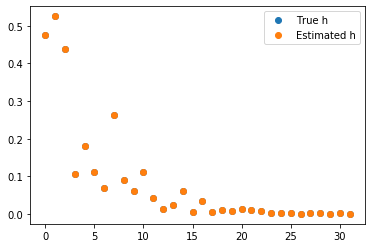

In [222]:
h_act, h_est = q1(N,L,trials)
plot_h(h_act,h_est)



 -----
 Question 2
 LSE of sparse h_act for 10,000 trials




  0%|          | 0/10000 [00:00<?, ?it/s]

Trial 1 error 0.027649652659702515:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 2 error 0.025330827903000345:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 3 error 0.028409221030405284:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 4 error 0.02993308213326803:   0%|          | 0/10000 [00:00<?, ?it/s] 

Trial 5 error 0.02862609027498754:   0%|          | 0/10000 [00:00<?, ?it/s]

Trial 5 error 0.02862609027498754:   0%|          | 5/10000 [00:00<03:28, 48.00it/s]

Trial 6 error 0.02752237901223327:   0%|          | 5/10000 [00:00<03:28, 48.00it/s]

Trial 7 error 0.028685006202838363:   0%|          | 5/10000 [00:00<03:28, 48.00it/s]

Trial 8 error 0.029770270264434844:   0%|          | 5/10000 [00:00<03:28, 48.00it/s]

Trial 9 error 0.031231215680191392:   0%|          | 5/10000 [00:00<03:28, 48.00it/s]

Trial 10 error 0.032445829446103976:   0%|          | 5/10000 [00:00<03:28, 48.00it/s]

Trial 11 error 0.032496597647932036:   0

Trial 155 error 0.02876431402027593:   2%|▏         | 150/10000 [00:03<03:23, 48.42it/s] 

Trial 155 error 0.02876431402027593:   2%|▏         | 155/10000 [00:03<03:24, 48.23it/s]

Trial 156 error 0.028704866640692297:   2%|▏         | 155/10000 [00:03<03:24, 48.23it/s]

Trial 157 error 0.02870938850335739:   2%|▏         | 155/10000 [00:03<03:24, 48.23it/s] 

Trial 158 error 0.028699884275404985:   2%|▏         | 155/10000 [00:03<03:24, 48.23it/s]

Trial 159 error 0.028676931328307467:   2%|▏         | 155/10000 [00:03<03:24, 48.23it/s]

Trial 160 error 0.028661065820801388:   2%|▏         | 155/10000 [00:03<03:24, 48.23it/s]

Trial 160 error 0.028661065820801388:   2%|▏         | 160/10000 [00:03<03:34, 45.84it/s]

Trial 161 error 0.028740224671028377:   2%|▏         | 160/10000 [00:03<03:34, 45.84it/s]

Trial 162 error 0.028748751694270037:   2%|▏         | 160/10000 [00:03<03:34, 45.84it/s]

Trial 163 error 0.028745057316203523:   2%|▏         | 160/10000 [00:03<03:34, 45.84it/s]



Trial 306 error 0.02890061200497308:   3%|▎         | 302/10000 [00:06<03:42, 43.53it/s]

Trial 307 error 0.028914130658692177:   3%|▎         | 302/10000 [00:06<03:42, 43.53it/s]

Trial 307 error 0.028914130658692177:   3%|▎         | 307/10000 [00:06<03:42, 43.66it/s]

Trial 308 error 0.028936052111253097:   3%|▎         | 307/10000 [00:06<03:42, 43.66it/s]

Trial 309 error 0.028974582722934513:   3%|▎         | 307/10000 [00:06<03:42, 43.66it/s]

Trial 310 error 0.028988790555337846:   3%|▎         | 307/10000 [00:06<03:42, 43.66it/s]

Trial 311 error 0.02896570583695134:   3%|▎         | 307/10000 [00:06<03:42, 43.66it/s] 

Trial 312 error 0.028950192560055196:   3%|▎         | 307/10000 [00:06<03:42, 43.66it/s]

Trial 312 error 0.028950192560055196:   3%|▎         | 312/10000 [00:06<03:34, 45.24it/s]

Trial 313 error 0.028946860777563907:   3%|▎         | 312/10000 [00:06<03:34, 45.24it/s]

Trial 314 error 0.028937783344102665:   3%|▎         | 312/10000 [00:06<03:34, 45.24it/s]



Trial 457 error 0.028731852283782014:   5%|▍         | 451/10000 [00:09<03:29, 45.60it/s]

Trial 458 error 0.028717903530649038:   5%|▍         | 451/10000 [00:09<03:29, 45.60it/s]

Trial 458 error 0.028717903530649038:   5%|▍         | 458/10000 [00:09<03:12, 49.49it/s]

Trial 459 error 0.028700023634724754:   5%|▍         | 458/10000 [00:09<03:12, 49.49it/s]

Trial 460 error 0.02871390668050918:   5%|▍         | 458/10000 [00:09<03:12, 49.49it/s] 

Trial 461 error 0.028711398067229256:   5%|▍         | 458/10000 [00:09<03:12, 49.49it/s]

Trial 462 error 0.02872635355372345:   5%|▍         | 458/10000 [00:09<03:12, 49.49it/s] 

Trial 463 error 0.02872016570974095:   5%|▍         | 458/10000 [00:09<03:12, 49.49it/s]

Trial 464 error 0.02871823756031245:   5%|▍         | 458/10000 [00:09<03:12, 49.49it/s]

Trial 464 error 0.02871823756031245:   5%|▍         | 464/10000 [00:09<03:12, 49.44it/s]

Trial 465 error 0.02870992241693322:   5%|▍         | 464/10000 [00:09<03:12, 49.44it/s]

Tri

Trial 608 error 0.028736755514845357:   6%|▌         | 606/10000 [00:13<03:34, 43.78it/s]

Trial 609 error 0.028733386083995324:   6%|▌         | 606/10000 [00:13<03:34, 43.78it/s]

Trial 610 error 0.028743814221060964:   6%|▌         | 606/10000 [00:13<03:34, 43.78it/s]

Trial 611 error 0.02874615948406536:   6%|▌         | 606/10000 [00:13<03:34, 43.78it/s] 

Trial 611 error 0.02874615948406536:   6%|▌         | 611/10000 [00:13<03:28, 45.00it/s]

Trial 612 error 0.02874751013000638:   6%|▌         | 611/10000 [00:13<03:28, 45.00it/s]

Trial 613 error 0.028742776700385726:   6%|▌         | 611/10000 [00:13<03:28, 45.00it/s]

Trial 614 error 0.028739521394267886:   6%|▌         | 611/10000 [00:13<03:28, 45.00it/s]

Trial 615 error 0.02873967517159466:   6%|▌         | 611/10000 [00:13<03:28, 45.00it/s] 

Trial 616 error 0.028740116482012995:   6%|▌         | 611/10000 [00:13<03:28, 45.00it/s]

Trial 616 error 0.028740116482012995:   6%|▌         | 616/10000 [00:13<03:27, 45.26it/s]

T

Trial 762 error 0.028878102245924107:   8%|▊         | 756/10000 [00:16<03:02, 50.58it/s]

Trial 762 error 0.028878102245924107:   8%|▊         | 762/10000 [00:16<02:58, 51.89it/s]

Trial 763 error 0.028880158122554917:   8%|▊         | 762/10000 [00:16<02:58, 51.89it/s]

Trial 764 error 0.028868983479547132:   8%|▊         | 762/10000 [00:16<02:58, 51.89it/s]

Trial 765 error 0.028878168112215594:   8%|▊         | 762/10000 [00:16<02:58, 51.89it/s]

Trial 766 error 0.02887687085294953:   8%|▊         | 762/10000 [00:16<02:58, 51.89it/s] 

Trial 767 error 0.02886865463947492:   8%|▊         | 762/10000 [00:16<02:58, 51.89it/s]

Trial 768 error 0.028855838625649034:   8%|▊         | 762/10000 [00:16<02:58, 51.89it/s]

Trial 768 error 0.028855838625649034:   8%|▊         | 768/10000 [00:16<03:01, 50.84it/s]

Trial 769 error 0.02885270448689395:   8%|▊         | 768/10000 [00:16<03:01, 50.84it/s] 

Trial 770 error 0.028859652393900363:   8%|▊         | 768/10000 [00:16<03:01, 50.84it/s]



Trial 916 error 0.028815982322855958:   9%|▉         | 912/10000 [00:19<02:55, 51.74it/s]

Trial 917 error 0.02881767288569345:   9%|▉         | 912/10000 [00:19<02:55, 51.74it/s] 

Trial 918 error 0.028804264262376547:   9%|▉         | 912/10000 [00:19<02:55, 51.74it/s]

Trial 918 error 0.028804264262376547:   9%|▉         | 918/10000 [00:19<02:49, 53.58it/s]

Trial 919 error 0.02880145175218514:   9%|▉         | 918/10000 [00:19<02:49, 53.58it/s] 

Trial 920 error 0.028807729131735554:   9%|▉         | 918/10000 [00:19<02:49, 53.58it/s]

Trial 921 error 0.02880564747485554:   9%|▉         | 918/10000 [00:19<02:49, 53.58it/s] 

Trial 922 error 0.028812793743466424:   9%|▉         | 918/10000 [00:19<02:49, 53.58it/s]

Trial 923 error 0.0288144241929167:   9%|▉         | 918/10000 [00:19<02:49, 53.58it/s]  

Trial 924 error 0.028817829433313326:   9%|▉         | 918/10000 [00:19<02:49, 53.58it/s]

Trial 924 error 0.028817829433313326:   9%|▉         | 924/10000 [00:19<02:47, 54.20it/s]


Trial 1068 error 0.028858538541613722:  11%|█         | 1064/10000 [00:22<02:55, 50.93it/s]

Trial 1069 error 0.0288646034685558:  11%|█         | 1064/10000 [00:22<02:55, 50.93it/s]  

Trial 1070 error 0.028867856208124473:  11%|█         | 1064/10000 [00:22<02:55, 50.93it/s]

Trial 1070 error 0.028867856208124473:  11%|█         | 1070/10000 [00:22<02:51, 52.09it/s]

Trial 1071 error 0.028864770347734863:  11%|█         | 1070/10000 [00:22<02:51, 52.09it/s]

Trial 1072 error 0.028864832843304482:  11%|█         | 1070/10000 [00:22<02:51, 52.09it/s]

Trial 1073 error 0.02886393581521457:  11%|█         | 1070/10000 [00:22<02:51, 52.09it/s] 

Trial 1074 error 0.02886666169190372:  11%|█         | 1070/10000 [00:22<02:51, 52.09it/s]

Trial 1075 error 0.028864947820646674:  11%|█         | 1070/10000 [00:22<02:51, 52.09it/s]

Trial 1076 error 0.02886869394173323:  11%|█         | 1070/10000 [00:22<02:51, 52.09it/s] 

Trial 1076 error 0.02886869394173323:  11%|█         | 1076/10000 [00:2

Trial 1218 error 0.029019685145269206:  12%|█▏        | 1218/10000 [00:25<03:12, 45.74it/s]

Trial 1219 error 0.02902402556679083:  12%|█▏        | 1218/10000 [00:25<03:12, 45.74it/s] 

Trial 1220 error 0.029026131407321087:  12%|█▏        | 1218/10000 [00:25<03:12, 45.74it/s]

Trial 1221 error 0.02904176650174313:  12%|█▏        | 1218/10000 [00:25<03:12, 45.74it/s] 

Trial 1222 error 0.029048009741120866:  12%|█▏        | 1218/10000 [00:25<03:12, 45.74it/s]

Trial 1223 error 0.029048464586034432:  12%|█▏        | 1218/10000 [00:25<03:12, 45.74it/s]

Trial 1223 error 0.029048464586034432:  12%|█▏        | 1223/10000 [00:25<03:13, 45.44it/s]

Trial 1224 error 0.029048047375712944:  12%|█▏        | 1223/10000 [00:25<03:13, 45.44it/s]

Trial 1225 error 0.029048547847092474:  12%|█▏        | 1223/10000 [00:25<03:13, 45.44it/s]

Trial 1226 error 0.029045199532589275:  12%|█▏        | 1223/10000 [00:25<03:13, 45.44it/s]

Trial 1227 error 0.029044387882838876:  12%|█▏        | 1223/10000 [00

Trial 1369 error 0.02898187884454392:  14%|█▎        | 1366/10000 [00:27<02:48, 51.28it/s] 

Trial 1370 error 0.02897572894712397:  14%|█▎        | 1366/10000 [00:27<02:48, 51.28it/s]

Trial 1371 error 0.028976396076695766:  14%|█▎        | 1366/10000 [00:28<02:48, 51.28it/s]

Trial 1372 error 0.028971171958519448:  14%|█▎        | 1366/10000 [00:28<02:48, 51.28it/s]

Trial 1372 error 0.028971171958519448:  14%|█▎        | 1372/10000 [00:28<02:51, 50.24it/s]

Trial 1373 error 0.028965300900901852:  14%|█▎        | 1372/10000 [00:28<02:51, 50.24it/s]

Trial 1374 error 0.028965823989070924:  14%|█▎        | 1372/10000 [00:28<02:51, 50.24it/s]

Trial 1375 error 0.028971184261931907:  14%|█▎        | 1372/10000 [00:28<02:51, 50.24it/s]

Trial 1376 error 0.028966023042433647:  14%|█▎        | 1372/10000 [00:28<02:51, 50.24it/s]

Trial 1377 error 0.028962760287617142:  14%|█▎        | 1372/10000 [00:28<02:51, 50.24it/s]

Trial 1378 error 0.028970927624239615:  14%|█▎        | 1372/10000 [00:

Trial 1519 error 0.028880869172115374:  15%|█▌        | 1518/10000 [00:30<02:37, 53.76it/s]

Trial 1520 error 0.02887743740996919:  15%|█▌        | 1518/10000 [00:30<02:37, 53.76it/s] 

Trial 1521 error 0.028881878640251435:  15%|█▌        | 1518/10000 [00:30<02:37, 53.76it/s]

Trial 1522 error 0.02888483256909966:  15%|█▌        | 1518/10000 [00:30<02:37, 53.76it/s] 

Trial 1523 error 0.02888638457407642:  15%|█▌        | 1518/10000 [00:31<02:37, 53.76it/s]

Trial 1524 error 0.02888849329873058:  15%|█▌        | 1518/10000 [00:31<02:37, 53.76it/s]

Trial 1524 error 0.02888849329873058:  15%|█▌        | 1524/10000 [00:31<02:37, 53.86it/s]

Trial 1525 error 0.02888793169957063:  15%|█▌        | 1524/10000 [00:31<02:37, 53.86it/s]

Trial 1526 error 0.028882298145558975:  15%|█▌        | 1524/10000 [00:31<02:37, 53.86it/s]

Trial 1527 error 0.028886179793561752:  15%|█▌        | 1524/10000 [00:31<02:37, 53.86it/s]

Trial 1528 error 0.02888675266649291:  15%|█▌        | 1524/10000 [00:31<0

Trial 1669 error 0.028878640480932593:  17%|█▋        | 1667/10000 [00:33<02:57, 46.96it/s]

Trial 1670 error 0.028874943271831627:  17%|█▋        | 1667/10000 [00:33<02:57, 46.96it/s]

Trial 1671 error 0.028878498095895325:  17%|█▋        | 1667/10000 [00:34<02:57, 46.96it/s]

Trial 1672 error 0.028883263443393987:  17%|█▋        | 1667/10000 [00:34<02:57, 46.96it/s]

Trial 1673 error 0.02888735262746893:  17%|█▋        | 1667/10000 [00:34<02:57, 46.96it/s] 

Trial 1673 error 0.02888735262746893:  17%|█▋        | 1673/10000 [00:34<02:51, 48.56it/s]

Trial 1674 error 0.028886410306885654:  17%|█▋        | 1673/10000 [00:34<02:51, 48.56it/s]

Trial 1675 error 0.028884115181281488:  17%|█▋        | 1673/10000 [00:34<02:51, 48.56it/s]

Trial 1676 error 0.028884278304719797:  17%|█▋        | 1673/10000 [00:34<02:51, 48.56it/s]

Trial 1677 error 0.028884458797282752:  17%|█▋        | 1673/10000 [00:34<02:51, 48.56it/s]

Trial 1678 error 0.028884532889496266:  17%|█▋        | 1673/10000 [00:

Trial 1818 error 0.028896710663747313:  18%|█▊        | 1813/10000 [00:37<02:59, 45.53it/s]

Trial 1818 error 0.028896710663747313:  18%|█▊        | 1818/10000 [00:37<03:05, 44.22it/s]

Trial 1819 error 0.028898986457610732:  18%|█▊        | 1818/10000 [00:37<03:05, 44.22it/s]

Trial 1820 error 0.02889713055220849:  18%|█▊        | 1818/10000 [00:37<03:05, 44.22it/s] 

Trial 1821 error 0.028899863192912534:  18%|█▊        | 1818/10000 [00:37<03:05, 44.22it/s]

Trial 1822 error 0.02890002793985431:  18%|█▊        | 1818/10000 [00:37<03:05, 44.22it/s] 

Trial 1823 error 0.02889437802090187:  18%|█▊        | 1818/10000 [00:37<03:05, 44.22it/s]

Trial 1823 error 0.02889437802090187:  18%|█▊        | 1823/10000 [00:37<03:01, 44.98it/s]

Trial 1824 error 0.02889562626616736:  18%|█▊        | 1823/10000 [00:37<03:01, 44.98it/s]

Trial 1825 error 0.028895014288895654:  18%|█▊        | 1823/10000 [00:37<03:01, 44.98it/s]

Trial 1826 error 0.02890045285465458:  18%|█▊        | 1823/10000 [00:37<

Trial 1967 error 0.028922829831866018:  20%|█▉        | 1965/10000 [00:40<02:40, 50.02it/s]

Trial 1968 error 0.02892634816261435:  20%|█▉        | 1965/10000 [00:40<02:40, 50.02it/s] 

Trial 1969 error 0.028931230257396523:  20%|█▉        | 1965/10000 [00:40<02:40, 50.02it/s]

Trial 1970 error 0.028923357783383886:  20%|█▉        | 1965/10000 [00:40<02:40, 50.02it/s]

Trial 1971 error 0.028922506433070705:  20%|█▉        | 1965/10000 [00:40<02:40, 50.02it/s]

Trial 1971 error 0.028922506433070705:  20%|█▉        | 1971/10000 [00:40<02:48, 47.67it/s]

Trial 1972 error 0.028916821590496952:  20%|█▉        | 1971/10000 [00:40<02:48, 47.67it/s]

Trial 1973 error 0.02892356267943655:  20%|█▉        | 1971/10000 [00:40<02:48, 47.67it/s] 

Trial 1974 error 0.028922299779347214:  20%|█▉        | 1971/10000 [00:40<02:48, 47.67it/s]

Trial 1975 error 0.028922505650374228:  20%|█▉        | 1971/10000 [00:40<02:48, 47.67it/s]

Trial 1976 error 0.02891521426103835:  20%|█▉        | 1971/10000 [00:

Trial 2117 error 0.028933188449076414:  21%|██        | 2113/10000 [00:43<02:55, 45.00it/s]

Trial 2118 error 0.02893570015273425:  21%|██        | 2113/10000 [00:43<02:55, 45.00it/s] 

Trial 2118 error 0.02893570015273425:  21%|██        | 2118/10000 [00:43<02:55, 44.81it/s]

Trial 2119 error 0.028935927876307634:  21%|██        | 2118/10000 [00:43<02:55, 44.81it/s]

Trial 2120 error 0.02893131256954064:  21%|██        | 2118/10000 [00:43<02:55, 44.81it/s] 

Trial 2121 error 0.028931570145707176:  21%|██        | 2118/10000 [00:43<02:55, 44.81it/s]

Trial 2122 error 0.02892979129570285:  21%|██        | 2118/10000 [00:43<02:55, 44.81it/s] 

Trial 2123 error 0.028929133640575498:  21%|██        | 2118/10000 [00:43<02:55, 44.81it/s]

Trial 2123 error 0.028929133640575498:  21%|██        | 2123/10000 [00:43<02:52, 45.65it/s]

Trial 2124 error 0.02892849912421022:  21%|██        | 2123/10000 [00:43<02:52, 45.65it/s] 

Trial 2125 error 0.028929681993964965:  21%|██        | 2123/10000 [00:

Trial 2267 error 0.02886691322143753:  23%|██▎       | 2262/10000 [00:46<02:24, 53.44it/s] 

Trial 2268 error 0.028869359580812243:  23%|██▎       | 2262/10000 [00:46<02:24, 53.44it/s]

Trial 2268 error 0.028869359580812243:  23%|██▎       | 2268/10000 [00:46<02:25, 53.24it/s]

Trial 2269 error 0.02886596496609105:  23%|██▎       | 2268/10000 [00:46<02:25, 53.24it/s] 

Trial 2270 error 0.028868957238321575:  23%|██▎       | 2268/10000 [00:46<02:25, 53.24it/s]

Trial 2271 error 0.028866699959942118:  23%|██▎       | 2268/10000 [00:46<02:25, 53.24it/s]

Trial 2272 error 0.028866828176699368:  23%|██▎       | 2268/10000 [00:46<02:25, 53.24it/s]

Trial 2273 error 0.028868458425029598:  23%|██▎       | 2268/10000 [00:46<02:25, 53.24it/s]

Trial 2274 error 0.02886995064448142:  23%|██▎       | 2268/10000 [00:46<02:25, 53.24it/s] 

Trial 2274 error 0.02886995064448142:  23%|██▎       | 2274/10000 [00:46<02:33, 50.17it/s]

Trial 2275 error 0.028871104136514718:  23%|██▎       | 2274/10000 [00:

Trial 2418 error 0.028888791732076792:  24%|██▍       | 2416/10000 [00:49<02:22, 53.26it/s]

Trial 2419 error 0.028890328969810638:  24%|██▍       | 2416/10000 [00:49<02:22, 53.26it/s]

Trial 2420 error 0.02889262192177614:  24%|██▍       | 2416/10000 [00:49<02:22, 53.26it/s] 

Trial 2421 error 0.028891840766478435:  24%|██▍       | 2416/10000 [00:49<02:22, 53.26it/s]

Trial 2422 error 0.028893212766728113:  24%|██▍       | 2416/10000 [00:49<02:22, 53.26it/s]

Trial 2423 error 0.02889554969996975:  24%|██▍       | 2416/10000 [00:49<02:22, 53.26it/s] 

Trial 2423 error 0.02889554969996975:  24%|██▍       | 2423/10000 [00:49<02:17, 55.12it/s]

Trial 2424 error 0.028899054263305093:  24%|██▍       | 2423/10000 [00:49<02:17, 55.12it/s]

Trial 2425 error 0.0288958253851481:  24%|██▍       | 2423/10000 [00:49<02:17, 55.12it/s]  

Trial 2426 error 0.02889432355377517:  24%|██▍       | 2423/10000 [00:49<02:17, 55.12it/s]

Trial 2427 error 0.028898975906008376:  24%|██▍       | 2423/10000 [00:4

Trial 2569 error 0.0288755435070308:  26%|██▌       | 2565/10000 [00:52<02:22, 52.11it/s] 

Trial 2570 error 0.028875819812715437:  26%|██▌       | 2565/10000 [00:52<02:22, 52.11it/s]

Trial 2571 error 0.028877189201815506:  26%|██▌       | 2565/10000 [00:52<02:22, 52.11it/s]

Trial 2571 error 0.028877189201815506:  26%|██▌       | 2571/10000 [00:52<02:32, 48.63it/s]

Trial 2572 error 0.028881342504066536:  26%|██▌       | 2571/10000 [00:52<02:32, 48.63it/s]

Trial 2573 error 0.028883691552699924:  26%|██▌       | 2571/10000 [00:52<02:32, 48.63it/s]

Trial 2574 error 0.02888444063252286:  26%|██▌       | 2571/10000 [00:52<02:32, 48.63it/s] 

Trial 2575 error 0.02888902918404957:  26%|██▌       | 2571/10000 [00:52<02:32, 48.63it/s]

Trial 2576 error 0.028890613144614847:  26%|██▌       | 2571/10000 [00:52<02:32, 48.63it/s]

Trial 2576 error 0.028890613144614847:  26%|██▌       | 2576/10000 [00:52<02:36, 47.40it/s]

Trial 2577 error 0.028891211915225253:  26%|██▌       | 2576/10000 [00:5

Trial 2720 error 0.028919833186932316:  27%|██▋       | 2716/10000 [00:54<02:12, 55.06it/s]

Trial 2721 error 0.028919573053801804:  27%|██▋       | 2716/10000 [00:54<02:12, 55.06it/s]

Trial 2722 error 0.028921471579325665:  27%|██▋       | 2716/10000 [00:54<02:12, 55.06it/s]

Trial 2722 error 0.028921471579325665:  27%|██▋       | 2722/10000 [00:54<02:12, 55.10it/s]

Trial 2723 error 0.028922539119689183:  27%|██▋       | 2722/10000 [00:54<02:12, 55.10it/s]

Trial 2724 error 0.028923368906244164:  27%|██▋       | 2722/10000 [00:54<02:12, 55.10it/s]

Trial 2725 error 0.028927298653845968:  27%|██▋       | 2722/10000 [00:54<02:12, 55.10it/s]

Trial 2726 error 0.02892671002450201:  27%|██▋       | 2722/10000 [00:54<02:12, 55.10it/s] 

Trial 2727 error 0.028924705685745292:  27%|██▋       | 2722/10000 [00:55<02:12, 55.10it/s]

Trial 2728 error 0.02892142090638201:  27%|██▋       | 2722/10000 [00:55<02:12, 55.10it/s] 

Trial 2728 error 0.02892142090638201:  27%|██▋       | 2728/10000 [00:

Trial 2871 error 0.02894575506145049:  29%|██▊       | 2869/10000 [00:57<02:03, 57.87it/s] 

Trial 2872 error 0.028943536502851214:  29%|██▊       | 2869/10000 [00:57<02:03, 57.87it/s]

Trial 2873 error 0.028943903353877077:  29%|██▊       | 2869/10000 [00:57<02:03, 57.87it/s]

Trial 2874 error 0.028940384180520036:  29%|██▊       | 2869/10000 [00:57<02:03, 57.87it/s]

Trial 2875 error 0.028939165763549275:  29%|██▊       | 2869/10000 [00:57<02:03, 57.87it/s]

Trial 2876 error 0.028940896330841646:  29%|██▊       | 2869/10000 [00:57<02:03, 57.87it/s]

Trial 2876 error 0.028940896330841646:  29%|██▉       | 2876/10000 [00:57<02:00, 58.93it/s]

Trial 2877 error 0.028939239736687557:  29%|██▉       | 2876/10000 [00:57<02:00, 58.93it/s]

Trial 2878 error 0.02893682377166376:  29%|██▉       | 2876/10000 [00:57<02:00, 58.93it/s] 

Trial 2879 error 0.028938386182148064:  29%|██▉       | 2876/10000 [00:57<02:00, 58.93it/s]

Trial 2880 error 0.028934022221815882:  29%|██▉       | 2876/10000 [00

Trial 3023 error 0.028897564687653362:  30%|███       | 3018/10000 [01:00<02:26, 47.77it/s]

Trial 3023 error 0.028897564687653362:  30%|███       | 3023/10000 [01:00<02:25, 48.04it/s]

Trial 3024 error 0.028899697980344072:  30%|███       | 3023/10000 [01:00<02:25, 48.04it/s]

Trial 3025 error 0.028896947366680914:  30%|███       | 3023/10000 [01:00<02:25, 48.04it/s]

Trial 3026 error 0.028894076536129132:  30%|███       | 3023/10000 [01:00<02:25, 48.04it/s]

Trial 3027 error 0.02889159030516054:  30%|███       | 3023/10000 [01:00<02:25, 48.04it/s] 

Trial 3028 error 0.028887504106787205:  30%|███       | 3023/10000 [01:00<02:25, 48.04it/s]

Trial 3029 error 0.02888706731980673:  30%|███       | 3023/10000 [01:00<02:25, 48.04it/s] 

Trial 3029 error 0.02888706731980673:  30%|███       | 3029/10000 [01:00<02:18, 50.36it/s]

Trial 3030 error 0.02888632251979019:  30%|███       | 3029/10000 [01:00<02:18, 50.36it/s]

Trial 3031 error 0.0288888849865427:  30%|███       | 3029/10000 [01:00<

Trial 3173 error 0.02893375730630751:  32%|███▏      | 3167/10000 [01:03<02:16, 49.92it/s] 

Trial 3173 error 0.02893375730630751:  32%|███▏      | 3173/10000 [01:03<02:19, 48.89it/s]

Trial 3174 error 0.02893257237347593:  32%|███▏      | 3173/10000 [01:03<02:19, 48.89it/s]

Trial 3175 error 0.028930702179934827:  32%|███▏      | 3173/10000 [01:03<02:19, 48.89it/s]

Trial 3176 error 0.028931976849261878:  32%|███▏      | 3173/10000 [01:03<02:19, 48.89it/s]

Trial 3177 error 0.02893150595084992:  32%|███▏      | 3173/10000 [01:03<02:19, 48.89it/s] 

Trial 3178 error 0.028930744034076354:  32%|███▏      | 3173/10000 [01:03<02:19, 48.89it/s]

Trial 3178 error 0.028930744034076354:  32%|███▏      | 3178/10000 [01:03<02:22, 47.71it/s]

Trial 3179 error 0.028929665813541443:  32%|███▏      | 3178/10000 [01:03<02:22, 47.71it/s]

Trial 3180 error 0.02892850780783878:  32%|███▏      | 3178/10000 [01:03<02:22, 47.71it/s] 

Trial 3181 error 0.028925861871069415:  32%|███▏      | 3178/10000 [01:0

Trial 3322 error 0.028939354451059413:  33%|███▎      | 3319/10000 [01:06<02:18, 48.24it/s]

Trial 3323 error 0.028938092838380784:  33%|███▎      | 3319/10000 [01:06<02:18, 48.24it/s]

Trial 3324 error 0.0289397619249248:  33%|███▎      | 3319/10000 [01:06<02:18, 48.24it/s]  

Trial 3324 error 0.0289397619249248:  33%|███▎      | 3324/10000 [01:06<02:17, 48.61it/s]

Trial 3325 error 0.02893775987623537:  33%|███▎      | 3324/10000 [01:06<02:17, 48.61it/s]

Trial 3326 error 0.028936548216349854:  33%|███▎      | 3324/10000 [01:06<02:17, 48.61it/s]

Trial 3327 error 0.02893720041873521:  33%|███▎      | 3324/10000 [01:06<02:17, 48.61it/s] 

Trial 3328 error 0.028936351915845104:  33%|███▎      | 3324/10000 [01:06<02:17, 48.61it/s]

Trial 3329 error 0.028937174682248833:  33%|███▎      | 3324/10000 [01:06<02:17, 48.61it/s]

Trial 3329 error 0.028937174682248833:  33%|███▎      | 3329/10000 [01:06<02:23, 46.43it/s]

Trial 3330 error 0.028936031798633514:  33%|███▎      | 3329/10000 [01:06

Trial 3473 error 0.028930277312060965:  35%|███▍      | 3469/10000 [01:09<02:08, 50.75it/s]

Trial 3474 error 0.028928869125435568:  35%|███▍      | 3469/10000 [01:09<02:08, 50.75it/s]

Trial 3475 error 0.028929864626002496:  35%|███▍      | 3469/10000 [01:09<02:08, 50.75it/s]

Trial 3475 error 0.028929864626002496:  35%|███▍      | 3475/10000 [01:09<02:08, 50.65it/s]

Trial 3476 error 0.028929796521652524:  35%|███▍      | 3475/10000 [01:09<02:08, 50.65it/s]

Trial 3477 error 0.028930374723242346:  35%|███▍      | 3475/10000 [01:09<02:08, 50.65it/s]

Trial 3478 error 0.028932024479345526:  35%|███▍      | 3475/10000 [01:09<02:08, 50.65it/s]

Trial 3479 error 0.02893082558056679:  35%|███▍      | 3475/10000 [01:09<02:08, 50.65it/s] 

Trial 3480 error 0.0289309541769988:  35%|███▍      | 3475/10000 [01:09<02:08, 50.65it/s] 

Trial 3481 error 0.02893037280921955:  35%|███▍      | 3475/10000 [01:09<02:08, 50.65it/s]

Trial 3482 error 0.02892767679831986:  35%|███▍      | 3475/10000 [01:09

Trial 3624 error 0.028899334929518686:  36%|███▌      | 3619/10000 [01:12<01:58, 54.05it/s]

Trial 3625 error 0.02889929527807961:  36%|███▌      | 3619/10000 [01:12<01:58, 54.05it/s] 

Trial 3625 error 0.02889929527807961:  36%|███▋      | 3625/10000 [01:12<02:03, 51.51it/s]

Trial 3626 error 0.028898456366202425:  36%|███▋      | 3625/10000 [01:12<02:03, 51.51it/s]

Trial 3627 error 0.028898459391889196:  36%|███▋      | 3625/10000 [01:12<02:03, 51.51it/s]

Trial 3628 error 0.028900600422069312:  36%|███▋      | 3625/10000 [01:12<02:03, 51.51it/s]

Trial 3629 error 0.0288989825391448:  36%|███▋      | 3625/10000 [01:12<02:03, 51.51it/s]  

Trial 3630 error 0.028896885867838944:  36%|███▋      | 3625/10000 [01:12<02:03, 51.51it/s]

Trial 3631 error 0.02889615097307875:  36%|███▋      | 3625/10000 [01:12<02:03, 51.51it/s] 

Trial 3631 error 0.02889615097307875:  36%|███▋      | 3631/10000 [01:12<02:00, 52.98it/s]

Trial 3632 error 0.02889541878832187:  36%|███▋      | 3631/10000 [01:12

Trial 3775 error 0.028926417473526197:  38%|███▊      | 3771/10000 [01:15<01:54, 54.41it/s]

Trial 3776 error 0.02892495460506514:  38%|███▊      | 3771/10000 [01:15<01:54, 54.41it/s] 

Trial 3777 error 0.02892603367499521:  38%|███▊      | 3771/10000 [01:15<01:54, 54.41it/s]

Trial 3777 error 0.02892603367499521:  38%|███▊      | 3777/10000 [01:15<01:53, 54.75it/s]

Trial 3778 error 0.028926933197107114:  38%|███▊      | 3777/10000 [01:15<01:53, 54.75it/s]

Trial 3779 error 0.028926260603373135:  38%|███▊      | 3777/10000 [01:15<01:53, 54.75it/s]

Trial 3780 error 0.02892537694908341:  38%|███▊      | 3777/10000 [01:15<01:53, 54.75it/s] 

Trial 3781 error 0.028924468091267235:  38%|███▊      | 3777/10000 [01:15<01:53, 54.75it/s]

Trial 3782 error 0.028925293418291528:  38%|███▊      | 3777/10000 [01:15<01:53, 54.75it/s]

Trial 3783 error 0.028925223290843596:  38%|███▊      | 3777/10000 [01:15<01:53, 54.75it/s]

Trial 3783 error 0.028925223290843596:  38%|███▊      | 3783/10000 [01:1

Trial 3925 error 0.028956008514778156:  39%|███▉      | 3922/10000 [01:18<02:01, 50.22it/s]

Trial 3926 error 0.028955497389884975:  39%|███▉      | 3922/10000 [01:18<02:01, 50.22it/s]

Trial 3927 error 0.02895647379590456:  39%|███▉      | 3922/10000 [01:18<02:01, 50.22it/s] 

Trial 3928 error 0.028955453852404864:  39%|███▉      | 3922/10000 [01:18<02:01, 50.22it/s]

Trial 3928 error 0.028955453852404864:  39%|███▉      | 3928/10000 [01:18<01:56, 52.26it/s]

Trial 3929 error 0.028955325163986603:  39%|███▉      | 3928/10000 [01:18<01:56, 52.26it/s]

Trial 3930 error 0.028955925961991872:  39%|███▉      | 3928/10000 [01:18<01:56, 52.26it/s]

Trial 3931 error 0.02895715899284162:  39%|███▉      | 3928/10000 [01:18<01:56, 52.26it/s] 

Trial 3932 error 0.02895436959125208:  39%|███▉      | 3928/10000 [01:18<01:56, 52.26it/s]

Trial 3933 error 0.02895679214368363:  39%|███▉      | 3928/10000 [01:18<01:56, 52.26it/s]

Trial 3934 error 0.02895688107963025:  39%|███▉      | 3928/10000 [01:18

Trial 4075 error 0.028951031651349976:  41%|████      | 4074/10000 [01:21<01:54, 51.72it/s]

Trial 4076 error 0.02895149580125034:  41%|████      | 4074/10000 [01:21<01:54, 51.72it/s] 

Trial 4077 error 0.02895360137352587:  41%|████      | 4074/10000 [01:21<01:54, 51.72it/s]

Trial 4078 error 0.028953973248402275:  41%|████      | 4074/10000 [01:21<01:54, 51.72it/s]

Trial 4079 error 0.028952452038944407:  41%|████      | 4074/10000 [01:21<01:54, 51.72it/s]

Trial 4080 error 0.028953319213741103:  41%|████      | 4074/10000 [01:21<01:54, 51.72it/s]

Trial 4080 error 0.028953319213741103:  41%|████      | 4080/10000 [01:21<01:51, 52.96it/s]

Trial 4081 error 0.028951944989015172:  41%|████      | 4080/10000 [01:21<01:51, 52.96it/s]

Trial 4082 error 0.02895204263389403:  41%|████      | 4080/10000 [01:21<01:51, 52.96it/s] 

Trial 4083 error 0.02895048174480221:  41%|████      | 4080/10000 [01:21<01:51, 52.96it/s]

Trial 4084 error 0.02895130891377388:  41%|████      | 4080/10000 [01:21

Trial 4226 error 0.028962718821870046:  42%|████▏     | 4222/10000 [01:24<01:46, 54.46it/s]

Trial 4227 error 0.02896287646738998:  42%|████▏     | 4222/10000 [01:24<01:46, 54.46it/s] 

Trial 4228 error 0.028962369686650124:  42%|████▏     | 4222/10000 [01:24<01:46, 54.46it/s]

Trial 4228 error 0.028962369686650124:  42%|████▏     | 4228/10000 [01:24<01:47, 53.46it/s]

Trial 4229 error 0.028963365322607095:  42%|████▏     | 4228/10000 [01:24<01:47, 53.46it/s]

Trial 4230 error 0.02896228503598637:  42%|████▏     | 4228/10000 [01:24<01:47, 53.46it/s] 

Trial 4231 error 0.02896455115652418:  42%|████▏     | 4228/10000 [01:24<01:47, 53.46it/s]

Trial 4232 error 0.0289624525459497:  42%|████▏     | 4228/10000 [01:24<01:47, 53.46it/s] 

Trial 4233 error 0.02896414563859426:  42%|████▏     | 4228/10000 [01:24<01:47, 53.46it/s]

Trial 4234 error 0.02896461177050315:  42%|████▏     | 4228/10000 [01:24<01:47, 53.46it/s]

Trial 4234 error 0.02896461177050315:  42%|████▏     | 4234/10000 [01:24<0

Trial 4377 error 0.028960695013839338:  44%|████▎     | 4373/10000 [01:27<01:42, 54.63it/s]

Trial 4378 error 0.02895990395589458:  44%|████▎     | 4373/10000 [01:27<01:42, 54.63it/s] 

Trial 4379 error 0.02895819243629826:  44%|████▎     | 4373/10000 [01:27<01:42, 54.63it/s]

Trial 4379 error 0.02895819243629826:  44%|████▍     | 4379/10000 [01:27<01:41, 55.52it/s]

Trial 4380 error 0.02895853748438717:  44%|████▍     | 4379/10000 [01:27<01:41, 55.52it/s]

Trial 4381 error 0.028959017345370406:  44%|████▍     | 4379/10000 [01:27<01:41, 55.52it/s]

Trial 4382 error 0.028958487120566725:  44%|████▍     | 4379/10000 [01:27<01:41, 55.52it/s]

Trial 4383 error 0.028958896192312896:  44%|████▍     | 4379/10000 [01:27<01:41, 55.52it/s]

Trial 4384 error 0.02895697785848318:  44%|████▍     | 4379/10000 [01:27<01:41, 55.52it/s] 

Trial 4385 error 0.02895917944854227:  44%|████▍     | 4379/10000 [01:27<01:41, 55.52it/s]

Trial 4385 error 0.02895917944854227:  44%|████▍     | 4385/10000 [01:27<0

Trial 4527 error 0.028958236144500826:  45%|████▌     | 4522/10000 [01:30<01:55, 47.55it/s]

Trial 4528 error 0.028956668406249008:  45%|████▌     | 4522/10000 [01:30<01:55, 47.55it/s]

Trial 4528 error 0.028956668406249008:  45%|████▌     | 4528/10000 [01:30<01:54, 47.98it/s]

Trial 4529 error 0.028957216865835914:  45%|████▌     | 4528/10000 [01:30<01:54, 47.98it/s]

Trial 4530 error 0.028956560791273074:  45%|████▌     | 4528/10000 [01:30<01:54, 47.98it/s]

Trial 4531 error 0.028959606636486248:  45%|████▌     | 4528/10000 [01:30<01:54, 47.98it/s]

Trial 4532 error 0.028958256030194876:  45%|████▌     | 4528/10000 [01:30<01:54, 47.98it/s]

Trial 4533 error 0.028958210604566468:  45%|████▌     | 4528/10000 [01:30<01:54, 47.98it/s]

Trial 4533 error 0.028958210604566468:  45%|████▌     | 4533/10000 [01:30<02:00, 45.31it/s]

Trial 4534 error 0.028959276047108948:  45%|████▌     | 4533/10000 [01:30<02:00, 45.31it/s]

Trial 4535 error 0.028958732077606256:  45%|████▌     | 4533/10000 [01

Trial 4675 error 0.02896943982997727:  47%|████▋     | 4671/10000 [01:33<01:56, 45.60it/s] 

Trial 4676 error 0.02897047386993456:  47%|████▋     | 4671/10000 [01:33<01:56, 45.60it/s]

Trial 4676 error 0.02897047386993456:  47%|████▋     | 4676/10000 [01:33<01:55, 45.93it/s]

Trial 4677 error 0.028969485810662807:  47%|████▋     | 4676/10000 [01:33<01:55, 45.93it/s]

Trial 4678 error 0.028967752507907767:  47%|████▋     | 4676/10000 [01:33<01:55, 45.93it/s]

Trial 4679 error 0.028968579807176917:  47%|████▋     | 4676/10000 [01:33<01:55, 45.93it/s]

Trial 4680 error 0.02897091772941712:  47%|████▋     | 4676/10000 [01:33<01:55, 45.93it/s] 

Trial 4681 error 0.028972862341574535:  47%|████▋     | 4676/10000 [01:33<01:55, 45.93it/s]

Trial 4681 error 0.028972862341574535:  47%|████▋     | 4681/10000 [01:33<01:58, 44.92it/s]

Trial 4682 error 0.028973557438267083:  47%|████▋     | 4681/10000 [01:33<01:58, 44.92it/s]

Trial 4683 error 0.028972097716513958:  47%|████▋     | 4681/10000 [01:3

Trial 4823 error 0.02895657189274744:  48%|████▊     | 4819/10000 [01:36<01:53, 45.48it/s] 

Trial 4824 error 0.028955729355445183:  48%|████▊     | 4819/10000 [01:36<01:53, 45.48it/s]

Trial 4824 error 0.028955729355445183:  48%|████▊     | 4824/10000 [01:36<01:55, 44.90it/s]

Trial 4825 error 0.028952525798837708:  48%|████▊     | 4824/10000 [01:36<01:55, 44.90it/s]

Trial 4826 error 0.028953786668788863:  48%|████▊     | 4824/10000 [01:36<01:55, 44.90it/s]

Trial 4827 error 0.028951599600669342:  48%|████▊     | 4824/10000 [01:36<01:55, 44.90it/s]

Trial 4828 error 0.028950912242594672:  48%|████▊     | 4824/10000 [01:36<01:55, 44.90it/s]

Trial 4829 error 0.028950633087384152:  48%|████▊     | 4824/10000 [01:36<01:55, 44.90it/s]

Trial 4829 error 0.028950633087384152:  48%|████▊     | 4829/10000 [01:36<01:54, 45.15it/s]

Trial 4830 error 0.028949962324863507:  48%|████▊     | 4829/10000 [01:36<01:54, 45.15it/s]

Trial 4831 error 0.02895034812016606:  48%|████▊     | 4829/10000 [01:

Trial 4971 error 0.028966329943319873:  50%|████▉     | 4966/10000 [01:39<01:46, 47.28it/s]

Trial 4972 error 0.028966148587592364:  50%|████▉     | 4966/10000 [01:39<01:46, 47.28it/s]

Trial 4972 error 0.028966148587592364:  50%|████▉     | 4972/10000 [01:39<01:42, 49.03it/s]

Trial 4973 error 0.028966164125991133:  50%|████▉     | 4972/10000 [01:39<01:42, 49.03it/s]

Trial 4974 error 0.028965913753277884:  50%|████▉     | 4972/10000 [01:39<01:42, 49.03it/s]

Trial 4975 error 0.028964285072807683:  50%|████▉     | 4972/10000 [01:39<01:42, 49.03it/s]

Trial 4976 error 0.02896426636782609:  50%|████▉     | 4972/10000 [01:39<01:42, 49.03it/s] 

Trial 4977 error 0.028963553310619162:  50%|████▉     | 4972/10000 [01:39<01:42, 49.03it/s]

Trial 4978 error 0.028963983546353437:  50%|████▉     | 4972/10000 [01:39<01:42, 49.03it/s]

Trial 4978 error 0.028963983546353437:  50%|████▉     | 4978/10000 [01:39<01:39, 50.35it/s]

Trial 4979 error 0.028963944183053248:  50%|████▉     | 4978/10000 [01

Trial 5118 error 0.028954506566165043:  51%|█████     | 5116/10000 [01:42<01:45, 46.40it/s]

Trial 5119 error 0.028954684491436924:  51%|█████     | 5116/10000 [01:42<01:45, 46.40it/s]

Trial 5120 error 0.028953522613937608:  51%|█████     | 5116/10000 [01:42<01:45, 46.40it/s]

Trial 5121 error 0.02895428708912818:  51%|█████     | 5116/10000 [01:42<01:45, 46.40it/s] 

Trial 5121 error 0.02895428708912818:  51%|█████     | 5121/10000 [01:42<01:47, 45.51it/s]

Trial 5122 error 0.028954513710528946:  51%|█████     | 5121/10000 [01:42<01:47, 45.51it/s]

Trial 5123 error 0.02895440496031667:  51%|█████     | 5121/10000 [01:43<01:47, 45.51it/s] 

Trial 5124 error 0.028954537965328014:  51%|█████     | 5121/10000 [01:43<01:47, 45.51it/s]

Trial 5125 error 0.02895570906714024:  51%|█████     | 5121/10000 [01:43<01:47, 45.51it/s] 

Trial 5126 error 0.028957460659891913:  51%|█████     | 5121/10000 [01:43<01:47, 45.51it/s]

Trial 5126 error 0.028957460659891913:  51%|█████▏    | 5126/10000 [01:

Trial 5266 error 0.028956569263459023:  53%|█████▎    | 5264/10000 [01:46<01:37, 48.72it/s]

Trial 5267 error 0.028959005098042844:  53%|█████▎    | 5264/10000 [01:46<01:37, 48.72it/s]

Trial 5268 error 0.028958714093301006:  53%|█████▎    | 5264/10000 [01:46<01:37, 48.72it/s]

Trial 5269 error 0.028959460361610054:  53%|█████▎    | 5264/10000 [01:46<01:37, 48.72it/s]

Trial 5269 error 0.028959460361610054:  53%|█████▎    | 5269/10000 [01:46<01:37, 48.33it/s]

Trial 5270 error 0.028960468953126612:  53%|█████▎    | 5269/10000 [01:46<01:37, 48.33it/s]

Trial 5271 error 0.02896038168130171:  53%|█████▎    | 5269/10000 [01:46<01:37, 48.33it/s] 

Trial 5272 error 0.028959881284903562:  53%|█████▎    | 5269/10000 [01:46<01:37, 48.33it/s]

Trial 5273 error 0.028960037873615098:  53%|█████▎    | 5269/10000 [01:46<01:37, 48.33it/s]

Trial 5274 error 0.02895962428005242:  53%|█████▎    | 5269/10000 [01:46<01:37, 48.33it/s] 

Trial 5275 error 0.028959885585671866:  53%|█████▎    | 5269/10000 [01

Trial 5415 error 0.02896146288207747:  54%|█████▍    | 5412/10000 [01:49<01:31, 50.01it/s] 

Trial 5416 error 0.028961110996189716:  54%|█████▍    | 5412/10000 [01:49<01:31, 50.01it/s]

Trial 5417 error 0.02896214450927088:  54%|█████▍    | 5412/10000 [01:49<01:31, 50.01it/s] 

Trial 5418 error 0.028961790888759335:  54%|█████▍    | 5412/10000 [01:49<01:31, 50.01it/s]

Trial 5418 error 0.028961790888759335:  54%|█████▍    | 5418/10000 [01:49<01:38, 46.56it/s]

Trial 5419 error 0.028960502413977855:  54%|█████▍    | 5418/10000 [01:49<01:38, 46.56it/s]

Trial 5420 error 0.028960390026863132:  54%|█████▍    | 5418/10000 [01:49<01:38, 46.56it/s]

Trial 5421 error 0.028962167146496978:  54%|█████▍    | 5418/10000 [01:49<01:38, 46.56it/s]

Trial 5422 error 0.028959774333485226:  54%|█████▍    | 5418/10000 [01:49<01:38, 46.56it/s]

Trial 5423 error 0.028957514112169108:  54%|█████▍    | 5418/10000 [01:49<01:38, 46.56it/s]

Trial 5424 error 0.028957395121573793:  54%|█████▍    | 5418/10000 [01

Trial 5563 error 0.02896347357684211:  56%|█████▌    | 5563/10000 [01:52<01:33, 47.25it/s]

Trial 5564 error 0.028963556012112857:  56%|█████▌    | 5563/10000 [01:52<01:33, 47.25it/s]

Trial 5565 error 0.028964677802134665:  56%|█████▌    | 5563/10000 [01:52<01:33, 47.25it/s]

Trial 5566 error 0.028963248862729846:  56%|█████▌    | 5563/10000 [01:52<01:33, 47.25it/s]

Trial 5567 error 0.02896335446195687:  56%|█████▌    | 5563/10000 [01:52<01:33, 47.25it/s] 

Trial 5568 error 0.028962232158926026:  56%|█████▌    | 5563/10000 [01:52<01:33, 47.25it/s]

Trial 5568 error 0.028962232158926026:  56%|█████▌    | 5568/10000 [01:52<01:37, 45.62it/s]

Trial 5569 error 0.028963932055714986:  56%|█████▌    | 5568/10000 [01:52<01:37, 45.62it/s]

Trial 5570 error 0.028964114804207804:  56%|█████▌    | 5568/10000 [01:52<01:37, 45.62it/s]

Trial 5571 error 0.028964917530726213:  56%|█████▌    | 5568/10000 [01:52<01:37, 45.62it/s]

Trial 5572 error 0.02896663192599007:  56%|█████▌    | 5568/10000 [01:5

Trial 5712 error 0.02894468228807243:  57%|█████▋    | 5706/10000 [01:55<01:27, 49.00it/s]

Trial 5712 error 0.02894468228807243:  57%|█████▋    | 5712/10000 [01:55<01:24, 50.54it/s]

Trial 5713 error 0.02894452636230592:  57%|█████▋    | 5712/10000 [01:55<01:24, 50.54it/s]

Trial 5714 error 0.02894466045918647:  57%|█████▋    | 5712/10000 [01:55<01:24, 50.54it/s]

Trial 5715 error 0.02894498008568819:  57%|█████▋    | 5712/10000 [01:55<01:24, 50.54it/s]

Trial 5716 error 0.028942829559818403:  57%|█████▋    | 5712/10000 [01:55<01:24, 50.54it/s]

Trial 5717 error 0.02894373127127059:  57%|█████▋    | 5712/10000 [01:55<01:24, 50.54it/s] 

Trial 5718 error 0.02894386818341501:  57%|█████▋    | 5712/10000 [01:55<01:24, 50.54it/s]

Trial 5718 error 0.02894386818341501:  57%|█████▋    | 5718/10000 [01:55<01:22, 51.83it/s]

Trial 5719 error 0.028942248462218347:  57%|█████▋    | 5718/10000 [01:55<01:22, 51.83it/s]

Trial 5720 error 0.028941440242257577:  57%|█████▋    | 5718/10000 [01:55<01:

Trial 5862 error 0.02894183822318712:  59%|█████▊    | 5857/10000 [01:58<01:23, 49.88it/s] 

Trial 5863 error 0.028941752957641308:  59%|█████▊    | 5857/10000 [01:58<01:23, 49.88it/s]

Trial 5863 error 0.028941752957641308:  59%|█████▊    | 5863/10000 [01:58<01:24, 49.19it/s]

Trial 5864 error 0.028941410400833943:  59%|█████▊    | 5863/10000 [01:58<01:24, 49.19it/s]

Trial 5865 error 0.028940304601521166:  59%|█████▊    | 5863/10000 [01:58<01:24, 49.19it/s]

Trial 5866 error 0.028939105307315395:  59%|█████▊    | 5863/10000 [01:58<01:24, 49.19it/s]

Trial 5867 error 0.02893930998849355:  59%|█████▊    | 5863/10000 [01:58<01:24, 49.19it/s] 

Trial 5868 error 0.028940086555231358:  59%|█████▊    | 5863/10000 [01:58<01:24, 49.19it/s]

Trial 5869 error 0.028941367009527996:  59%|█████▊    | 5863/10000 [01:58<01:24, 49.19it/s]

Trial 5869 error 0.028941367009527996:  59%|█████▊    | 5869/10000 [01:58<01:23, 49.35it/s]

Trial 5870 error 0.0289403794506069:  59%|█████▊    | 5869/10000 [01:5

Trial 6011 error 0.028951563525792076:  60%|██████    | 6011/10000 [02:01<01:17, 51.58it/s]

Trial 6012 error 0.028952100754285504:  60%|██████    | 6011/10000 [02:01<01:17, 51.58it/s]

Trial 6013 error 0.02895109875007597:  60%|██████    | 6011/10000 [02:01<01:17, 51.58it/s] 

Trial 6014 error 0.028950259933247673:  60%|██████    | 6011/10000 [02:01<01:17, 51.58it/s]

Trial 6015 error 0.02894965362868482:  60%|██████    | 6011/10000 [02:01<01:17, 51.58it/s] 

Trial 6016 error 0.028950385154698766:  60%|██████    | 6011/10000 [02:01<01:17, 51.58it/s]

Trial 6017 error 0.028950178808210575:  60%|██████    | 6011/10000 [02:01<01:17, 51.58it/s]

Trial 6017 error 0.028950178808210575:  60%|██████    | 6017/10000 [02:01<01:14, 53.14it/s]

Trial 6018 error 0.028950158521929854:  60%|██████    | 6017/10000 [02:01<01:14, 53.14it/s]

Trial 6019 error 0.02894900324479981:  60%|██████    | 6017/10000 [02:01<01:14, 53.14it/s] 

Trial 6020 error 0.02895064565485442:  60%|██████    | 6017/10000 [02:

Trial 6161 error 0.02894697026591011:  62%|██████▏   | 6161/10000 [02:04<01:30, 42.63it/s]

Trial 6162 error 0.028947430070241132:  62%|██████▏   | 6161/10000 [02:04<01:30, 42.63it/s]

Trial 6163 error 0.028947620761361512:  62%|██████▏   | 6161/10000 [02:04<01:30, 42.63it/s]

Trial 6164 error 0.02894735247419361:  62%|██████▏   | 6161/10000 [02:04<01:30, 42.63it/s] 

Trial 6165 error 0.02894743590847781:  62%|██████▏   | 6161/10000 [02:04<01:30, 42.63it/s]

Trial 6166 error 0.02894769517816182:  62%|██████▏   | 6161/10000 [02:04<01:30, 42.63it/s]

Trial 6166 error 0.02894769517816182:  62%|██████▏   | 6166/10000 [02:04<01:28, 43.28it/s]

Trial 6167 error 0.02894927948547757:  62%|██████▏   | 6166/10000 [02:04<01:28, 43.28it/s]

Trial 6168 error 0.028948305187804824:  62%|██████▏   | 6166/10000 [02:04<01:28, 43.28it/s]

Trial 6169 error 0.028947387356578955:  62%|██████▏   | 6166/10000 [02:04<01:28, 43.28it/s]

Trial 6170 error 0.02894863095872549:  62%|██████▏   | 6166/10000 [02:04<01

Trial 6311 error 0.028963599042013646:  63%|██████▎   | 6309/10000 [02:07<01:13, 50.17it/s]

Trial 6312 error 0.02896391499251045:  63%|██████▎   | 6309/10000 [02:07<01:13, 50.17it/s] 

Trial 6313 error 0.028963591282134552:  63%|██████▎   | 6309/10000 [02:07<01:13, 50.17it/s]

Trial 6314 error 0.028964710903374477:  63%|██████▎   | 6309/10000 [02:07<01:13, 50.17it/s]

Trial 6315 error 0.02896367671976957:  63%|██████▎   | 6309/10000 [02:07<01:13, 50.17it/s] 

Trial 6315 error 0.02896367671976957:  63%|██████▎   | 6315/10000 [02:07<01:17, 47.83it/s]

Trial 6316 error 0.02896504397224516:  63%|██████▎   | 6315/10000 [02:07<01:17, 47.83it/s]

Trial 6317 error 0.028964846111794413:  63%|██████▎   | 6315/10000 [02:07<01:17, 47.83it/s]

Trial 6318 error 0.028965766961558045:  63%|██████▎   | 6315/10000 [02:07<01:17, 47.83it/s]

Trial 6319 error 0.02896524030646914:  63%|██████▎   | 6315/10000 [02:07<01:17, 47.83it/s] 

Trial 6320 error 0.0289655072360301:  63%|██████▎   | 6315/10000 [02:07<

Trial 6462 error 0.028952664035927212:  65%|██████▍   | 6456/10000 [02:10<01:11, 49.23it/s]

Trial 6462 error 0.028952664035927212:  65%|██████▍   | 6462/10000 [02:10<01:08, 51.37it/s]

Trial 6463 error 0.028951186724173312:  65%|██████▍   | 6462/10000 [02:10<01:08, 51.37it/s]

Trial 6464 error 0.028949842718317284:  65%|██████▍   | 6462/10000 [02:10<01:08, 51.37it/s]

Trial 6465 error 0.028951527176588714:  65%|██████▍   | 6462/10000 [02:10<01:08, 51.37it/s]

Trial 6466 error 0.028952337137838756:  65%|██████▍   | 6462/10000 [02:10<01:08, 51.37it/s]

Trial 6467 error 0.028953265198034657:  65%|██████▍   | 6462/10000 [02:10<01:08, 51.37it/s]

Trial 6468 error 0.02895433513703252:  65%|██████▍   | 6462/10000 [02:10<01:08, 51.37it/s] 

Trial 6468 error 0.02895433513703252:  65%|██████▍   | 6468/10000 [02:10<01:08, 51.33it/s]

Trial 6469 error 0.028953490795056616:  65%|██████▍   | 6468/10000 [02:10<01:08, 51.33it/s]

Trial 6470 error 0.028952930183807016:  65%|██████▍   | 6468/10000 [02:

Trial 6613 error 0.02894641499558519:  66%|██████▌   | 6611/10000 [02:13<01:03, 53.62it/s] 

Trial 6614 error 0.028946534930760503:  66%|██████▌   | 6611/10000 [02:13<01:03, 53.62it/s]

Trial 6615 error 0.028946973853826326:  66%|██████▌   | 6611/10000 [02:13<01:03, 53.62it/s]

Trial 6616 error 0.02894659133692812:  66%|██████▌   | 6611/10000 [02:13<01:03, 53.62it/s] 

Trial 6617 error 0.028946551720872276:  66%|██████▌   | 6611/10000 [02:13<01:03, 53.62it/s]

Trial 6618 error 0.028945708670706463:  66%|██████▌   | 6611/10000 [02:13<01:03, 53.62it/s]

Trial 6618 error 0.028945708670706463:  66%|██████▌   | 6618/10000 [02:13<01:00, 55.89it/s]

Trial 6619 error 0.028945297852702504:  66%|██████▌   | 6618/10000 [02:13<01:00, 55.89it/s]

Trial 6620 error 0.028945971393181443:  66%|██████▌   | 6618/10000 [02:13<01:00, 55.89it/s]

Trial 6621 error 0.02894572080226552:  66%|██████▌   | 6618/10000 [02:13<01:00, 55.89it/s] 

Trial 6622 error 0.028944665959525818:  66%|██████▌   | 6618/10000 [02

Trial 6765 error 0.028950403154842635:  68%|██████▊   | 6763/10000 [02:15<00:57, 56.52it/s]

Trial 6766 error 0.028951045074158924:  68%|██████▊   | 6763/10000 [02:15<00:57, 56.52it/s]

Trial 6767 error 0.02894994901870386:  68%|██████▊   | 6763/10000 [02:15<00:57, 56.52it/s] 

Trial 6768 error 0.028948399011108475:  68%|██████▊   | 6763/10000 [02:15<00:57, 56.52it/s]

Trial 6769 error 0.02894778962313006:  68%|██████▊   | 6763/10000 [02:15<00:57, 56.52it/s] 

Trial 6769 error 0.02894778962313006:  68%|██████▊   | 6769/10000 [02:15<00:58, 55.59it/s]

Trial 6770 error 0.028947722409423497:  68%|██████▊   | 6769/10000 [02:15<00:58, 55.59it/s]

Trial 6771 error 0.028948064487550267:  68%|██████▊   | 6769/10000 [02:16<00:58, 55.59it/s]

Trial 6772 error 0.028946466331994453:  68%|██████▊   | 6769/10000 [02:16<00:58, 55.59it/s]

Trial 6773 error 0.02894598185198544:  68%|██████▊   | 6769/10000 [02:16<00:58, 55.59it/s] 

Trial 6774 error 0.028945754179938336:  68%|██████▊   | 6769/10000 [02:

Trial 6916 error 0.02894163716841457:  69%|██████▉   | 6915/10000 [02:18<00:59, 51.53it/s] 

Trial 6917 error 0.02894157545465547:  69%|██████▉   | 6915/10000 [02:18<00:59, 51.53it/s]

Trial 6918 error 0.028941121726537563:  69%|██████▉   | 6915/10000 [02:18<00:59, 51.53it/s]

Trial 6919 error 0.02894128574923373:  69%|██████▉   | 6915/10000 [02:18<00:59, 51.53it/s] 

Trial 6920 error 0.028942742703204394:  69%|██████▉   | 6915/10000 [02:18<00:59, 51.53it/s]

Trial 6921 error 0.028942896640094685:  69%|██████▉   | 6915/10000 [02:18<00:59, 51.53it/s]

Trial 6922 error 0.028942533763916735:  69%|██████▉   | 6915/10000 [02:18<00:59, 51.53it/s]

Trial 6922 error 0.028942533763916735:  69%|██████▉   | 6922/10000 [02:18<00:56, 54.11it/s]

Trial 6923 error 0.028941991002879603:  69%|██████▉   | 6922/10000 [02:18<00:56, 54.11it/s]

Trial 6924 error 0.028942930393434704:  69%|██████▉   | 6922/10000 [02:18<00:56, 54.11it/s]

Trial 6925 error 0.028942670569442986:  69%|██████▉   | 6922/10000 [02:

Trial 7068 error 0.02893697998579758:  71%|███████   | 7062/10000 [02:21<01:02, 46.65it/s] 

Trial 7068 error 0.02893697998579758:  71%|███████   | 7068/10000 [02:21<00:59, 49.13it/s]

Trial 7069 error 0.02893663774819207:  71%|███████   | 7068/10000 [02:21<00:59, 49.13it/s]

Trial 7070 error 0.028936884927715206:  71%|███████   | 7068/10000 [02:21<00:59, 49.13it/s]

Trial 7071 error 0.028935832611668932:  71%|███████   | 7068/10000 [02:21<00:59, 49.13it/s]

Trial 7072 error 0.028936864698389714:  71%|███████   | 7068/10000 [02:21<00:59, 49.13it/s]

Trial 7073 error 0.028939095829933165:  71%|███████   | 7068/10000 [02:21<00:59, 49.13it/s]

Trial 7074 error 0.028939579406819464:  71%|███████   | 7068/10000 [02:21<00:59, 49.13it/s]

Trial 7074 error 0.028939579406819464:  71%|███████   | 7074/10000 [02:21<00:57, 50.51it/s]

Trial 7075 error 0.028940294031978203:  71%|███████   | 7074/10000 [02:21<00:57, 50.51it/s]

Trial 7076 error 0.028942531054768187:  71%|███████   | 7074/10000 [02:2

Trial 7219 error 0.028948788125639103:  72%|███████▏  | 7215/10000 [02:24<00:50, 54.79it/s]

Trial 7220 error 0.028948330228188324:  72%|███████▏  | 7215/10000 [02:24<00:50, 54.79it/s]

Trial 7221 error 0.028949700332680715:  72%|███████▏  | 7215/10000 [02:24<00:50, 54.79it/s]

Trial 7221 error 0.028949700332680715:  72%|███████▏  | 7221/10000 [02:24<00:50, 54.61it/s]

Trial 7222 error 0.028950358283321022:  72%|███████▏  | 7221/10000 [02:24<00:50, 54.61it/s]

Trial 7223 error 0.02895133046791704:  72%|███████▏  | 7221/10000 [02:24<00:50, 54.61it/s] 

Trial 7224 error 0.028951102868276332:  72%|███████▏  | 7221/10000 [02:24<00:50, 54.61it/s]

Trial 7225 error 0.028951665767330697:  72%|███████▏  | 7221/10000 [02:24<00:50, 54.61it/s]

Trial 7226 error 0.028951190062473767:  72%|███████▏  | 7221/10000 [02:24<00:50, 54.61it/s]

Trial 7227 error 0.028949778354039876:  72%|███████▏  | 7221/10000 [02:24<00:50, 54.61it/s]

Trial 7227 error 0.028949778354039876:  72%|███████▏  | 7227/10000 [02

Trial 7370 error 0.028942513986522412:  74%|███████▎  | 7366/10000 [02:27<00:49, 53.18it/s]

Trial 7371 error 0.028941911301320466:  74%|███████▎  | 7366/10000 [02:27<00:49, 53.18it/s]

Trial 7372 error 0.02894299929542909:  74%|███████▎  | 7366/10000 [02:27<00:49, 53.18it/s] 

Trial 7372 error 0.02894299929542909:  74%|███████▎  | 7372/10000 [02:27<00:52, 50.40it/s]

Trial 7373 error 0.02894134808408491:  74%|███████▎  | 7372/10000 [02:27<00:52, 50.40it/s]

Trial 7374 error 0.028940581418226988:  74%|███████▎  | 7372/10000 [02:27<00:52, 50.40it/s]

Trial 7375 error 0.02894151356273548:  74%|███████▎  | 7372/10000 [02:27<00:52, 50.40it/s] 

Trial 7376 error 0.028940140495974927:  74%|███████▎  | 7372/10000 [02:27<00:52, 50.40it/s]

Trial 7377 error 0.028940287508806894:  74%|███████▎  | 7372/10000 [02:27<00:52, 50.40it/s]

Trial 7378 error 0.02894076146890734:  74%|███████▎  | 7372/10000 [02:27<00:52, 50.40it/s] 

Trial 7379 error 0.02894309811714538:  74%|███████▎  | 7372/10000 [02:27

Trial 7521 error 0.02893999049879401:  75%|███████▌  | 7521/10000 [02:30<00:48, 51.21it/s]

Trial 7522 error 0.028939515886485266:  75%|███████▌  | 7521/10000 [02:30<00:48, 51.21it/s]

Trial 7523 error 0.028939491256943624:  75%|███████▌  | 7521/10000 [02:30<00:48, 51.21it/s]

Trial 7524 error 0.028939855599936237:  75%|███████▌  | 7521/10000 [02:30<00:48, 51.21it/s]

Trial 7525 error 0.028938511320760262:  75%|███████▌  | 7521/10000 [02:30<00:48, 51.21it/s]

Trial 7526 error 0.028937048927904795:  75%|███████▌  | 7521/10000 [02:30<00:48, 51.21it/s]

Trial 7527 error 0.02893759052099454:  75%|███████▌  | 7521/10000 [02:30<00:48, 51.21it/s] 

Trial 7527 error 0.02893759052099454:  75%|███████▌  | 7527/10000 [02:30<00:48, 51.37it/s]

Trial 7528 error 0.02893818925957341:  75%|███████▌  | 7527/10000 [02:30<00:48, 51.37it/s]

Trial 7529 error 0.028938602311223995:  75%|███████▌  | 7527/10000 [02:30<00:48, 51.37it/s]

Trial 7530 error 0.0289372551925903:  75%|███████▌  | 7527/10000 [02:30<0

Trial 7671 error 0.028935242604604026:  77%|███████▋  | 7671/10000 [02:33<00:45, 51.09it/s]

Trial 7672 error 0.028935456549948547:  77%|███████▋  | 7671/10000 [02:33<00:45, 51.09it/s]

Trial 7673 error 0.028935344994912536:  77%|███████▋  | 7671/10000 [02:33<00:45, 51.09it/s]

Trial 7674 error 0.028934400417195243:  77%|███████▋  | 7671/10000 [02:33<00:45, 51.09it/s]

Trial 7675 error 0.02893403514195171:  77%|███████▋  | 7671/10000 [02:33<00:45, 51.09it/s] 

Trial 7676 error 0.028933515344819596:  77%|███████▋  | 7671/10000 [02:33<00:45, 51.09it/s]

Trial 7677 error 0.028933114409596575:  77%|███████▋  | 7671/10000 [02:33<00:45, 51.09it/s]

Trial 7677 error 0.028933114409596575:  77%|███████▋  | 7677/10000 [02:33<00:46, 49.54it/s]

Trial 7678 error 0.02893281535387365:  77%|███████▋  | 7677/10000 [02:33<00:46, 49.54it/s] 

Trial 7679 error 0.0289319117914174:  77%|███████▋  | 7677/10000 [02:33<00:46, 49.54it/s] 

Trial 7680 error 0.028932246298081332:  77%|███████▋  | 7677/10000 [02:

Trial 7823 error 0.028923566078198966:  78%|███████▊  | 7820/10000 [02:36<00:43, 50.55it/s]

Trial 7824 error 0.02892339711312673:  78%|███████▊  | 7820/10000 [02:36<00:43, 50.55it/s] 

Trial 7825 error 0.028924264939673157:  78%|███████▊  | 7820/10000 [02:36<00:43, 50.55it/s]

Trial 7826 error 0.028925033814149015:  78%|███████▊  | 7820/10000 [02:36<00:43, 50.55it/s]

Trial 7826 error 0.028925033814149015:  78%|███████▊  | 7826/10000 [02:36<00:42, 51.34it/s]

Trial 7827 error 0.028924715730746706:  78%|███████▊  | 7826/10000 [02:36<00:42, 51.34it/s]

Trial 7828 error 0.028924000346444583:  78%|███████▊  | 7826/10000 [02:36<00:42, 51.34it/s]

Trial 7829 error 0.02892350182921501:  78%|███████▊  | 7826/10000 [02:36<00:42, 51.34it/s] 

Trial 7830 error 0.02892200519272334:  78%|███████▊  | 7826/10000 [02:36<00:42, 51.34it/s]

Trial 7831 error 0.028922102692299497:  78%|███████▊  | 7826/10000 [02:36<00:42, 51.34it/s]

Trial 7832 error 0.0289213246377849:  78%|███████▊  | 7826/10000 [02:36

Trial 7974 error 0.028927389321551714:  80%|███████▉  | 7968/10000 [02:38<00:38, 53.46it/s]

Trial 7974 error 0.028927389321551714:  80%|███████▉  | 7974/10000 [02:38<00:37, 53.47it/s]

Trial 7975 error 0.028926759446740564:  80%|███████▉  | 7974/10000 [02:38<00:37, 53.47it/s]

Trial 7976 error 0.028926647270389797:  80%|███████▉  | 7974/10000 [02:38<00:37, 53.47it/s]

Trial 7977 error 0.02892724846042106:  80%|███████▉  | 7974/10000 [02:39<00:37, 53.47it/s] 

Trial 7978 error 0.028926099216104097:  80%|███████▉  | 7974/10000 [02:39<00:37, 53.47it/s]

Trial 7979 error 0.02892429428463057:  80%|███████▉  | 7974/10000 [02:39<00:37, 53.47it/s] 

Trial 7980 error 0.028924481479091137:  80%|███████▉  | 7974/10000 [02:39<00:37, 53.47it/s]

Trial 7980 error 0.028924481479091137:  80%|███████▉  | 7980/10000 [02:39<00:38, 51.98it/s]

Trial 7981 error 0.028925699030265067:  80%|███████▉  | 7980/10000 [02:39<00:38, 51.98it/s]

Trial 7982 error 0.028925992793488866:  80%|███████▉  | 7980/10000 [02

Trial 8124 error 0.028917811375999858:  81%|████████  | 8124/10000 [02:41<00:38, 48.24it/s]

Trial 8125 error 0.028916873056887296:  81%|████████  | 8124/10000 [02:41<00:38, 48.24it/s]

Trial 8126 error 0.02891669155437507:  81%|████████  | 8124/10000 [02:41<00:38, 48.24it/s] 

Trial 8127 error 0.02891758709098408:  81%|████████  | 8124/10000 [02:41<00:38, 48.24it/s]

Trial 8128 error 0.028917968699434242:  81%|████████  | 8124/10000 [02:41<00:38, 48.24it/s]

Trial 8129 error 0.028918488225714325:  81%|████████  | 8124/10000 [02:41<00:38, 48.24it/s]

Trial 8129 error 0.028918488225714325:  81%|████████▏ | 8129/10000 [02:41<00:39, 47.10it/s]

Trial 8130 error 0.028918407700357154:  81%|████████▏ | 8129/10000 [02:41<00:39, 47.10it/s]

Trial 8131 error 0.02891795686202655:  81%|████████▏ | 8129/10000 [02:41<00:39, 47.10it/s] 

Trial 8132 error 0.02891723768472785:  81%|████████▏ | 8129/10000 [02:42<00:39, 47.10it/s]

Trial 8133 error 0.028916777501482055:  81%|████████▏ | 8129/10000 [02:4

Trial 8275 error 0.02892398672057771:  83%|████████▎ | 8273/10000 [02:44<00:31, 55.27it/s]

Trial 8276 error 0.028924538569410206:  83%|████████▎ | 8273/10000 [02:44<00:31, 55.27it/s]

Trial 8277 error 0.028925232832129794:  83%|████████▎ | 8273/10000 [02:44<00:31, 55.27it/s]

Trial 8278 error 0.02892473755551512:  83%|████████▎ | 8273/10000 [02:44<00:31, 55.27it/s] 

Trial 8279 error 0.028924337745865523:  83%|████████▎ | 8273/10000 [02:44<00:31, 55.27it/s]

Trial 8279 error 0.028924337745865523:  83%|████████▎ | 8279/10000 [02:44<00:31, 54.95it/s]

Trial 8280 error 0.028924267427544677:  83%|████████▎ | 8279/10000 [02:44<00:31, 54.95it/s]

Trial 8281 error 0.028924291084831355:  83%|████████▎ | 8279/10000 [02:44<00:31, 54.95it/s]

Trial 8282 error 0.028925934277490288:  83%|████████▎ | 8279/10000 [02:44<00:31, 54.95it/s]

Trial 8283 error 0.028926621783078:  83%|████████▎ | 8279/10000 [02:44<00:31, 54.95it/s]   

Trial 8284 error 0.02892726195874784:  83%|████████▎ | 8279/10000 [02:4

Trial 8424 error 0.02892829902648838:  84%|████████▍ | 8420/10000 [02:48<00:32, 48.19it/s] 

Trial 8425 error 0.02892782399411766:  84%|████████▍ | 8420/10000 [02:48<00:32, 48.19it/s]

Trial 8425 error 0.02892782399411766:  84%|████████▍ | 8425/10000 [02:48<00:35, 44.49it/s]

Trial 8426 error 0.028927671056973:  84%|████████▍ | 8425/10000 [02:48<00:35, 44.49it/s]  

Trial 8427 error 0.028927289040542776:  84%|████████▍ | 8425/10000 [02:48<00:35, 44.49it/s]

Trial 8428 error 0.028928078809042548:  84%|████████▍ | 8425/10000 [02:48<00:35, 44.49it/s]

Trial 8429 error 0.02892724267857403:  84%|████████▍ | 8425/10000 [02:48<00:35, 44.49it/s] 

Trial 8430 error 0.028927532917318272:  84%|████████▍ | 8425/10000 [02:48<00:35, 44.49it/s]

Trial 8430 error 0.028927532917318272:  84%|████████▍ | 8430/10000 [02:48<00:37, 41.99it/s]

Trial 8431 error 0.028927579010588393:  84%|████████▍ | 8430/10000 [02:48<00:37, 41.99it/s]

Trial 8432 error 0.02892793360938157:  84%|████████▍ | 8430/10000 [02:48<

Trial 8573 error 0.02893938911897384:  86%|████████▌ | 8568/10000 [02:51<00:30, 47.15it/s] 

Trial 8573 error 0.02893938911897384:  86%|████████▌ | 8573/10000 [02:51<00:31, 45.65it/s]

Trial 8574 error 0.028938065064401518:  86%|████████▌ | 8573/10000 [02:51<00:31, 45.65it/s]

Trial 8575 error 0.028937879634625435:  86%|████████▌ | 8573/10000 [02:51<00:31, 45.65it/s]

Trial 8576 error 0.02893750100209226:  86%|████████▌ | 8573/10000 [02:51<00:31, 45.65it/s] 

Trial 8577 error 0.028937841825633578:  86%|████████▌ | 8573/10000 [02:51<00:31, 45.65it/s]

Trial 8578 error 0.02893830263283668:  86%|████████▌ | 8573/10000 [02:51<00:31, 45.65it/s] 

Trial 8579 error 0.028938886285231582:  86%|████████▌ | 8573/10000 [02:51<00:31, 45.65it/s]

Trial 8579 error 0.028938886285231582:  86%|████████▌ | 8579/10000 [02:51<00:30, 47.35it/s]

Trial 8580 error 0.028939052269246195:  86%|████████▌ | 8579/10000 [02:51<00:30, 47.35it/s]

Trial 8581 error 0.028938816840670362:  86%|████████▌ | 8579/10000 [02:

Trial 8722 error 0.028937866909122034:  87%|████████▋ | 8717/10000 [02:54<00:26, 48.58it/s]

Trial 8722 error 0.028937866909122034:  87%|████████▋ | 8722/10000 [02:54<00:27, 46.79it/s]

Trial 8723 error 0.028938718368257572:  87%|████████▋ | 8722/10000 [02:54<00:27, 46.79it/s]

Trial 8724 error 0.02893900580752957:  87%|████████▋ | 8722/10000 [02:54<00:27, 46.79it/s] 

Trial 8725 error 0.028939155984405374:  87%|████████▋ | 8722/10000 [02:54<00:27, 46.79it/s]

Trial 8726 error 0.028940460399463526:  87%|████████▋ | 8722/10000 [02:54<00:27, 46.79it/s]

Trial 8727 error 0.02894028954133373:  87%|████████▋ | 8722/10000 [02:54<00:27, 46.79it/s] 

Trial 8727 error 0.02894028954133373:  87%|████████▋ | 8727/10000 [02:54<00:26, 47.20it/s]

Trial 8728 error 0.02894026080412399:  87%|████████▋ | 8727/10000 [02:54<00:26, 47.20it/s]

Trial 8729 error 0.02894081377336528:  87%|████████▋ | 8727/10000 [02:54<00:26, 47.20it/s]

Trial 8730 error 0.028942190960357106:  87%|████████▋ | 8727/10000 [02:54

Trial 8872 error 0.028946590616244963:  89%|████████▊ | 8869/10000 [02:57<00:20, 55.30it/s]

Trial 8873 error 0.028945847886594652:  89%|████████▊ | 8869/10000 [02:57<00:20, 55.30it/s]

Trial 8874 error 0.028947287836378188:  89%|████████▊ | 8869/10000 [02:57<00:20, 55.30it/s]

Trial 8875 error 0.028946619767598814:  89%|████████▊ | 8869/10000 [02:57<00:20, 55.30it/s]

Trial 8875 error 0.028946619767598814:  89%|████████▉ | 8875/10000 [02:57<00:19, 56.28it/s]

Trial 8876 error 0.028947142361978883:  89%|████████▉ | 8875/10000 [02:57<00:19, 56.28it/s]

Trial 8877 error 0.028946942257926874:  89%|████████▉ | 8875/10000 [02:57<00:19, 56.28it/s]

Trial 8878 error 0.028947970452619026:  89%|████████▉ | 8875/10000 [02:57<00:19, 56.28it/s]

Trial 8879 error 0.028948014897803902:  89%|████████▉ | 8875/10000 [02:57<00:19, 56.28it/s]

Trial 8880 error 0.028948461545133777:  89%|████████▉ | 8875/10000 [02:57<00:19, 56.28it/s]

Trial 8881 error 0.028949185746284016:  89%|████████▉ | 8875/10000 [02

Trial 9023 error 0.028948259706627764:  90%|█████████ | 9019/10000 [03:00<00:18, 54.47it/s]

Trial 9024 error 0.028948028838154647:  90%|█████████ | 9019/10000 [03:00<00:18, 54.47it/s]

Trial 9025 error 0.028947767883379136:  90%|█████████ | 9019/10000 [03:00<00:18, 54.47it/s]

Trial 9025 error 0.028947767883379136:  90%|█████████ | 9025/10000 [03:00<00:18, 52.47it/s]

Trial 9026 error 0.028946594324526186:  90%|█████████ | 9025/10000 [03:00<00:18, 52.47it/s]

Trial 9027 error 0.028946141214437816:  90%|█████████ | 9025/10000 [03:00<00:18, 52.47it/s]

Trial 9028 error 0.028946648643799085:  90%|█████████ | 9025/10000 [03:00<00:18, 52.47it/s]

Trial 9029 error 0.028945885751688213:  90%|█████████ | 9025/10000 [03:00<00:18, 52.47it/s]

Trial 9030 error 0.02894568511285489:  90%|█████████ | 9025/10000 [03:00<00:18, 52.47it/s] 

Trial 9031 error 0.02894509933510418:  90%|█████████ | 9025/10000 [03:00<00:18, 52.47it/s]

Trial 9031 error 0.02894509933510418:  90%|█████████ | 9031/10000 [03:0

Trial 9173 error 0.028961550951052222:  92%|█████████▏| 9172/10000 [03:03<00:16, 51.27it/s]

Trial 9174 error 0.028962592780668588:  92%|█████████▏| 9172/10000 [03:03<00:16, 51.27it/s]

Trial 9175 error 0.028962366249566347:  92%|█████████▏| 9172/10000 [03:03<00:16, 51.27it/s]

Trial 9176 error 0.028962277079263046:  92%|█████████▏| 9172/10000 [03:03<00:16, 51.27it/s]

Trial 9177 error 0.02896248308270514:  92%|█████████▏| 9172/10000 [03:03<00:16, 51.27it/s] 

Trial 9178 error 0.02896283523760312:  92%|█████████▏| 9172/10000 [03:03<00:16, 51.27it/s]

Trial 9178 error 0.02896283523760312:  92%|█████████▏| 9178/10000 [03:03<00:16, 49.72it/s]

Trial 9179 error 0.02896277824096745:  92%|█████████▏| 9178/10000 [03:03<00:16, 49.72it/s]

Trial 9180 error 0.02896241579464325:  92%|█████████▏| 9178/10000 [03:03<00:16, 49.72it/s]

Trial 9181 error 0.028961883176078822:  92%|█████████▏| 9178/10000 [03:03<00:16, 49.72it/s]

Trial 9182 error 0.02896127040359729:  92%|█████████▏| 9178/10000 [03:03<0

Trial 9324 error 0.02896794985092336:  93%|█████████▎| 9322/10000 [03:06<00:12, 54.37it/s]

Trial 9325 error 0.02896906866972547:  93%|█████████▎| 9322/10000 [03:06<00:12, 54.37it/s]

Trial 9326 error 0.028968919887986798:  93%|█████████▎| 9322/10000 [03:06<00:12, 54.37it/s]

Trial 9327 error 0.02896888374782207:  93%|█████████▎| 9322/10000 [03:06<00:12, 54.37it/s] 

Trial 9328 error 0.02896869701886274:  93%|█████████▎| 9322/10000 [03:06<00:12, 54.37it/s]

Trial 9328 error 0.02896869701886274:  93%|█████████▎| 9328/10000 [03:06<00:12, 52.01it/s]

Trial 9329 error 0.028968131004537125:  93%|█████████▎| 9328/10000 [03:06<00:12, 52.01it/s]

Trial 9330 error 0.028968162376575426:  93%|█████████▎| 9328/10000 [03:06<00:12, 52.01it/s]

Trial 9331 error 0.02896870972945581:  93%|█████████▎| 9328/10000 [03:06<00:12, 52.01it/s] 

Trial 9332 error 0.028968770741356894:  93%|█████████▎| 9328/10000 [03:06<00:12, 52.01it/s]

Trial 9333 error 0.028968275687347722:  93%|█████████▎| 9328/10000 [03:06<

Trial 9475 error 0.028975282345434387:  95%|█████████▍| 9470/10000 [03:09<00:11, 47.97it/s]

Trial 9475 error 0.028975282345434387:  95%|█████████▍| 9475/10000 [03:09<00:11, 46.95it/s]

Trial 9476 error 0.028974374262844153:  95%|█████████▍| 9475/10000 [03:09<00:11, 46.95it/s]

Trial 9477 error 0.028974161898219625:  95%|█████████▍| 9475/10000 [03:09<00:11, 46.95it/s]

Trial 9478 error 0.028973608796654924:  95%|█████████▍| 9475/10000 [03:09<00:11, 46.95it/s]

Trial 9479 error 0.0289733390387381:  95%|█████████▍| 9475/10000 [03:09<00:11, 46.95it/s]  

Trial 9480 error 0.02897279761143147:  95%|█████████▍| 9475/10000 [03:09<00:11, 46.95it/s]

Trial 9480 error 0.02897279761143147:  95%|█████████▍| 9480/10000 [03:09<00:12, 40.92it/s]

Trial 9481 error 0.028974569957499984:  95%|█████████▍| 9480/10000 [03:09<00:12, 40.92it/s]

Trial 9482 error 0.028974487084208203:  95%|█████████▍| 9480/10000 [03:09<00:12, 40.92it/s]

Trial 9483 error 0.028975278111096337:  95%|█████████▍| 9480/10000 [03:0

Trial 9624 error 0.028973093719190202:  96%|█████████▌| 9621/10000 [03:12<00:07, 51.52it/s]

Trial 9625 error 0.028973349139853492:  96%|█████████▌| 9621/10000 [03:12<00:07, 51.52it/s]

Trial 9626 error 0.028973343529719923:  96%|█████████▌| 9621/10000 [03:12<00:07, 51.52it/s]

Trial 9627 error 0.028973597631375834:  96%|█████████▌| 9621/10000 [03:12<00:07, 51.52it/s]

Trial 9627 error 0.028973597631375834:  96%|█████████▋| 9627/10000 [03:12<00:07, 49.41it/s]

Trial 9628 error 0.028973335337880074:  96%|█████████▋| 9627/10000 [03:12<00:07, 49.41it/s]

Trial 9629 error 0.028973448850712524:  96%|█████████▋| 9627/10000 [03:12<00:07, 49.41it/s]

Trial 9630 error 0.02897295828968858:  96%|█████████▋| 9627/10000 [03:12<00:07, 49.41it/s] 

Trial 9631 error 0.028973689877135493:  96%|█████████▋| 9627/10000 [03:12<00:07, 49.41it/s]

Trial 9632 error 0.02897414659449965:  96%|█████████▋| 9627/10000 [03:12<00:07, 49.41it/s] 

Trial 9633 error 0.028974693330844344:  96%|█████████▋| 9627/10000 [03

Trial 9771 error 0.028984642011802425:  98%|█████████▊| 9767/10000 [03:15<00:04, 49.53it/s]

Trial 9772 error 0.028984212781516187:  98%|█████████▊| 9767/10000 [03:15<00:04, 49.53it/s]

Trial 9773 error 0.02898492751315351:  98%|█████████▊| 9767/10000 [03:15<00:04, 49.53it/s] 

Trial 9773 error 0.02898492751315351:  98%|█████████▊| 9773/10000 [03:15<00:04, 49.01it/s]

Trial 9774 error 0.028984897666689994:  98%|█████████▊| 9773/10000 [03:15<00:04, 49.01it/s]

Trial 9775 error 0.028984263244852964:  98%|█████████▊| 9773/10000 [03:15<00:04, 49.01it/s]

Trial 9776 error 0.02898380086117669:  98%|█████████▊| 9773/10000 [03:15<00:04, 49.01it/s] 

Trial 9777 error 0.02898406431864208:  98%|█████████▊| 9773/10000 [03:15<00:04, 49.01it/s]

Trial 9778 error 0.028983955829376813:  98%|█████████▊| 9773/10000 [03:15<00:04, 49.01it/s]

Trial 9778 error 0.028983955829376813:  98%|█████████▊| 9778/10000 [03:15<00:04, 48.20it/s]

Trial 9779 error 0.02898459566068121:  98%|█████████▊| 9778/10000 [03:15

Trial 9922 error 0.028988741213941637:  99%|█████████▉| 9918/10000 [03:18<00:01, 52.29it/s]

Trial 9923 error 0.02898827469011457:  99%|█████████▉| 9918/10000 [03:18<00:01, 52.29it/s] 

Trial 9924 error 0.028989543591552522:  99%|█████████▉| 9918/10000 [03:18<00:01, 52.29it/s]

Trial 9925 error 0.028990422629769984:  99%|█████████▉| 9918/10000 [03:18<00:01, 52.29it/s]

Trial 9925 error 0.028990422629769984:  99%|█████████▉| 9925/10000 [03:18<00:01, 54.30it/s]

Trial 9926 error 0.028990346973331114:  99%|█████████▉| 9925/10000 [03:18<00:01, 54.30it/s]

Trial 9927 error 0.028990391856557052:  99%|█████████▉| 9925/10000 [03:18<00:01, 54.30it/s]

Trial 9928 error 0.028990029120790392:  99%|█████████▉| 9925/10000 [03:18<00:01, 54.30it/s]

Trial 9929 error 0.02899044957328842:  99%|█████████▉| 9925/10000 [03:18<00:01, 54.30it/s] 

Trial 9930 error 0.028990308421311718:  99%|█████████▉| 9925/10000 [03:18<00:01, 54.30it/s]

Trial 9931 error 0.028990183215647683:  99%|█████████▉| 9925/10000 [03

h actual [[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.58163631+0.13107292j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.26726342-0.0349981j ]
 [ 0.        +0.j        ]
 [ 0.05926902-0.14142113j]
 [ 0.        +0.j        ]
 [ 0.03331484-0.00642278j]
 [ 0.07170415-0.08946405j]
 [ 0.        +0.j        ]
 [ 0.02669115+0.00718652j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
h estimated [[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.58163856+0.13102565j]
 [ 0.        +0.j        ]
 [ 0. 

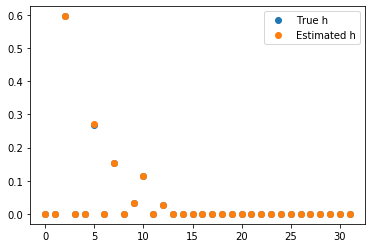

In [223]:
h_act, h_est = q2(N,L, zero_ind,trials)
plot_h(h_act,h_est)



 -----
 Question 3
 180 zero guard bands, each side



Trial 85 error 0.9051507362095682:  16%|█▌        | 81/500 [00:01<00:07, 54.70it/s]


Trial 167 error 1.1955234523133778:  33%|███▎      | 163/500 [00:03<00:05, 57.65it/s]


Trial 249 error 0.9154641099069545:  49%|████▉     | 247/500 [00:04<00:04, 54.27it/s]


Trial 332 error 0.8226722597707746:  65%|██████▌   | 325/500 [00:06<00:03, 57.57it/s]


Trial 414 error 0.823308274853426:  83%|████████▎ | 414/500 [00:07<00:01, 63.72it/s]


Trial 498 error 0.661558336789062:  98%|█████████▊| 492/500 [00:08<00:00, 64.74it/s] 


Trial 500 error 0.8765997765726272: 100%|██████████| 500/500 [00:08<00:00, 57.14it/s]


h actual [[ 3.49066430e-01+4.95524761e-01j]
 [-9.91878305e-01-9.55311954e-02j]
 [ 1.32608290e-01+7.47689098e-02j]
 [-5.62054695e-02+1.98607745e-01j]
 [ 1.04878320e-01+2.63777409e-03j]
 [ 3.72406920e-02+8.73572721e-02j]
 [ 1.81506929e-01-4.54046661e-02j]
 [ 2.44452937e-02+6.60529718e-02j]
 [-1.94204191e-01+4.36930840e-02j]
 [ 1.09337089e-01-2.83370654e-02j]
 [-6.30607095e-02+1.36443859e-02j]
 [ 2.39056764e-02-1.27875431e-02j]
 [ 2.97161783e-02+6.55167097e-03j]
 [ 2.24809087e-03+1.03764389e-02j]
 [ 4.54076280e-03+9.97395256e-03j]
 [-5.01448182e-03-8.61653747e-03j]
 [ 1.08776281e-02+1.72294748e-02j]
 [ 1.17904406e-02-1.30523436e-02j]
 [-1.66785404e-03+1.62397701e-02j]
 [-2.54984699e-03+5.99578925e-03j]
 [ 3.98466129e-03+8.20136614e-03j]
 [ 9.98182998e-03+3.39430352e-03j]
 [ 4.48437255e-04-5.98235710e-04j]
 [ 8.82906476e-03-7.83291166e-05j]
 [ 3.76668075e-03+4.00200992e-04j]
 [-2.84173465e-03-2.01218960e-03j]
 [-1.06641817e-03-2.21124115e-03j]
 [ 1.44632698e-03+1.90530589e-05j]
 [-1.634319

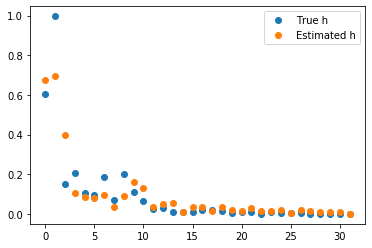



 -----
 Question 3
 180 zero guard bands, each side



Trial 86 error 1.0077755790500638:  16%|█▌        | 81/500 [00:01<00:07, 59.58it/s]


Trial 169 error 1.2153308291372136:  34%|███▎      | 168/500 [00:02<00:05, 59.74it/s]


Trial 252 error 1.3780366802968953:  50%|█████     | 251/500 [00:04<00:04, 60.75it/s]


Trial 336 error 1.2619543710949792:  67%|██████▋   | 333/500 [00:05<00:02, 61.95it/s]


Trial 420 error 1.446862414421346:  83%|████████▎ | 414/500 [00:06<00:01, 64.82it/s] 


Trial 500 error 1.854858671604434: 100%|██████████| 500/500 [00:07<00:00, 63.14it/s]


h actual [[-3.78379074e-01-2.13697503e-01j]
 [ 4.53203038e-01+1.63726088e-01j]
 [ 2.33799716e-01-1.10844127e+00j]
 [-4.94454169e-02+4.97995560e-02j]
 [-1.38954670e-02+1.28943328e-01j]
 [-7.08855205e-02+7.00955739e-02j]
 [ 2.42544026e-01+1.32059890e-01j]
 [-2.27963552e-02+1.57046527e-01j]
 [-6.99874400e-02+5.92477013e-02j]
 [-1.72059116e-02+5.38261569e-02j]
 [-6.96092835e-02+4.40765736e-03j]
 [-2.23227113e-02-1.44922412e-02j]
 [ 3.69762120e-03+2.72638564e-02j]
 [-1.26001275e-02+1.67088481e-02j]
 [ 5.88532255e-02+1.38267771e-02j]
 [-2.70416695e-03-2.17694767e-03j]
 [-2.34751572e-03+1.28804217e-02j]
 [ 2.29591967e-02-1.10391918e-02j]
 [-1.41196424e-03-9.39504886e-03j]
 [ 8.49299725e-04-1.45780252e-02j]
 [ 3.11787061e-03-5.27193369e-03j]
 [ 3.67424159e-04-3.02984533e-03j]
 [ 1.04517320e-03-2.62698801e-03j]
 [ 3.24731621e-03-2.16810253e-03j]
 [-9.31320128e-03-8.42786053e-03j]
 [-2.68912891e-04-8.67979849e-04j]
 [-4.83960491e-04-4.22339268e-05j]
 [ 3.88078086e-04-2.75462470e-04j]
 [ 1.192540

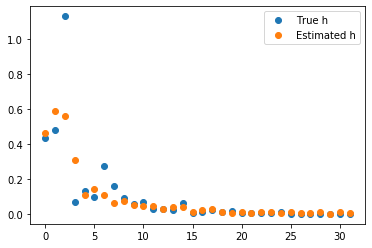



 -----
 Question 3
 180 zero guard bands, each side



Trial 86 error 1.9406435093600132:  17%|█▋        | 84/500 [00:01<00:06, 61.74it/s]


Trial 170 error 1.7601144737599146:  33%|███▎      | 166/500 [00:02<00:04, 68.43it/s]


Trial 253 error 1.3066400420656166:  50%|█████     | 251/500 [00:03<00:03, 63.61it/s]


Trial 337 error 3.9043746136920685:  66%|██████▋   | 332/500 [00:05<00:02, 64.41it/s]


Trial 420 error 3.4604958404077224:  83%|████████▎ | 417/500 [00:06<00:01, 65.76it/s]


Trial 500 error 1.901132754629687: 100%|██████████| 500/500 [00:07<00:00, 64.19it/s]


h actual [[-7.69625845e-01+2.51316163e-01j]
 [ 2.42245291e-01-4.65932962e-02j]
 [-5.99797630e-01+1.92059244e-01j]
 [ 1.72257815e-01+1.31394486e-01j]
 [ 2.75130434e-01+9.80575011e-02j]
 [-8.49501779e-02+3.07877626e-01j]
 [ 1.17867517e-02+1.02270112e-02j]
 [-2.79793130e-02-2.90163318e-02j]
 [ 9.11163894e-02-4.15953713e-02j]
 [-5.89603845e-02+5.80090738e-02j]
 [-4.82571582e-04-7.26353732e-03j]
 [-1.01719174e-02-9.41375324e-03j]
 [ 5.63742801e-02-2.35425020e-02j]
 [ 5.64116897e-04-4.06455510e-02j]
 [-1.40657075e-02+2.91800937e-02j]
 [ 1.27104573e-02-2.48260245e-02j]
 [-1.14060859e-02-5.66160515e-03j]
 [-2.67455008e-03+4.80646562e-03j]
 [ 2.19913886e-03+7.99502955e-03j]
 [ 9.82889828e-03-8.08436891e-04j]
 [-5.01591587e-03-1.20448922e-02j]
 [ 1.42272926e-03+8.46640755e-03j]
 [ 1.36957560e-03-6.89864992e-03j]
 [-2.76213802e-03-6.65416815e-03j]
 [ 2.21957500e-03+3.28009974e-03j]
 [-1.50487639e-03-3.72835588e-03j]
 [ 3.16465481e-03+1.60186913e-03j]
 [-1.96147895e-03-1.20853455e-03j]
 [-1.125080

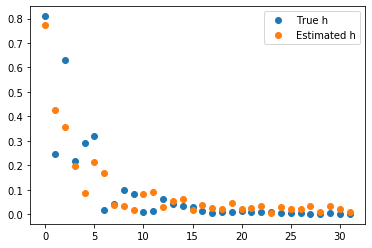



 -----
 Question 3
 180 zero guard bands, each side



Trial 86 error 2.819606195526302:  17%|█▋        | 84/500 [00:01<00:06, 65.32it/s]


Trial 169 error 3.2565866061355906:  34%|███▍      | 169/500 [00:02<00:05, 59.88it/s]


Trial 253 error 2.5596978174680367:  50%|████▉     | 248/500 [00:04<00:03, 67.49it/s]


Trial 337 error 1.2393293745473017:  66%|██████▌   | 330/500 [00:05<00:02, 65.07it/s]


Trial 420 error 2.7652377918877913:  83%|████████▎ | 416/500 [00:06<00:01, 64.16it/s]


Trial 500 error 3.1773834176246: 100%|██████████| 500/500 [00:07<00:00, 63.28it/s]   


h actual [[-6.69784346e-01-4.45670895e-02j]
 [ 1.26303537e-02-3.57948163e-01j]
 [-3.72543137e-01-1.71491057e-01j]
 [-3.16064294e-01-3.28814667e-01j]
 [-2.85262517e-01+2.30037570e-02j]
 [-1.49693114e-03+1.15647327e-01j]
 [ 4.72718009e-02-1.53418689e-01j]
 [ 2.54860192e-02-5.47053642e-02j]
 [-2.70825650e-01+9.27075604e-02j]
 [ 2.75521994e-03-4.90124384e-02j]
 [ 8.95255371e-03+4.21060073e-02j]
 [ 6.21347262e-02+5.54054671e-02j]
 [ 6.04491859e-02+9.57690507e-03j]
 [ 8.32956492e-03+5.67584353e-03j]
 [-3.60843178e-02+1.57511151e-02j]
 [-1.30863831e-02+4.74134513e-02j]
 [ 3.03651228e-02+5.84579875e-03j]
 [ 4.59679981e-03+9.91914864e-03j]
 [-2.02820841e-02+5.63561799e-04j]
 [ 1.06339451e-02-1.63355774e-02j]
 [ 1.27783748e-03+4.40535596e-03j]
 [-9.71623825e-03+2.44624540e-03j]
 [ 5.59012732e-03+5.27776015e-03j]
 [ 3.74368196e-03-2.69240966e-03j]
 [-1.05313754e-02+4.39669400e-03j]
 [-8.65559461e-04-1.63237891e-03j]
 [ 3.04484649e-03-2.37430409e-03j]
 [-4.20232254e-04+5.29728256e-06j]
 [-1.210082

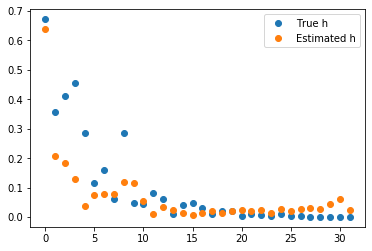



 -----
 Question 3
 180 zero guard bands, each side



Trial 86 error 9.920408582460272:  17%|█▋        | 86/500 [00:01<00:06, 63.06it/s]


Trial 171 error 7.0902147378815625:  33%|███▎      | 166/500 [00:02<00:05, 62.67it/s]


Trial 254 error 4.265817814125227:  51%|█████     | 253/500 [00:03<00:03, 64.47it/s] 


Trial 338 error 7.593481787754947:  66%|██████▌   | 331/500 [00:05<00:02, 63.14it/s] 


Trial 422 error 6.585774715309455:  83%|████████▎ | 415/500 [00:06<00:01, 58.76it/s]


Trial 500 error 7.213215166490758: 100%|██████████| 500/500 [00:07<00:00, 63.38it/s]


h actual [[ 4.40723023e-02-2.36958891e-01j]
 [-2.64240070e-01-3.04868704e-01j]
 [-5.44537535e-02-1.76836632e-02j]
 [-6.94568137e-02-1.07472059e-02j]
 [ 1.44000368e-01+4.92720296e-02j]
 [ 3.21668563e-01+1.01078972e-01j]
 [ 1.58554831e-01-6.15745992e-02j]
 [ 1.48651014e-01+6.87201826e-02j]
 [ 1.42268610e-01+8.35699629e-02j]
 [ 6.03860137e-02+7.43878676e-02j]
 [-2.94391669e-04-3.77486234e-02j]
 [-4.89415249e-02+2.37257779e-02j]
 [ 5.28751332e-02-1.32365835e-02j]
 [-2.57098898e-02-2.39763119e-02j]
 [-4.27473182e-03+7.82709261e-03j]
 [-2.26821126e-02-3.41594561e-02j]
 [-8.18765785e-03+5.25975674e-03j]
 [ 7.28243144e-03+9.80050613e-03j]
 [-2.45144381e-02-1.35812628e-02j]
 [ 2.14720691e-03-1.83969912e-03j]
 [-8.70767832e-03-6.17374756e-03j]
 [ 4.65823002e-03+2.93479689e-03j]
 [ 1.00230513e-04+2.29858948e-03j]
 [ 2.25536691e-03-1.53265937e-03j]
 [ 3.51732742e-04-1.80898191e-03j]
 [ 6.49320040e-03+6.87492451e-03j]
 [ 1.25478571e-03-2.75194426e-03j]
 [-1.22894583e-03+1.70850878e-03j]
 [-2.691107

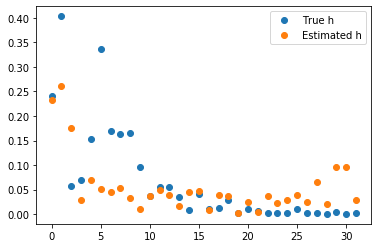



 -----
 Question 3
 180 zero guard bands, each side



Trial 86 error 12.75596452768008:  16%|█▋        | 82/500 [00:01<00:07, 59.10it/s]


Trial 168 error 7.20839449692482:  34%|███▎      | 168/500 [00:03<00:07, 45.41it/s]


Trial 250 error 7.146863784374126:  50%|█████     | 250/500 [00:04<00:04, 58.57it/s]


Trial 333 error 6.080079652071866:  66%|██████▌   | 330/500 [00:05<00:02, 63.81it/s]


Trial 416 error 10.287558599782843:  83%|████████▎ | 414/500 [00:07<00:01, 64.70it/s]


Trial 499 error 8.375523905471148: 100%|█████████▉| 498/500 [00:08<00:00, 59.99it/s] 


Trial 500 error 6.728673225025545: 100%|██████████| 500/500 [00:08<00:00, 57.92it/s]


h actual [[-2.32199899e-01-6.71271545e-02j]
 [ 8.59946555e-02+1.65711692e-01j]
 [ 2.18817485e-01-2.42433623e-01j]
 [-1.84717489e-01+3.74818148e-03j]
 [-8.18760765e-03-1.17811952e-01j]
 [-5.77121190e-02+8.95541861e-02j]
 [-1.47577715e-02+2.02428205e-01j]
 [ 2.42693128e-02-1.06429107e-01j]
 [-3.37641091e-02-5.86819397e-02j]
 [ 9.34590527e-02-6.52539907e-02j]
 [-3.54551704e-02+3.01920687e-02j]
 [ 5.69202019e-02+1.50966905e-02j]
 [-8.90039917e-02+2.83444027e-02j]
 [ 1.20651155e-02-2.60342022e-02j]
 [-3.73843602e-03-1.33733855e-02j]
 [-5.32809843e-04-1.71330700e-03j]
 [ 1.13966907e-03-2.87182422e-03j]
 [ 4.90195776e-04-5.83473188e-03j]
 [-7.10599458e-03-3.44028536e-03j]
 [ 8.32131782e-03+8.09554616e-03j]
 [ 2.61341738e-03+1.67013343e-03j]
 [-6.26739581e-03-2.68573719e-03j]
 [ 9.40837655e-04+1.15742328e-03j]
 [-9.73793270e-04+4.40304304e-03j]
 [-4.37459194e-03-5.91096512e-03j]
 [-4.26409421e-03+1.13449919e-03j]
 [ 3.92150160e-03-1.55951497e-03j]
 [ 2.76554534e-03-3.08998770e-03j]
 [ 2.841234

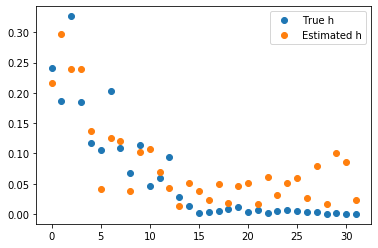

[0.8765997765726272, 1.854858671604434, 1.901132754629687, 3.1773834176246, 7.213215166490758, 6.728673225025545] [8.634073008943506, 8.64537706236569, 8.626915810499792, 8.643012822584264, 8.616043778618462, 8.624511792115714]


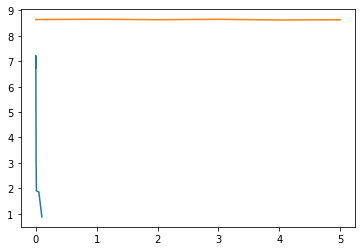

In [44]:
error_list=[]
mse_list=[]
reg=[0.1,0.05,0.01,0.005,0.001,0.0005]
for i in range(0,6):
    h_act, h_est,error,mse = q3(guard, N, L, reg[i],500)
    plot_h(h_act,h_est)
    error_list.append(error)
    mse_list.append(mse)
print(error_list,mse_list)
plt.plot(reg,error_list,mse_list)

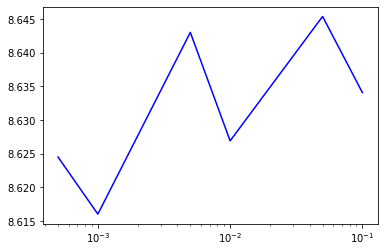

In [45]:
#plt.semilogx(reg,error_list,'r',reg,mse_list,'b')
plt.semilogx(reg,mse_list,'b')


In [47]:
F = get_F(N,L)
S=np.matmul(F.getH(),F)

AttributeError: 'numpy.ndarray' object has no attribute 'getH'

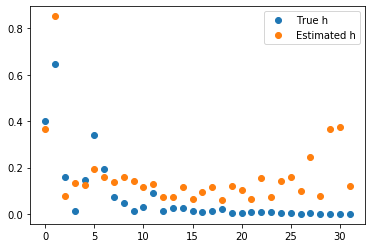

In [37]:
plot_h(h_act,h_est)



 -----
 Question 4
 LSE of constrained h_act for 10,000 trials


Trial 10000 error 0.06496036443134032: 100%|██████████| 10000/10000 [02:58<00:00, 55.94it/s]


h actual [[ 5.12117850e-02+0.0263205j ]
 [ 5.12117850e-02+0.0263205j ]
 [-3.46894766e-01-0.16691986j]
 [-3.46894766e-01-0.16691986j]
 [-1.96666747e-01+0.16473641j]
 [-1.96666747e-01+0.16473641j]
 [-1.57242745e-01-0.0344285j ]
 [-1.31797710e-01+0.00931658j]
 [ 3.37971454e-03+0.12539544j]
 [-1.22437814e-01+0.01961241j]
 [-1.03718642e-01+0.03998472j]
 [ 2.40466967e-02-0.03748659j]
 [-3.10842911e-02+0.03936434j]
 [-2.46263016e-02-0.00733779j]
 [ 3.01948589e-02-0.01520593j]
 [-1.99643398e-02+0.01153849j]
 [-6.15137077e-03+0.02405282j]
 [ 1.20288327e-02-0.02377306j]
 [-7.74915687e-03+0.02012653j]
 [ 1.10785165e-02-0.01063393j]
 [ 6.08802647e-03-0.00134755j]
 [-3.76827267e-03-0.00876415j]
 [-3.90377037e-03+0.00404542j]
 [-1.76241618e-03-0.00473227j]
 [-3.24754084e-03-0.0014888j ]
 [ 1.93444808e-03-0.00196521j]
 [ 2.96693461e-03+0.00579979j]
 [ 9.42726268e-04+0.00048019j]
 [-1.14845266e-03+0.00278638j]
 [ 1.41348473e-04+0.00131119j]
 [-4.79147353e-06+0.00053966j]
 [ 1.02658973e-03-0.00057413j]

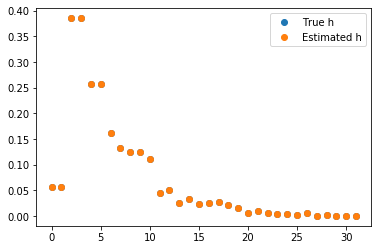

In [22]:
h_act, h_est = q4(N,L,eq_cons_ind,trials)
plot_h(h_act,h_est)



 -----
 Question 5
 LSE of sparse h_act for 10,000 trials





  0%|          | 0/10000 [00:00<?, ?it/s]


Trial 1 error 0.026697836799340482:   0%|          | 0/10000 [00:00<?, ?it/s]


Trial 2 error 0.02750057611974151:   0%|          | 0/10000 [00:00<?, ?it/s] 


Trial 2 error 0.02750057611974151:   0%|          | 2/10000 [00:00<11:33, 14.42it/s]


Trial 3 error 0.029501913360057686:   0%|          | 2/10000 [00:00<11:33, 14.42it/s]


Trial 4 error 0.029122696703915034:   0%|          | 2/10000 [00:00<11:33, 14.42it/s]


Trial 4 error 0.029122696703915034:   0%|          | 4/10000 [00:00<10:57, 15.21it/s]


Trial 5 error 0.03161070110147169:   0%|          | 4/10000 [00:00<10:57, 15.21it/s] 


Trial 6 error 0.034042105028043425:   0%|          | 4/10000 [00:00<10:57, 15.21it/s]


Trial 6 error 0.034042105028043425:   0%|          | 6/10000 [00:00<10:59, 15.16it/s]


Trial 7 error 0.03471834438215769:   0%|          | 6/10000 [00:00<10:59, 15.16it/s] 


Trial 8 error 0.03483034822812501:   0%|          | 6/10000 [00:00<10:59, 15.16it/s]


Tri

Trial 122 error 0.03681172661527742:   1%|          | 121/10000 [00:07<08:58, 18.36it/s]


Trial 123 error 0.03673578873686937:   1%|          | 121/10000 [00:07<08:58, 18.36it/s]


Trial 124 error 0.036726823043562305:   1%|          | 121/10000 [00:07<08:58, 18.36it/s]


Trial 124 error 0.036726823043562305:   1%|          | 124/10000 [00:07<08:39, 19.00it/s]


Trial 125 error 0.03671088710985819:   1%|          | 124/10000 [00:07<08:39, 19.00it/s] 


Trial 126 error 0.03674424482297596:   1%|          | 124/10000 [00:07<08:39, 19.00it/s]


Trial 126 error 0.03674424482297596:   1%|▏         | 126/10000 [00:07<08:34, 19.18it/s]


Trial 127 error 0.03676876122373514:   1%|▏         | 126/10000 [00:07<08:34, 19.18it/s]


Trial 128 error 0.03671308469983025:   1%|▏         | 126/10000 [00:07<08:34, 19.18it/s]


Trial 128 error 0.03671308469983025:   1%|▏         | 128/10000 [00:07<08:34, 19.19it/s]


Trial 129 error 0.03674355531361049:   1%|▏         | 128/10000 [00:07<08:34, 19.19it/s

Trial 241 error 0.036729201005498445:   2%|▏         | 240/10000 [00:14<09:46, 16.65it/s]


Trial 242 error 0.036727250076535774:   2%|▏         | 240/10000 [00:14<09:46, 16.65it/s]


Trial 242 error 0.036727250076535774:   2%|▏         | 242/10000 [00:14<09:39, 16.84it/s]


Trial 243 error 0.036735432840446794:   2%|▏         | 242/10000 [00:14<09:39, 16.84it/s]


Trial 244 error 0.03668650451068429:   2%|▏         | 242/10000 [00:14<09:39, 16.84it/s] 


Trial 244 error 0.03668650451068429:   2%|▏         | 244/10000 [00:14<09:34, 16.99it/s]


Trial 245 error 0.036629901156650324:   2%|▏         | 244/10000 [00:14<09:34, 16.99it/s]


Trial 246 error 0.036655326483330336:   2%|▏         | 244/10000 [00:14<09:34, 16.99it/s]


Trial 246 error 0.036655326483330336:   2%|▏         | 246/10000 [00:14<09:29, 17.12it/s]


Trial 247 error 0.03660205293172745:   2%|▏         | 246/10000 [00:14<09:29, 17.12it/s] 


Trial 248 error 0.0366425848637311:   2%|▏         | 246/10000 [00:14<09:29, 17.1

Trial 360 error 0.03689762271190981:   4%|▎         | 358/10000 [00:21<09:56, 16.17it/s]


Trial 360 error 0.03689762271190981:   4%|▎         | 360/10000 [00:21<09:37, 16.69it/s]


Trial 361 error 0.03687996164801332:   4%|▎         | 360/10000 [00:21<09:37, 16.69it/s]


Trial 362 error 0.03691161748700669:   4%|▎         | 360/10000 [00:21<09:37, 16.69it/s]


Trial 362 error 0.03691161748700669:   4%|▎         | 362/10000 [00:21<09:35, 16.76it/s]


Trial 363 error 0.03690319254121717:   4%|▎         | 362/10000 [00:21<09:35, 16.76it/s]


Trial 364 error 0.036904683162085034:   4%|▎         | 362/10000 [00:21<09:35, 16.76it/s]


Trial 364 error 0.036904683162085034:   4%|▎         | 364/10000 [00:21<09:30, 16.90it/s]


Trial 365 error 0.03691219324404903:   4%|▎         | 364/10000 [00:21<09:30, 16.90it/s] 


Trial 366 error 0.0369099590326954:   4%|▎         | 364/10000 [00:21<09:30, 16.90it/s] 


Trial 366 error 0.0369099590326954:   4%|▎         | 366/10000 [00:21<09:36, 16.71it/s]

Trial 478 error 0.03696692946037862:   5%|▍         | 478/10000 [00:28<08:56, 17.75it/s]


Trial 479 error 0.03696828577559934:   5%|▍         | 478/10000 [00:28<08:56, 17.75it/s]


Trial 480 error 0.0369812870238345:   5%|▍         | 478/10000 [00:28<08:56, 17.75it/s] 


Trial 480 error 0.0369812870238345:   5%|▍         | 480/10000 [00:28<09:40, 16.40it/s]


Trial 481 error 0.03699297327931833:   5%|▍         | 480/10000 [00:28<09:40, 16.40it/s]


Trial 482 error 0.03698472068287521:   5%|▍         | 480/10000 [00:28<09:40, 16.40it/s]


Trial 482 error 0.03698472068287521:   5%|▍         | 482/10000 [00:28<09:28, 16.74it/s]


Trial 483 error 0.0369772394836809:   5%|▍         | 482/10000 [00:28<09:28, 16.74it/s] 


Trial 484 error 0.036974722219346876:   5%|▍         | 482/10000 [00:28<09:28, 16.74it/s]


Trial 484 error 0.036974722219346876:   5%|▍         | 484/10000 [00:28<09:15, 17.12it/s]


Trial 485 error 0.03699158184049327:   5%|▍         | 484/10000 [00:28<09:15, 17.12it/s] 

Trial 597 error 0.03693976280271886:   6%|▌         | 596/10000 [00:35<09:29, 16.51it/s]


Trial 598 error 0.03695685961760912:   6%|▌         | 596/10000 [00:35<09:29, 16.51it/s]


Trial 598 error 0.03695685961760912:   6%|▌         | 598/10000 [00:35<09:48, 15.96it/s]


Trial 599 error 0.03696856812660403:   6%|▌         | 598/10000 [00:35<09:48, 15.96it/s]


Trial 600 error 0.036975688127163016:   6%|▌         | 598/10000 [00:35<09:48, 15.96it/s]


Trial 600 error 0.036975688127163016:   6%|▌         | 600/10000 [00:35<09:25, 16.64it/s]


Trial 601 error 0.036963100376273435:   6%|▌         | 600/10000 [00:35<09:25, 16.64it/s]


Trial 602 error 0.03694579037106385:   6%|▌         | 600/10000 [00:35<09:25, 16.64it/s] 


Trial 602 error 0.03694579037106385:   6%|▌         | 602/10000 [00:35<09:12, 17.00it/s]


Trial 603 error 0.03695289215340726:   6%|▌         | 602/10000 [00:35<09:12, 17.00it/s]


Trial 604 error 0.03694381991270543:   6%|▌         | 602/10000 [00:35<09:12, 17.00it/

Trial 716 error 0.037043287199915044:   7%|▋         | 714/10000 [00:42<09:52, 15.68it/s]


Trial 716 error 0.037043287199915044:   7%|▋         | 716/10000 [00:42<09:38, 16.04it/s]


Trial 717 error 0.03706030050940442:   7%|▋         | 716/10000 [00:42<09:38, 16.04it/s] 


Trial 718 error 0.03706886394357804:   7%|▋         | 716/10000 [00:43<09:38, 16.04it/s]


Trial 718 error 0.03706886394357804:   7%|▋         | 718/10000 [00:43<09:46, 15.82it/s]


Trial 719 error 0.03704612377159219:   7%|▋         | 718/10000 [00:43<09:46, 15.82it/s]


Trial 720 error 0.03705352756756661:   7%|▋         | 718/10000 [00:43<09:46, 15.82it/s]


Trial 720 error 0.03705352756756661:   7%|▋         | 720/10000 [00:43<10:48, 14.31it/s]


Trial 721 error 0.03706573560367913:   7%|▋         | 720/10000 [00:43<10:48, 14.31it/s]


Trial 722 error 0.03706115598977955:   7%|▋         | 720/10000 [00:43<10:48, 14.31it/s]


Trial 722 error 0.03706115598977955:   7%|▋         | 722/10000 [00:43<11:20, 13.64it/s

Trial 834 error 0.03706626045710401:   8%|▊         | 834/10000 [00:51<11:43, 13.03it/s]


Trial 835 error 0.03707243074663783:   8%|▊         | 834/10000 [00:51<11:43, 13.03it/s]


Trial 836 error 0.03707077507718384:   8%|▊         | 834/10000 [00:51<11:43, 13.03it/s]


Trial 836 error 0.03707077507718384:   8%|▊         | 836/10000 [00:51<11:42, 13.05it/s]


Trial 837 error 0.03707592116737549:   8%|▊         | 836/10000 [00:51<11:42, 13.05it/s]


Trial 838 error 0.037055357887153174:   8%|▊         | 836/10000 [00:51<11:42, 13.05it/s]


Trial 838 error 0.037055357887153174:   8%|▊         | 838/10000 [00:51<11:08, 13.71it/s]


Trial 839 error 0.03705551238015792:   8%|▊         | 838/10000 [00:52<11:08, 13.71it/s] 


Trial 840 error 0.03706451455161409:   8%|▊         | 838/10000 [00:52<11:08, 13.71it/s]


Trial 840 error 0.03706451455161409:   8%|▊         | 840/10000 [00:52<10:20, 14.77it/s]


Trial 841 error 0.03706951473915973:   8%|▊         | 840/10000 [00:52<10:20, 14.77it/s

Trial 953 error 0.03700351157329483:  10%|▉         | 952/10000 [00:59<09:17, 16.23it/s]


Trial 954 error 0.03701148816848802:  10%|▉         | 952/10000 [00:59<09:17, 16.23it/s]


Trial 954 error 0.03701148816848802:  10%|▉         | 954/10000 [00:59<09:17, 16.24it/s]


Trial 955 error 0.037020040247967984:  10%|▉         | 954/10000 [00:59<09:17, 16.24it/s]


Trial 956 error 0.03701658407113741:  10%|▉         | 954/10000 [00:59<09:17, 16.24it/s] 


Trial 956 error 0.03701658407113741:  10%|▉         | 956/10000 [00:59<09:23, 16.05it/s]


Trial 957 error 0.03702281286356708:  10%|▉         | 956/10000 [00:59<09:23, 16.05it/s]


Trial 958 error 0.037029330229346936:  10%|▉         | 956/10000 [00:59<09:23, 16.05it/s]


Trial 958 error 0.037029330229346936:  10%|▉         | 958/10000 [00:59<09:14, 16.31it/s]


Trial 959 error 0.03703077853715392:  10%|▉         | 958/10000 [00:59<09:14, 16.31it/s] 


Trial 960 error 0.03703393953586833:  10%|▉         | 958/10000 [00:59<09:14, 16.31it

Trial 1070 error 0.03696895330424934:  11%|█         | 1070/10000 [01:07<09:17, 16.02it/s]


Trial 1071 error 0.036973362731588084:  11%|█         | 1070/10000 [01:07<09:17, 16.02it/s]


Trial 1072 error 0.03698442968221862:  11%|█         | 1070/10000 [01:07<09:17, 16.02it/s] 


Trial 1072 error 0.03698442968221862:  11%|█         | 1072/10000 [01:07<09:20, 15.94it/s]


Trial 1073 error 0.03698535206356696:  11%|█         | 1072/10000 [01:07<09:20, 15.94it/s]


Trial 1074 error 0.03698551572597181:  11%|█         | 1072/10000 [01:07<09:20, 15.94it/s]


Trial 1074 error 0.03698551572597181:  11%|█         | 1074/10000 [01:07<09:12, 16.15it/s]


Trial 1075 error 0.03698379752234583:  11%|█         | 1074/10000 [01:07<09:12, 16.15it/s]


Trial 1076 error 0.03698832172981:  11%|█         | 1074/10000 [01:07<09:12, 16.15it/s]   


Trial 1076 error 0.03698832172981:  11%|█         | 1076/10000 [01:07<09:03, 16.42it/s]


Trial 1077 error 0.03698634301475378:  11%|█         | 1076/10000 [01:0

Trial 1186 error 0.03701764992567562:  12%|█▏        | 1186/10000 [01:16<12:36, 11.65it/s]


Trial 1187 error 0.03701657067476022:  12%|█▏        | 1186/10000 [01:16<12:36, 11.65it/s]


Trial 1188 error 0.037011735403788514:  12%|█▏        | 1186/10000 [01:16<12:36, 11.65it/s]


Trial 1188 error 0.037011735403788514:  12%|█▏        | 1188/10000 [01:16<12:43, 11.54it/s]


Trial 1189 error 0.037005520434598975:  12%|█▏        | 1188/10000 [01:16<12:43, 11.54it/s]


Trial 1190 error 0.03700795651769559:  12%|█▏        | 1188/10000 [01:16<12:43, 11.54it/s] 


Trial 1190 error 0.03700795651769559:  12%|█▏        | 1190/10000 [01:16<12:49, 11.45it/s]


Trial 1191 error 0.037008080976175216:  12%|█▏        | 1190/10000 [01:16<12:49, 11.45it/s]


Trial 1192 error 0.03700097818219733:  12%|█▏        | 1190/10000 [01:16<12:49, 11.45it/s] 


Trial 1192 error 0.03700097818219733:  12%|█▏        | 1192/10000 [01:16<13:01, 11.27it/s]


Trial 1193 error 0.0369892797854017:  12%|█▏        | 1192/10000

Trial 1302 error 0.03700736482624433:  13%|█▎        | 1302/10000 [01:24<09:27, 15.32it/s]


Trial 1303 error 0.0370103257113892:  13%|█▎        | 1302/10000 [01:24<09:27, 15.32it/s] 


Trial 1304 error 0.037006449647976045:  13%|█▎        | 1302/10000 [01:24<09:27, 15.32it/s]


Trial 1304 error 0.037006449647976045:  13%|█▎        | 1304/10000 [01:24<09:10, 15.81it/s]


Trial 1305 error 0.037012492676718925:  13%|█▎        | 1304/10000 [01:24<09:10, 15.81it/s]


Trial 1306 error 0.03701395644531965:  13%|█▎        | 1304/10000 [01:25<09:10, 15.81it/s] 


Trial 1306 error 0.03701395644531965:  13%|█▎        | 1306/10000 [01:25<09:02, 16.03it/s]


Trial 1307 error 0.03701917457017081:  13%|█▎        | 1306/10000 [01:25<09:02, 16.03it/s]


Trial 1308 error 0.0370172203329025:  13%|█▎        | 1306/10000 [01:25<09:02, 16.03it/s] 


Trial 1308 error 0.0370172203329025:  13%|█▎        | 1308/10000 [01:25<08:50, 16.38it/s]


Trial 1309 error 0.03702232597168431:  13%|█▎        | 1308/10000 [

Trial 1418 error 0.037007746864226865:  14%|█▍        | 1418/10000 [01:33<13:15, 10.79it/s]


Trial 1419 error 0.036996910615570394:  14%|█▍        | 1418/10000 [01:33<13:15, 10.79it/s]


Trial 1420 error 0.036998842301023495:  14%|█▍        | 1418/10000 [01:33<13:15, 10.79it/s]


Trial 1420 error 0.036998842301023495:  14%|█▍        | 1420/10000 [01:33<12:25, 11.51it/s]


Trial 1421 error 0.03700270817022886:  14%|█▍        | 1420/10000 [01:33<12:25, 11.51it/s] 


Trial 1422 error 0.03700278615001518:  14%|█▍        | 1420/10000 [01:33<12:25, 11.51it/s]


Trial 1422 error 0.03700278615001518:  14%|█▍        | 1422/10000 [01:33<12:06, 11.81it/s]


Trial 1423 error 0.0370005434141897:  14%|█▍        | 1422/10000 [01:33<12:06, 11.81it/s] 


Trial 1424 error 0.03698509567947818:  14%|█▍        | 1422/10000 [01:33<12:06, 11.81it/s]


Trial 1424 error 0.03698509567947818:  14%|█▍        | 1424/10000 [01:33<12:32, 11.39it/s]


Trial 1425 error 0.03698783011552077:  14%|█▍        | 1424/10000

Trial 1534 error 0.03695725035985:  15%|█▌        | 1534/10000 [01:41<08:07, 17.37it/s]


Trial 1535 error 0.036957161810704006:  15%|█▌        | 1534/10000 [01:41<08:07, 17.37it/s]


Trial 1536 error 0.03696018918508527:  15%|█▌        | 1534/10000 [01:41<08:07, 17.37it/s] 


Trial 1536 error 0.03696018918508527:  15%|█▌        | 1536/10000 [01:41<08:14, 17.11it/s]


Trial 1537 error 0.03695890625600103:  15%|█▌        | 1536/10000 [01:41<08:14, 17.11it/s]


Trial 1538 error 0.036957300112081246:  15%|█▌        | 1536/10000 [01:41<08:14, 17.11it/s]


Trial 1538 error 0.036957300112081246:  15%|█▌        | 1538/10000 [01:41<08:10, 17.24it/s]


Trial 1539 error 0.03695971992922343:  15%|█▌        | 1538/10000 [01:41<08:10, 17.24it/s] 


Trial 1540 error 0.036960343395293624:  15%|█▌        | 1538/10000 [01:41<08:10, 17.24it/s]


Trial 1540 error 0.036960343395293624:  15%|█▌        | 1540/10000 [01:41<08:14, 17.11it/s]


Trial 1541 error 0.03695640082723863:  15%|█▌        | 1540/10000 

Trial 1650 error 0.03695757442703854:  16%|█▋        | 1650/10000 [01:50<13:09, 10.57it/s]


Trial 1651 error 0.03695797252824403:  16%|█▋        | 1650/10000 [01:50<13:09, 10.57it/s]


Trial 1652 error 0.036952251583120474:  16%|█▋        | 1650/10000 [01:50<13:09, 10.57it/s]


Trial 1652 error 0.036952251583120474:  17%|█▋        | 1652/10000 [01:50<13:23, 10.39it/s]


Trial 1653 error 0.03695316235684057:  17%|█▋        | 1652/10000 [01:50<13:23, 10.39it/s] 


Trial 1654 error 0.036952509920682705:  17%|█▋        | 1652/10000 [01:50<13:23, 10.39it/s]


Trial 1654 error 0.036952509920682705:  17%|█▋        | 1654/10000 [01:50<13:18, 10.45it/s]


Trial 1655 error 0.03695298466224967:  17%|█▋        | 1654/10000 [01:50<13:18, 10.45it/s] 


Trial 1656 error 0.036948179560478224:  17%|█▋        | 1654/10000 [01:50<13:18, 10.45it/s]


Trial 1656 error 0.036948179560478224:  17%|█▋        | 1656/10000 [01:50<12:50, 10.82it/s]


Trial 1657 error 0.03694782270892204:  17%|█▋        | 1656/10

Trial 1766 error 0.036875586232207554:  18%|█▊        | 1766/10000 [01:59<08:39, 15.84it/s]


Trial 1767 error 0.03687849352299698:  18%|█▊        | 1766/10000 [02:00<08:39, 15.84it/s] 


Trial 1768 error 0.03689029021779007:  18%|█▊        | 1766/10000 [02:00<08:39, 15.84it/s]


Trial 1768 error 0.03689029021779007:  18%|█▊        | 1768/10000 [02:00<08:20, 16.46it/s]


Trial 1769 error 0.03689035329204745:  18%|█▊        | 1768/10000 [02:00<08:20, 16.46it/s]


Trial 1770 error 0.03688569620748599:  18%|█▊        | 1768/10000 [02:00<08:20, 16.46it/s]


Trial 1770 error 0.03688569620748599:  18%|█▊        | 1770/10000 [02:00<08:20, 16.46it/s]


Trial 1771 error 0.03688315073578747:  18%|█▊        | 1770/10000 [02:00<08:20, 16.46it/s]


Trial 1772 error 0.03688318250805042:  18%|█▊        | 1770/10000 [02:00<08:20, 16.46it/s]


Trial 1772 error 0.03688318250805042:  18%|█▊        | 1772/10000 [02:00<08:54, 15.41it/s]


Trial 1773 error 0.03688873917385468:  18%|█▊        | 1772/10000 [0

Trial 1882 error 0.03692030552940963:  19%|█▉        | 1882/10000 [02:07<07:41, 17.59it/s]


Trial 1883 error 0.036919023054209375:  19%|█▉        | 1882/10000 [02:07<07:41, 17.59it/s]


Trial 1884 error 0.03691125254300419:  19%|█▉        | 1882/10000 [02:07<07:41, 17.59it/s] 


Trial 1884 error 0.03691125254300419:  19%|█▉        | 1884/10000 [02:07<08:02, 16.83it/s]


Trial 1885 error 0.03690863668457206:  19%|█▉        | 1884/10000 [02:07<08:02, 16.83it/s]


Trial 1886 error 0.036911214187830624:  19%|█▉        | 1884/10000 [02:07<08:02, 16.83it/s]


Trial 1886 error 0.036911214187830624:  19%|█▉        | 1886/10000 [02:07<08:17, 16.32it/s]


Trial 1887 error 0.03691242574918377:  19%|█▉        | 1886/10000 [02:07<08:17, 16.32it/s] 


Trial 1888 error 0.036912444175598046:  19%|█▉        | 1886/10000 [02:07<08:17, 16.32it/s]


Trial 1888 error 0.036912444175598046:  19%|█▉        | 1888/10000 [02:07<07:53, 17.14it/s]


Trial 1889 error 0.03691340818339327:  19%|█▉        | 1888/100

Trial 1998 error 0.03697144036959231:  20%|█▉        | 1998/10000 [02:13<07:28, 17.83it/s]


Trial 1999 error 0.036977265153622534:  20%|█▉        | 1998/10000 [02:13<07:28, 17.83it/s]


Trial 2000 error 0.036974193926290866:  20%|█▉        | 1998/10000 [02:13<07:28, 17.83it/s]


Trial 2000 error 0.036974193926290866:  20%|██        | 2000/10000 [02:13<07:48, 17.09it/s]


Trial 2001 error 0.03697433976398315:  20%|██        | 2000/10000 [02:13<07:48, 17.09it/s] 


Trial 2002 error 0.03697124004998883:  20%|██        | 2000/10000 [02:14<07:48, 17.09it/s]


Trial 2002 error 0.03697124004998883:  20%|██        | 2002/10000 [02:14<07:42, 17.28it/s]


Trial 2003 error 0.03697401086813102:  20%|██        | 2002/10000 [02:14<07:42, 17.28it/s]


Trial 2004 error 0.03698391859714091:  20%|██        | 2002/10000 [02:14<07:42, 17.28it/s]


Trial 2004 error 0.03698391859714091:  20%|██        | 2004/10000 [02:14<07:34, 17.59it/s]


Trial 2005 error 0.03698316254797787:  20%|██        | 2004/10000 

Trial 2114 error 0.03700492521570756:  21%|██        | 2114/10000 [02:20<08:04, 16.29it/s]


Trial 2115 error 0.03700196143848699:  21%|██        | 2114/10000 [02:20<08:04, 16.29it/s]


Trial 2116 error 0.036994674890177034:  21%|██        | 2114/10000 [02:20<08:04, 16.29it/s]


Trial 2116 error 0.036994674890177034:  21%|██        | 2116/10000 [02:20<07:58, 16.48it/s]


Trial 2117 error 0.036989202183362484:  21%|██        | 2116/10000 [02:20<07:58, 16.48it/s]


Trial 2118 error 0.0369824109842317:  21%|██        | 2116/10000 [02:21<07:58, 16.48it/s]  


Trial 2118 error 0.0369824109842317:  21%|██        | 2118/10000 [02:21<07:54, 16.62it/s]


Trial 2119 error 0.036982482889243565:  21%|██        | 2118/10000 [02:21<07:54, 16.62it/s]


Trial 2120 error 0.03698280690218008:  21%|██        | 2118/10000 [02:21<07:54, 16.62it/s] 


Trial 2120 error 0.03698280690218008:  21%|██        | 2120/10000 [02:21<07:49, 16.80it/s]


Trial 2121 error 0.036983188458460735:  21%|██        | 2120/1000

Trial 2230 error 0.03702407717072311:  22%|██▏       | 2230/10000 [02:27<07:23, 17.52it/s]


Trial 2231 error 0.0370242597968356:  22%|██▏       | 2230/10000 [02:27<07:23, 17.52it/s] 


Trial 2232 error 0.037020204914154975:  22%|██▏       | 2230/10000 [02:28<07:23, 17.52it/s]


Trial 2232 error 0.037020204914154975:  22%|██▏       | 2232/10000 [02:28<07:36, 17.01it/s]


Trial 2233 error 0.037017865167259266:  22%|██▏       | 2232/10000 [02:28<07:36, 17.01it/s]


Trial 2234 error 0.037018302065906734:  22%|██▏       | 2232/10000 [02:28<07:36, 17.01it/s]


Trial 2234 error 0.037018302065906734:  22%|██▏       | 2234/10000 [02:28<07:50, 16.50it/s]


Trial 2235 error 0.03702062083686264:  22%|██▏       | 2234/10000 [02:28<07:50, 16.50it/s] 


Trial 2236 error 0.03701799307055676:  22%|██▏       | 2234/10000 [02:28<07:50, 16.50it/s]


Trial 2236 error 0.03701799307055676:  22%|██▏       | 2236/10000 [02:28<07:40, 16.86it/s]


Trial 2237 error 0.03701895573432371:  22%|██▏       | 2236/1000

Trial 2346 error 0.0370788037199023:  23%|██▎       | 2346/10000 [02:34<07:41, 16.59it/s]


Trial 2347 error 0.037079092712153566:  23%|██▎       | 2346/10000 [02:34<07:41, 16.59it/s]


Trial 2348 error 0.03707677650964819:  23%|██▎       | 2346/10000 [02:34<07:41, 16.59it/s] 


Trial 2348 error 0.03707677650964819:  23%|██▎       | 2348/10000 [02:34<07:48, 16.32it/s]


Trial 2349 error 0.03707745888144414:  23%|██▎       | 2348/10000 [02:34<07:48, 16.32it/s]


Trial 2350 error 0.037075393631892606:  23%|██▎       | 2348/10000 [02:34<07:48, 16.32it/s]


Trial 2350 error 0.037075393631892606:  24%|██▎       | 2350/10000 [02:34<07:38, 16.67it/s]


Trial 2351 error 0.037073053415934636:  24%|██▎       | 2350/10000 [02:35<07:38, 16.67it/s]


Trial 2352 error 0.03707286231570789:  24%|██▎       | 2350/10000 [02:35<07:38, 16.67it/s] 


Trial 2352 error 0.03707286231570789:  24%|██▎       | 2352/10000 [02:35<07:43, 16.50it/s]


Trial 2353 error 0.03706925961639224:  24%|██▎       | 2352/10000

Trial 2462 error 0.03704851578089958:  25%|██▍       | 2462/10000 [02:41<07:04, 17.76it/s]


Trial 2463 error 0.0370471777091292:  25%|██▍       | 2462/10000 [02:41<07:04, 17.76it/s] 


Trial 2464 error 0.03705116687380222:  25%|██▍       | 2462/10000 [02:41<07:04, 17.76it/s]


Trial 2464 error 0.03705116687380222:  25%|██▍       | 2464/10000 [02:41<07:17, 17.22it/s]


Trial 2465 error 0.037049076329505375:  25%|██▍       | 2464/10000 [02:41<07:17, 17.22it/s]


Trial 2466 error 0.03704974650275251:  25%|██▍       | 2464/10000 [02:41<07:17, 17.22it/s] 


Trial 2466 error 0.03704974650275251:  25%|██▍       | 2466/10000 [02:41<07:26, 16.88it/s]


Trial 2467 error 0.037047718533601885:  25%|██▍       | 2466/10000 [02:41<07:26, 16.88it/s]


Trial 2468 error 0.03704869042506265:  25%|██▍       | 2466/10000 [02:41<07:26, 16.88it/s] 


Trial 2468 error 0.03704869042506265:  25%|██▍       | 2468/10000 [02:41<07:18, 17.17it/s]


Trial 2469 error 0.03705352342128729:  25%|██▍       | 2468/10000 

Trial 2578 error 0.037058915031173485:  26%|██▌       | 2578/10000 [02:48<07:24, 16.70it/s]


Trial 2579 error 0.03705833933191458:  26%|██▌       | 2578/10000 [02:48<07:24, 16.70it/s] 


Trial 2580 error 0.03705791795232887:  26%|██▌       | 2578/10000 [02:48<07:24, 16.70it/s]


Trial 2580 error 0.03705791795232887:  26%|██▌       | 2580/10000 [02:48<07:24, 16.70it/s]


Trial 2581 error 0.03705535354784778:  26%|██▌       | 2580/10000 [02:48<07:24, 16.70it/s]


Trial 2582 error 0.03705564269525555:  26%|██▌       | 2580/10000 [02:48<07:24, 16.70it/s]


Trial 2582 error 0.03705564269525555:  26%|██▌       | 2582/10000 [02:48<07:22, 16.75it/s]


Trial 2583 error 0.03705562534389503:  26%|██▌       | 2582/10000 [02:48<07:22, 16.75it/s]


Trial 2584 error 0.03705050424429484:  26%|██▌       | 2582/10000 [02:48<07:22, 16.75it/s]


Trial 2584 error 0.03705050424429484:  26%|██▌       | 2584/10000 [02:48<07:35, 16.27it/s]


Trial 2585 error 0.03705109379942171:  26%|██▌       | 2584/10000 [0

Trial 2694 error 0.03701586826720647:  27%|██▋       | 2694/10000 [02:55<07:35, 16.04it/s]


Trial 2695 error 0.037017292289666846:  27%|██▋       | 2694/10000 [02:55<07:35, 16.04it/s]


Trial 2696 error 0.03702754931017949:  27%|██▋       | 2694/10000 [02:55<07:35, 16.04it/s] 


Trial 2696 error 0.03702754931017949:  27%|██▋       | 2696/10000 [02:55<07:25, 16.39it/s]


Trial 2697 error 0.03702384666439539:  27%|██▋       | 2696/10000 [02:55<07:25, 16.39it/s]


Trial 2698 error 0.03702605496374413:  27%|██▋       | 2696/10000 [02:55<07:25, 16.39it/s]


Trial 2698 error 0.03702605496374413:  27%|██▋       | 2698/10000 [02:55<07:27, 16.31it/s]


Trial 2699 error 0.03702216104048832:  27%|██▋       | 2698/10000 [02:55<07:27, 16.31it/s]


Trial 2700 error 0.03701908007060952:  27%|██▋       | 2698/10000 [02:55<07:27, 16.31it/s]


Trial 2700 error 0.03701908007060952:  27%|██▋       | 2700/10000 [02:55<07:09, 17.00it/s]


Trial 2701 error 0.037019538954324444:  27%|██▋       | 2700/10000 [

Trial 2810 error 0.0370255248824748:  28%|██▊       | 2810/10000 [03:01<06:56, 17.25it/s]


Trial 2811 error 0.03702622041346353:  28%|██▊       | 2810/10000 [03:02<06:56, 17.25it/s]


Trial 2812 error 0.03702659353606003:  28%|██▊       | 2810/10000 [03:02<06:56, 17.25it/s]


Trial 2812 error 0.03702659353606003:  28%|██▊       | 2812/10000 [03:02<06:55, 17.29it/s]


Trial 2813 error 0.037030340278196135:  28%|██▊       | 2812/10000 [03:02<06:55, 17.29it/s]


Trial 2814 error 0.037029866932060874:  28%|██▊       | 2812/10000 [03:02<06:55, 17.29it/s]


Trial 2814 error 0.037029866932060874:  28%|██▊       | 2814/10000 [03:02<06:55, 17.29it/s]


Trial 2815 error 0.03703146433493571:  28%|██▊       | 2814/10000 [03:02<06:55, 17.29it/s] 


Trial 2816 error 0.03703394053061545:  28%|██▊       | 2814/10000 [03:02<06:55, 17.29it/s]


Trial 2816 error 0.03703394053061545:  28%|██▊       | 2816/10000 [03:02<06:57, 17.23it/s]


Trial 2817 error 0.03703448667887558:  28%|██▊       | 2816/10000 [

Trial 2926 error 0.03707464958880974:  29%|██▉       | 2926/10000 [03:08<07:06, 16.60it/s]


Trial 2927 error 0.03707507123693437:  29%|██▉       | 2926/10000 [03:08<07:06, 16.60it/s]


Trial 2928 error 0.037081635573586125:  29%|██▉       | 2926/10000 [03:08<07:06, 16.60it/s]


Trial 2928 error 0.037081635573586125:  29%|██▉       | 2928/10000 [03:08<06:54, 17.05it/s]


Trial 2929 error 0.03708216561746689:  29%|██▉       | 2928/10000 [03:09<06:54, 17.05it/s] 


Trial 2930 error 0.03707940477626665:  29%|██▉       | 2928/10000 [03:09<06:54, 17.05it/s]


Trial 2930 error 0.03707940477626665:  29%|██▉       | 2930/10000 [03:09<07:01, 16.76it/s]


Trial 2931 error 0.037079688998587046:  29%|██▉       | 2930/10000 [03:09<07:01, 16.76it/s]


Trial 2932 error 0.03708085223030098:  29%|██▉       | 2930/10000 [03:09<07:01, 16.76it/s] 


Trial 2932 error 0.03708085223030098:  29%|██▉       | 2932/10000 [03:09<06:54, 17.03it/s]


Trial 2933 error 0.03707967060548558:  29%|██▉       | 2932/10000

Trial 3042 error 0.03706832321208769:  30%|███       | 3042/10000 [03:15<06:25, 18.07it/s]


Trial 3043 error 0.03706841532504048:  30%|███       | 3042/10000 [03:15<06:25, 18.07it/s]


Trial 3044 error 0.03706678976303735:  30%|███       | 3042/10000 [03:15<06:25, 18.07it/s]


Trial 3044 error 0.03706678976303735:  30%|███       | 3044/10000 [03:15<06:24, 18.09it/s]


Trial 3045 error 0.0370658272794124:  30%|███       | 3044/10000 [03:15<06:24, 18.09it/s] 


Trial 3046 error 0.03706374133267619:  30%|███       | 3044/10000 [03:15<06:24, 18.09it/s]


Trial 3046 error 0.03706374133267619:  30%|███       | 3046/10000 [03:15<06:31, 17.74it/s]


Trial 3047 error 0.03706567271962089:  30%|███       | 3046/10000 [03:15<06:31, 17.74it/s]


Trial 3048 error 0.03706460706367444:  30%|███       | 3046/10000 [03:15<06:31, 17.74it/s]


Trial 3048 error 0.03706460706367444:  30%|███       | 3048/10000 [03:15<06:29, 17.84it/s]


Trial 3049 error 0.03706645399846777:  30%|███       | 3048/10000 [03:

Trial 3158 error 0.03701289979452009:  32%|███▏      | 3158/10000 [03:22<06:50, 16.67it/s]


Trial 3159 error 0.03700891412218373:  32%|███▏      | 3158/10000 [03:22<06:50, 16.67it/s]


Trial 3160 error 0.03700777146028952:  32%|███▏      | 3158/10000 [03:22<06:50, 16.67it/s]


Trial 3160 error 0.03700777146028952:  32%|███▏      | 3160/10000 [03:22<07:04, 16.12it/s]


Trial 3161 error 0.0370113147380872:  32%|███▏      | 3160/10000 [03:22<07:04, 16.12it/s] 


Trial 3162 error 0.037010312670552874:  32%|███▏      | 3160/10000 [03:22<07:04, 16.12it/s]


Trial 3162 error 0.037010312670552874:  32%|███▏      | 3162/10000 [03:22<07:12, 15.79it/s]


Trial 3163 error 0.03700986674710906:  32%|███▏      | 3162/10000 [03:22<07:12, 15.79it/s] 


Trial 3164 error 0.037008369060198054:  32%|███▏      | 3162/10000 [03:22<07:12, 15.79it/s]


Trial 3164 error 0.037008369060198054:  32%|███▏      | 3164/10000 [03:22<06:59, 16.29it/s]


Trial 3165 error 0.03700963070005552:  32%|███▏      | 3164/10000

Trial 3275 error 0.03702296496678193:  33%|███▎      | 3274/10000 [03:29<06:22, 17.60it/s]


Trial 3276 error 0.037020663105352986:  33%|███▎      | 3274/10000 [03:29<06:22, 17.60it/s]


Trial 3276 error 0.037020663105352986:  33%|███▎      | 3276/10000 [03:29<06:17, 17.80it/s]


Trial 3277 error 0.03701981195358168:  33%|███▎      | 3276/10000 [03:29<06:17, 17.80it/s] 


Trial 3278 error 0.03701832530433295:  33%|███▎      | 3276/10000 [03:29<06:17, 17.80it/s]


Trial 3278 error 0.03701832530433295:  33%|███▎      | 3278/10000 [03:29<06:14, 17.95it/s]


Trial 3279 error 0.0370226602300418:  33%|███▎      | 3278/10000 [03:29<06:14, 17.95it/s] 


Trial 3280 error 0.03702303471929501:  33%|███▎      | 3278/10000 [03:29<06:14, 17.95it/s]


Trial 3280 error 0.03702303471929501:  33%|███▎      | 3280/10000 [03:29<06:12, 18.05it/s]


Trial 3281 error 0.03702221794326709:  33%|███▎      | 3280/10000 [03:29<06:12, 18.05it/s]


Trial 3282 error 0.03702321749434332:  33%|███▎      | 3280/10000 [

Trial 3394 error 0.03704951295457275:  34%|███▍      | 3393/10000 [03:36<06:07, 17.96it/s]


Trial 3395 error 0.037052247412036096:  34%|███▍      | 3393/10000 [03:36<06:07, 17.96it/s]


Trial 3395 error 0.037052247412036096:  34%|███▍      | 3395/10000 [03:36<06:58, 15.77it/s]


Trial 3396 error 0.0370527793526289:  34%|███▍      | 3395/10000 [03:36<06:58, 15.77it/s]  


Trial 3397 error 0.037053365943357605:  34%|███▍      | 3395/10000 [03:36<06:58, 15.77it/s]


Trial 3397 error 0.037053365943357605:  34%|███▍      | 3397/10000 [03:36<06:52, 15.99it/s]


Trial 3398 error 0.03705207887961343:  34%|███▍      | 3397/10000 [03:36<06:52, 15.99it/s] 


Trial 3399 error 0.03705850395945688:  34%|███▍      | 3397/10000 [03:36<06:52, 15.99it/s]


Trial 3399 error 0.03705850395945688:  34%|███▍      | 3399/10000 [03:36<07:09, 15.35it/s]


Trial 3400 error 0.03705802313515625:  34%|███▍      | 3399/10000 [03:36<07:09, 15.35it/s]


Trial 3401 error 0.03705584243103789:  34%|███▍      | 3399/1000

Trial 3510 error 0.03703599237013778:  35%|███▌      | 3509/10000 [03:43<06:38, 16.27it/s]


Trial 3511 error 0.03703695266892379:  35%|███▌      | 3509/10000 [03:43<06:38, 16.27it/s]


Trial 3511 error 0.03703695266892379:  35%|███▌      | 3511/10000 [03:43<06:20, 17.07it/s]


Trial 3512 error 0.0370364276598667:  35%|███▌      | 3511/10000 [03:43<06:20, 17.07it/s] 


Trial 3513 error 0.03703733071734986:  35%|███▌      | 3511/10000 [03:43<06:20, 17.07it/s]


Trial 3513 error 0.03703733071734986:  35%|███▌      | 3513/10000 [03:43<06:17, 17.18it/s]


Trial 3514 error 0.03703742301617042:  35%|███▌      | 3513/10000 [03:43<06:17, 17.18it/s]


Trial 3515 error 0.037038281489014724:  35%|███▌      | 3513/10000 [03:43<06:17, 17.18it/s]


Trial 3515 error 0.037038281489014724:  35%|███▌      | 3515/10000 [03:43<06:14, 17.34it/s]


Trial 3516 error 0.03704182138358359:  35%|███▌      | 3515/10000 [03:43<06:14, 17.34it/s] 


Trial 3517 error 0.03704096911875562:  35%|███▌      | 3515/10000 [

Trial 3626 error 0.03705288023263346:  36%|███▋      | 3625/10000 [03:50<06:09, 17.25it/s]


Trial 3627 error 0.037054521074038595:  36%|███▋      | 3625/10000 [03:50<06:09, 17.25it/s]


Trial 3627 error 0.037054521074038595:  36%|███▋      | 3627/10000 [03:50<06:07, 17.33it/s]


Trial 3628 error 0.03705528231317952:  36%|███▋      | 3627/10000 [03:50<06:07, 17.33it/s] 


Trial 3629 error 0.037057043002263756:  36%|███▋      | 3627/10000 [03:50<06:07, 17.33it/s]


Trial 3629 error 0.037057043002263756:  36%|███▋      | 3629/10000 [03:50<06:00, 17.68it/s]


Trial 3630 error 0.037058472904458094:  36%|███▋      | 3629/10000 [03:50<06:00, 17.68it/s]


Trial 3631 error 0.03705561291130624:  36%|███▋      | 3629/10000 [03:50<06:00, 17.68it/s] 


Trial 3631 error 0.03705561291130624:  36%|███▋      | 3631/10000 [03:50<05:52, 18.08it/s]


Trial 3632 error 0.03705508800701047:  36%|███▋      | 3631/10000 [03:50<05:52, 18.08it/s]


Trial 3633 error 0.03705416221530703:  36%|███▋      | 3631/100

Trial 3742 error 0.03706341737430621:  37%|███▋      | 3741/10000 [03:57<06:03, 17.23it/s]


Trial 3743 error 0.0370644900918993:  37%|███▋      | 3741/10000 [03:57<06:03, 17.23it/s] 


Trial 3743 error 0.0370644900918993:  37%|███▋      | 3743/10000 [03:57<06:12, 16.81it/s]


Trial 3744 error 0.03706759427250727:  37%|███▋      | 3743/10000 [03:57<06:12, 16.81it/s]


Trial 3745 error 0.037070537046410675:  37%|███▋      | 3743/10000 [03:57<06:12, 16.81it/s]


Trial 3745 error 0.037070537046410675:  37%|███▋      | 3745/10000 [03:57<06:02, 17.25it/s]


Trial 3746 error 0.037069241675353026:  37%|███▋      | 3745/10000 [03:57<06:02, 17.25it/s]


Trial 3747 error 0.037067728844412756:  37%|███▋      | 3745/10000 [03:57<06:02, 17.25it/s]


Trial 3747 error 0.037067728844412756:  37%|███▋      | 3747/10000 [03:57<06:15, 16.63it/s]


Trial 3748 error 0.037074487955984496:  37%|███▋      | 3747/10000 [03:57<06:15, 16.63it/s]


Trial 3749 error 0.03707554044792706:  37%|███▋      | 3747/10000

Trial 3858 error 0.03704278608245416:  39%|███▊      | 3857/10000 [04:03<05:50, 17.53it/s]


Trial 3859 error 0.03704406107495446:  39%|███▊      | 3857/10000 [04:03<05:50, 17.53it/s]


Trial 3859 error 0.03704406107495446:  39%|███▊      | 3859/10000 [04:03<05:54, 17.35it/s]


Trial 3860 error 0.03704283066498043:  39%|███▊      | 3859/10000 [04:03<05:54, 17.35it/s]


Trial 3861 error 0.037045740450629666:  39%|███▊      | 3859/10000 [04:03<05:54, 17.35it/s]


Trial 3861 error 0.037045740450629666:  39%|███▊      | 3861/10000 [04:03<05:53, 17.37it/s]


Trial 3862 error 0.037046001882332306:  39%|███▊      | 3861/10000 [04:04<05:53, 17.37it/s]


Trial 3863 error 0.03704575171709044:  39%|███▊      | 3861/10000 [04:04<05:53, 17.37it/s] 


Trial 3863 error 0.03704575171709044:  39%|███▊      | 3863/10000 [04:04<05:49, 17.55it/s]


Trial 3864 error 0.0370465821990988:  39%|███▊      | 3863/10000 [04:04<05:49, 17.55it/s] 


Trial 3865 error 0.03704506863545263:  39%|███▊      | 3863/10000 

Trial 3974 error 0.037051670090713106:  40%|███▉      | 3973/10000 [04:11<05:48, 17.27it/s]


Trial 3975 error 0.03705455198957237:  40%|███▉      | 3973/10000 [04:11<05:48, 17.27it/s] 


Trial 3975 error 0.03705455198957237:  40%|███▉      | 3975/10000 [04:11<06:01, 16.67it/s]


Trial 3976 error 0.03705751201918635:  40%|███▉      | 3975/10000 [04:11<06:01, 16.67it/s]


Trial 3977 error 0.03705747729990106:  40%|███▉      | 3975/10000 [04:11<06:01, 16.67it/s]


Trial 3977 error 0.03705747729990106:  40%|███▉      | 3977/10000 [04:11<06:03, 16.55it/s]


Trial 3978 error 0.03705958396787907:  40%|███▉      | 3977/10000 [04:11<06:03, 16.55it/s]


Trial 3979 error 0.0370611877273957:  40%|███▉      | 3977/10000 [04:11<06:03, 16.55it/s] 


Trial 3979 error 0.0370611877273957:  40%|███▉      | 3979/10000 [04:11<06:15, 16.03it/s]


Trial 3980 error 0.03706341854389368:  40%|███▉      | 3979/10000 [04:11<06:15, 16.03it/s]


Trial 3981 error 0.037060265622689784:  40%|███▉      | 3979/10000 [0

Trial 4090 error 0.03703854899146575:  41%|████      | 4089/10000 [04:17<05:29, 17.93it/s]


Trial 4091 error 0.03703867409793217:  41%|████      | 4089/10000 [04:17<05:29, 17.93it/s]


Trial 4091 error 0.03703867409793217:  41%|████      | 4091/10000 [04:17<05:25, 18.14it/s]


Trial 4092 error 0.037036731779578856:  41%|████      | 4091/10000 [04:17<05:25, 18.14it/s]


Trial 4093 error 0.03703751582377345:  41%|████      | 4091/10000 [04:17<05:25, 18.14it/s] 


Trial 4093 error 0.03703751582377345:  41%|████      | 4093/10000 [04:17<05:23, 18.25it/s]


Trial 4094 error 0.03703659020757817:  41%|████      | 4093/10000 [04:18<05:23, 18.25it/s]


Trial 4095 error 0.037036185345190965:  41%|████      | 4093/10000 [04:18<05:23, 18.25it/s]


Trial 4095 error 0.037036185345190965:  41%|████      | 4095/10000 [04:18<05:30, 17.89it/s]


Trial 4096 error 0.037036885252301484:  41%|████      | 4095/10000 [04:18<05:30, 17.89it/s]


Trial 4097 error 0.037037144578762754:  41%|████      | 4095/1000

Trial 4206 error 0.03702993699512525:  42%|████▏     | 4205/10000 [04:24<06:10, 15.64it/s] 


Trial 4207 error 0.03703237700623588:  42%|████▏     | 4205/10000 [04:24<06:10, 15.64it/s]


Trial 4207 error 0.03703237700623588:  42%|████▏     | 4207/10000 [04:24<06:08, 15.72it/s]


Trial 4208 error 0.03703219665089333:  42%|████▏     | 4207/10000 [04:24<06:08, 15.72it/s]


Trial 4209 error 0.037035237212167706:  42%|████▏     | 4207/10000 [04:24<06:08, 15.72it/s]


Trial 4209 error 0.037035237212167706:  42%|████▏     | 4209/10000 [04:24<06:32, 14.77it/s]


Trial 4210 error 0.03703479563473682:  42%|████▏     | 4209/10000 [04:24<06:32, 14.77it/s] 


Trial 4211 error 0.03703770894507182:  42%|████▏     | 4209/10000 [04:24<06:32, 14.77it/s]


Trial 4211 error 0.03703770894507182:  42%|████▏     | 4211/10000 [04:24<06:22, 15.13it/s]


Trial 4212 error 0.037039314072576414:  42%|████▏     | 4211/10000 [04:24<06:22, 15.13it/s]


Trial 4213 error 0.0370392909272085:  42%|████▏     | 4211/10000 

Trial 4322 error 0.037013822042607676:  43%|████▎     | 4321/10000 [04:31<05:24, 17.50it/s]


Trial 4323 error 0.03701072355626781:  43%|████▎     | 4321/10000 [04:31<05:24, 17.50it/s] 


Trial 4323 error 0.03701072355626781:  43%|████▎     | 4323/10000 [04:31<05:25, 17.46it/s]


Trial 4324 error 0.037010717824701285:  43%|████▎     | 4323/10000 [04:31<05:25, 17.46it/s]


Trial 4325 error 0.037012589636501544:  43%|████▎     | 4323/10000 [04:31<05:25, 17.46it/s]


Trial 4325 error 0.037012589636501544:  43%|████▎     | 4325/10000 [04:31<05:31, 17.13it/s]


Trial 4326 error 0.037012835101106215:  43%|████▎     | 4325/10000 [04:31<05:31, 17.13it/s]


Trial 4327 error 0.037011049270466403:  43%|████▎     | 4325/10000 [04:31<05:31, 17.13it/s]


Trial 4327 error 0.037011049270466403:  43%|████▎     | 4327/10000 [04:31<05:22, 17.58it/s]


Trial 4328 error 0.03701050454181973:  43%|████▎     | 4327/10000 [04:31<05:22, 17.58it/s] 


Trial 4329 error 0.037009793569558254:  43%|████▎     | 4327/

Trial 4438 error 0.037013314852158356:  44%|████▍     | 4437/10000 [04:38<05:14, 17.71it/s]


Trial 4439 error 0.03701464046486818:  44%|████▍     | 4437/10000 [04:38<05:14, 17.71it/s] 


Trial 4439 error 0.03701464046486818:  44%|████▍     | 4439/10000 [04:38<05:07, 18.09it/s]


Trial 4440 error 0.03701366150555898:  44%|████▍     | 4439/10000 [04:38<05:07, 18.09it/s]


Trial 4441 error 0.037012345361556724:  44%|████▍     | 4439/10000 [04:38<05:07, 18.09it/s]


Trial 4441 error 0.037012345361556724:  44%|████▍     | 4441/10000 [04:38<05:04, 18.26it/s]


Trial 4442 error 0.03700967780013547:  44%|████▍     | 4441/10000 [04:38<05:04, 18.26it/s] 


Trial 4443 error 0.0370125877327408:  44%|████▍     | 4441/10000 [04:38<05:04, 18.26it/s] 


Trial 4443 error 0.0370125877327408:  44%|████▍     | 4443/10000 [04:38<05:16, 17.57it/s]


Trial 4444 error 0.03701270319901205:  44%|████▍     | 4443/10000 [04:38<05:16, 17.57it/s]


Trial 4445 error 0.03701234300485941:  44%|████▍     | 4443/10000 

Trial 4554 error 0.03701052490311052:  46%|████▌     | 4553/10000 [04:45<05:55, 15.32it/s]


Trial 4555 error 0.03700946204093806:  46%|████▌     | 4553/10000 [04:45<05:55, 15.32it/s]


Trial 4555 error 0.03700946204093806:  46%|████▌     | 4555/10000 [04:45<05:44, 15.81it/s]


Trial 4556 error 0.037008345044052454:  46%|████▌     | 4555/10000 [04:45<05:44, 15.81it/s]


Trial 4557 error 0.03700651395520423:  46%|████▌     | 4555/10000 [04:45<05:44, 15.81it/s] 


Trial 4557 error 0.03700651395520423:  46%|████▌     | 4557/10000 [04:45<05:39, 16.04it/s]


Trial 4558 error 0.03700762122789574:  46%|████▌     | 4557/10000 [04:45<05:39, 16.04it/s]


Trial 4559 error 0.0370091481537068:  46%|████▌     | 4557/10000 [04:46<05:39, 16.04it/s] 


Trial 4559 error 0.0370091481537068:  46%|████▌     | 4559/10000 [04:46<05:57, 15.20it/s]


Trial 4560 error 0.03700721287474063:  46%|████▌     | 4559/10000 [04:46<05:57, 15.20it/s]


Trial 4561 error 0.03700767329452473:  46%|████▌     | 4559/10000 [04

Trial 4670 error 0.03703063789924299:  47%|████▋     | 4669/10000 [04:53<05:54, 15.04it/s]


Trial 4671 error 0.03703064858680837:  47%|████▋     | 4669/10000 [04:53<05:54, 15.04it/s]


Trial 4671 error 0.03703064858680837:  47%|████▋     | 4671/10000 [04:53<06:20, 14.00it/s]


Trial 4672 error 0.037030754003137975:  47%|████▋     | 4671/10000 [04:53<06:20, 14.00it/s]


Trial 4673 error 0.037032453806246736:  47%|████▋     | 4671/10000 [04:53<06:20, 14.00it/s]


Trial 4673 error 0.037032453806246736:  47%|████▋     | 4673/10000 [04:53<07:03, 12.57it/s]


Trial 4674 error 0.03703363447211813:  47%|████▋     | 4673/10000 [04:53<07:03, 12.57it/s] 


Trial 4675 error 0.03703557363338043:  47%|████▋     | 4673/10000 [04:54<07:03, 12.57it/s]


Trial 4675 error 0.03703557363338043:  47%|████▋     | 4675/10000 [04:54<07:36, 11.66it/s]


Trial 4676 error 0.03703529007010034:  47%|████▋     | 4675/10000 [04:54<07:36, 11.66it/s]


Trial 4677 error 0.037032408357069696:  47%|████▋     | 4675/10000

Trial 4786 error 0.03704470635629611:  48%|████▊     | 4785/10000 [05:01<05:26, 15.97it/s]


Trial 4787 error 0.0370448321133842:  48%|████▊     | 4785/10000 [05:01<05:26, 15.97it/s] 


Trial 4787 error 0.0370448321133842:  48%|████▊     | 4787/10000 [05:01<05:36, 15.47it/s]


Trial 4788 error 0.03704407122179732:  48%|████▊     | 4787/10000 [05:02<05:36, 15.47it/s]


Trial 4789 error 0.037044867561467146:  48%|████▊     | 4787/10000 [05:02<05:36, 15.47it/s]


Trial 4789 error 0.037044867561467146:  48%|████▊     | 4789/10000 [05:02<05:41, 15.26it/s]


Trial 4790 error 0.037041864385386626:  48%|████▊     | 4789/10000 [05:02<05:41, 15.26it/s]


Trial 4791 error 0.037043238298073496:  48%|████▊     | 4789/10000 [05:02<05:41, 15.26it/s]


Trial 4791 error 0.037043238298073496:  48%|████▊     | 4791/10000 [05:02<05:34, 15.56it/s]


Trial 4792 error 0.037046252916590625:  48%|████▊     | 4791/10000 [05:02<05:34, 15.56it/s]


Trial 4793 error 0.03704764846924928:  48%|████▊     | 4791/10000

Trial 4902 error 0.03703867204031154:  49%|████▉     | 4901/10000 [05:09<05:04, 16.75it/s]


Trial 4903 error 0.03703914632737895:  49%|████▉     | 4901/10000 [05:09<05:04, 16.75it/s]


Trial 4903 error 0.03703914632737895:  49%|████▉     | 4903/10000 [05:09<05:04, 16.74it/s]


Trial 4904 error 0.037040394644818495:  49%|████▉     | 4903/10000 [05:09<05:04, 16.74it/s]


Trial 4905 error 0.03703844228431056:  49%|████▉     | 4903/10000 [05:09<05:04, 16.74it/s] 


Trial 4905 error 0.03703844228431056:  49%|████▉     | 4905/10000 [05:09<05:01, 16.88it/s]


Trial 4906 error 0.03703828613272279:  49%|████▉     | 4905/10000 [05:09<05:01, 16.88it/s]


Trial 4907 error 0.03703791855630944:  49%|████▉     | 4905/10000 [05:09<05:01, 16.88it/s]


Trial 4907 error 0.03703791855630944:  49%|████▉     | 4907/10000 [05:09<04:54, 17.29it/s]


Trial 4908 error 0.037039253942443:  49%|████▉     | 4907/10000 [05:10<04:54, 17.29it/s]  


Trial 4909 error 0.0370394197010722:  49%|████▉     | 4907/10000 [05

Trial 5018 error 0.03704170263179008:  50%|█████     | 5017/10000 [05:17<05:42, 14.56it/s]


Trial 5019 error 0.03704082615747001:  50%|█████     | 5017/10000 [05:17<05:42, 14.56it/s]


Trial 5019 error 0.03704082615747001:  50%|█████     | 5019/10000 [05:17<05:23, 15.41it/s]


Trial 5020 error 0.0370413044737494:  50%|█████     | 5019/10000 [05:17<05:23, 15.41it/s] 


Trial 5021 error 0.03704068365162581:  50%|█████     | 5019/10000 [05:17<05:23, 15.41it/s]


Trial 5021 error 0.03704068365162581:  50%|█████     | 5021/10000 [05:17<05:09, 16.08it/s]


Trial 5022 error 0.03704442617567112:  50%|█████     | 5021/10000 [05:17<05:09, 16.08it/s]


Trial 5023 error 0.03704540059201962:  50%|█████     | 5021/10000 [05:17<05:09, 16.08it/s]


Trial 5023 error 0.03704540059201962:  50%|█████     | 5023/10000 [05:17<05:03, 16.41it/s]


Trial 5024 error 0.037046258445550685:  50%|█████     | 5023/10000 [05:17<05:03, 16.41it/s]


Trial 5025 error 0.03704684454987756:  50%|█████     | 5023/10000 [05

Trial 5134 error 0.03703058354928054:  51%|█████▏    | 5133/10000 [05:25<05:06, 15.87it/s]


Trial 5135 error 0.037032660985216855:  51%|█████▏    | 5133/10000 [05:25<05:06, 15.87it/s]


Trial 5135 error 0.037032660985216855:  51%|█████▏    | 5135/10000 [05:25<04:57, 16.35it/s]


Trial 5136 error 0.037033952072407096:  51%|█████▏    | 5135/10000 [05:25<04:57, 16.35it/s]


Trial 5137 error 0.03703114699342236:  51%|█████▏    | 5135/10000 [05:25<04:57, 16.35it/s] 


Trial 5137 error 0.03703114699342236:  51%|█████▏    | 5137/10000 [05:25<04:50, 16.76it/s]


Trial 5138 error 0.03703180824120957:  51%|█████▏    | 5137/10000 [05:25<04:50, 16.76it/s]


Trial 5139 error 0.03703162573932644:  51%|█████▏    | 5137/10000 [05:25<04:50, 16.76it/s]


Trial 5139 error 0.03703162573932644:  51%|█████▏    | 5139/10000 [05:25<04:43, 17.18it/s]


Trial 5140 error 0.03703211431966825:  51%|█████▏    | 5139/10000 [05:25<04:43, 17.18it/s]


Trial 5141 error 0.037031305757896905:  51%|█████▏    | 5139/10000

Trial 5250 error 0.03700593263838838:  52%|█████▏    | 5249/10000 [05:32<05:35, 14.15it/s]


Trial 5251 error 0.03700513032263805:  52%|█████▏    | 5249/10000 [05:32<05:35, 14.15it/s]


Trial 5251 error 0.03700513032263805:  53%|█████▎    | 5251/10000 [05:32<05:30, 14.38it/s]


Trial 5252 error 0.037006994059732276:  53%|█████▎    | 5251/10000 [05:32<05:30, 14.38it/s]


Trial 5253 error 0.037006640158568666:  53%|█████▎    | 5251/10000 [05:32<05:30, 14.38it/s]


Trial 5253 error 0.037006640158568666:  53%|█████▎    | 5253/10000 [05:32<05:18, 14.91it/s]


Trial 5254 error 0.03700540704831206:  53%|█████▎    | 5253/10000 [05:32<05:18, 14.91it/s] 


Trial 5255 error 0.037005204739299406:  53%|█████▎    | 5253/10000 [05:33<05:18, 14.91it/s]


Trial 5255 error 0.037005204739299406:  53%|█████▎    | 5255/10000 [05:33<05:03, 15.66it/s]


Trial 5256 error 0.03700540847439174:  53%|█████▎    | 5255/10000 [05:33<05:03, 15.66it/s] 


Trial 5257 error 0.03700805811861323:  53%|█████▎    | 5255/100

Trial 5366 error 0.036990335412276566:  54%|█████▎    | 5365/10000 [05:40<04:50, 15.97it/s]


Trial 5367 error 0.03699221553054144:  54%|█████▎    | 5365/10000 [05:40<04:50, 15.97it/s] 


Trial 5367 error 0.03699221553054144:  54%|█████▎    | 5367/10000 [05:40<04:43, 16.37it/s]


Trial 5368 error 0.036992820718319726:  54%|█████▎    | 5367/10000 [05:40<04:43, 16.37it/s]


Trial 5369 error 0.03699277780193944:  54%|█████▎    | 5367/10000 [05:40<04:43, 16.37it/s] 


Trial 5369 error 0.03699277780193944:  54%|█████▎    | 5369/10000 [05:40<04:32, 17.02it/s]


Trial 5370 error 0.03699272286625239:  54%|█████▎    | 5369/10000 [05:40<04:32, 17.02it/s]


Trial 5371 error 0.036993675012896333:  54%|█████▎    | 5369/10000 [05:40<04:32, 17.02it/s]


Trial 5371 error 0.036993675012896333:  54%|█████▎    | 5371/10000 [05:40<04:31, 17.03it/s]


Trial 5372 error 0.03699342888677177:  54%|█████▎    | 5371/10000 [05:40<04:31, 17.03it/s] 


Trial 5373 error 0.036994942581632544:  54%|█████▎    | 5371/10

Trial 5482 error 0.036989392707197484:  55%|█████▍    | 5481/10000 [05:47<05:59, 12.57it/s]


Trial 5483 error 0.036989893137907674:  55%|█████▍    | 5481/10000 [05:48<05:59, 12.57it/s]


Trial 5483 error 0.036989893137907674:  55%|█████▍    | 5483/10000 [05:48<06:34, 11.44it/s]


Trial 5484 error 0.036990084277327764:  55%|█████▍    | 5483/10000 [05:48<06:34, 11.44it/s]


Trial 5485 error 0.036990897561675985:  55%|█████▍    | 5483/10000 [05:48<06:34, 11.44it/s]


Trial 5485 error 0.036990897561675985:  55%|█████▍    | 5485/10000 [05:48<06:27, 11.66it/s]


Trial 5486 error 0.03699054801545225:  55%|█████▍    | 5485/10000 [05:48<06:27, 11.66it/s] 


Trial 5487 error 0.03699185553604899:  55%|█████▍    | 5485/10000 [05:48<06:27, 11.66it/s]


Trial 5487 error 0.03699185553604899:  55%|█████▍    | 5487/10000 [05:48<05:48, 12.94it/s]


Trial 5488 error 0.036991801788855874:  55%|█████▍    | 5487/10000 [05:48<05:48, 12.94it/s]


Trial 5489 error 0.03699033404229113:  55%|█████▍    | 5487/10

Trial 5598 error 0.03698013459870414:  56%|█████▌    | 5597/10000 [05:56<05:29, 13.37it/s]


Trial 5599 error 0.03697935767718157:  56%|█████▌    | 5597/10000 [05:56<05:29, 13.37it/s]


Trial 5599 error 0.03697935767718157:  56%|█████▌    | 5599/10000 [05:56<05:19, 13.79it/s]


Trial 5600 error 0.03697924288970186:  56%|█████▌    | 5599/10000 [05:56<05:19, 13.79it/s]


Trial 5601 error 0.0369790726239635:  56%|█████▌    | 5599/10000 [05:56<05:19, 13.79it/s] 


Trial 5601 error 0.0369790726239635:  56%|█████▌    | 5601/10000 [05:56<05:18, 13.82it/s]


Trial 5602 error 0.03697839025163801:  56%|█████▌    | 5601/10000 [05:56<05:18, 13.82it/s]


Trial 5603 error 0.036978118969279994:  56%|█████▌    | 5601/10000 [05:56<05:18, 13.82it/s]


Trial 5603 error 0.036978118969279994:  56%|█████▌    | 5603/10000 [05:56<05:23, 13.60it/s]


Trial 5604 error 0.03697889966860653:  56%|█████▌    | 5603/10000 [05:56<05:23, 13.60it/s] 


Trial 5605 error 0.03697721380087136:  56%|█████▌    | 5603/10000 [0

Trial 5714 error 0.03697403535485667:  57%|█████▋    | 5713/10000 [06:04<05:05, 14.05it/s] 


Trial 5715 error 0.03697387459167812:  57%|█████▋    | 5713/10000 [06:04<05:05, 14.05it/s]


Trial 5715 error 0.03697387459167812:  57%|█████▋    | 5715/10000 [06:04<04:50, 14.73it/s]


Trial 5716 error 0.03697442385615869:  57%|█████▋    | 5715/10000 [06:04<04:50, 14.73it/s]


Trial 5717 error 0.036974479242935544:  57%|█████▋    | 5715/10000 [06:04<04:50, 14.73it/s]


Trial 5717 error 0.036974479242935544:  57%|█████▋    | 5717/10000 [06:04<04:52, 14.63it/s]


Trial 5718 error 0.03697548760807587:  57%|█████▋    | 5717/10000 [06:04<04:52, 14.63it/s] 


Trial 5719 error 0.036976894392908834:  57%|█████▋    | 5717/10000 [06:04<04:52, 14.63it/s]


Trial 5719 error 0.036976894392908834:  57%|█████▋    | 5719/10000 [06:04<04:47, 14.90it/s]


Trial 5720 error 0.0369791978088707:  57%|█████▋    | 5719/10000 [06:04<04:47, 14.90it/s]  


Trial 5721 error 0.03697981459830048:  57%|█████▋    | 5719/100

Trial 5830 error 0.03696062215917282:  58%|█████▊    | 5829/10000 [06:12<04:50, 14.37it/s]


Trial 5831 error 0.036960383105771114:  58%|█████▊    | 5829/10000 [06:12<04:50, 14.37it/s]


Trial 5831 error 0.036960383105771114:  58%|█████▊    | 5831/10000 [06:12<04:50, 14.33it/s]


Trial 5832 error 0.03696117348777357:  58%|█████▊    | 5831/10000 [06:12<04:50, 14.33it/s] 


Trial 5833 error 0.03696053666315213:  58%|█████▊    | 5831/10000 [06:12<04:50, 14.33it/s]


Trial 5833 error 0.03696053666315213:  58%|█████▊    | 5833/10000 [06:12<04:53, 14.21it/s]


Trial 5834 error 0.03695986502656655:  58%|█████▊    | 5833/10000 [06:13<04:53, 14.21it/s]


Trial 5835 error 0.0369602170529367:  58%|█████▊    | 5833/10000 [06:13<04:53, 14.21it/s] 


Trial 5835 error 0.0369602170529367:  58%|█████▊    | 5835/10000 [06:13<04:55, 14.10it/s]


Trial 5836 error 0.036959689969174966:  58%|█████▊    | 5835/10000 [06:13<04:55, 14.10it/s]


Trial 5837 error 0.03696096100392261:  58%|█████▊    | 5835/10000 [

Trial 5946 error 0.0369657163636938:  59%|█████▉    | 5945/10000 [06:21<05:02, 13.41it/s] 


Trial 5947 error 0.03696618641525998:  59%|█████▉    | 5945/10000 [06:21<05:02, 13.41it/s]


Trial 5947 error 0.03696618641525998:  59%|█████▉    | 5947/10000 [06:21<05:08, 13.15it/s]


Trial 5948 error 0.036966680616153505:  59%|█████▉    | 5947/10000 [06:21<05:08, 13.15it/s]


Trial 5949 error 0.036965980491761204:  59%|█████▉    | 5947/10000 [06:21<05:08, 13.15it/s]


Trial 5949 error 0.036965980491761204:  59%|█████▉    | 5949/10000 [06:21<05:25, 12.46it/s]


Trial 5950 error 0.03696581533141006:  59%|█████▉    | 5949/10000 [06:21<05:25, 12.46it/s] 


Trial 5951 error 0.036964834774116:  59%|█████▉    | 5949/10000 [06:21<05:25, 12.46it/s]  


Trial 5951 error 0.036964834774116:  60%|█████▉    | 5951/10000 [06:21<05:42, 11.84it/s]


Trial 5952 error 0.03696552761854667:  60%|█████▉    | 5951/10000 [06:21<05:42, 11.84it/s]


Trial 5953 error 0.03696553787720535:  60%|█████▉    | 5951/10000 [0

Trial 6062 error 0.036972556605346235:  61%|██████    | 6061/10000 [06:29<04:28, 14.69it/s]


Trial 6063 error 0.036973599845151785:  61%|██████    | 6061/10000 [06:29<04:28, 14.69it/s]


Trial 6063 error 0.036973599845151785:  61%|██████    | 6063/10000 [06:29<04:31, 14.51it/s]


Trial 6064 error 0.03697326789132254:  61%|██████    | 6063/10000 [06:29<04:31, 14.51it/s] 


Trial 6065 error 0.03697282063874783:  61%|██████    | 6063/10000 [06:29<04:31, 14.51it/s]


Trial 6065 error 0.03697282063874783:  61%|██████    | 6065/10000 [06:29<04:29, 14.58it/s]


Trial 6066 error 0.03697294743204273:  61%|██████    | 6065/10000 [06:29<04:29, 14.58it/s]


Trial 6067 error 0.03697293203003699:  61%|██████    | 6065/10000 [06:29<04:29, 14.58it/s]


Trial 6067 error 0.03697293203003699:  61%|██████    | 6067/10000 [06:29<04:39, 14.06it/s]


Trial 6068 error 0.036974603697122445:  61%|██████    | 6067/10000 [06:30<04:39, 14.06it/s]


Trial 6069 error 0.03697530908242791:  61%|██████    | 6067/10000

Trial 6178 error 0.036979668926041154:  62%|██████▏   | 6177/10000 [06:37<04:22, 14.54it/s]


Trial 6179 error 0.03698010638949824:  62%|██████▏   | 6177/10000 [06:37<04:22, 14.54it/s] 


Trial 6179 error 0.03698010638949824:  62%|██████▏   | 6179/10000 [06:37<04:20, 14.66it/s]


Trial 6180 error 0.03698048674480693:  62%|██████▏   | 6179/10000 [06:37<04:20, 14.66it/s]


Trial 6181 error 0.03698087802684221:  62%|██████▏   | 6179/10000 [06:37<04:20, 14.66it/s]


Trial 6181 error 0.03698087802684221:  62%|██████▏   | 6181/10000 [06:37<04:27, 14.28it/s]


Trial 6182 error 0.03698012360343121:  62%|██████▏   | 6181/10000 [06:38<04:27, 14.28it/s]


Trial 6183 error 0.03697870672131939:  62%|██████▏   | 6181/10000 [06:38<04:27, 14.28it/s]


Trial 6183 error 0.03697870672131939:  62%|██████▏   | 6183/10000 [06:38<04:32, 13.99it/s]


Trial 6184 error 0.0369784778740586:  62%|██████▏   | 6183/10000 [06:38<04:32, 13.99it/s] 


Trial 6185 error 0.036978966265457845:  62%|██████▏   | 6183/10000 [

Trial 6294 error 0.03698953342526726:  63%|██████▎   | 6293/10000 [06:45<03:39, 16.91it/s] 


Trial 6295 error 0.036988899129829854:  63%|██████▎   | 6293/10000 [06:45<03:39, 16.91it/s]


Trial 6295 error 0.036988899129829854:  63%|██████▎   | 6295/10000 [06:45<03:45, 16.43it/s]


Trial 6296 error 0.03698816141686563:  63%|██████▎   | 6295/10000 [06:45<03:45, 16.43it/s] 


Trial 6297 error 0.03698749267809144:  63%|██████▎   | 6295/10000 [06:45<03:45, 16.43it/s]


Trial 6297 error 0.03698749267809144:  63%|██████▎   | 6297/10000 [06:45<03:40, 16.76it/s]


Trial 6298 error 0.036986145137664544:  63%|██████▎   | 6297/10000 [06:46<03:40, 16.76it/s]


Trial 6299 error 0.03698750694026932:  63%|██████▎   | 6297/10000 [06:46<03:40, 16.76it/s] 


Trial 6299 error 0.03698750694026932:  63%|██████▎   | 6299/10000 [06:46<03:40, 16.79it/s]


Trial 6300 error 0.03698811040256749:  63%|██████▎   | 6299/10000 [06:46<03:40, 16.79it/s]


Trial 6301 error 0.036988151036832465:  63%|██████▎   | 6299/100

Trial 6410 error 0.03699519261933587:  64%|██████▍   | 6409/10000 [06:53<04:08, 14.44it/s]


Trial 6411 error 0.036996110310160736:  64%|██████▍   | 6409/10000 [06:53<04:08, 14.44it/s]


Trial 6411 error 0.036996110310160736:  64%|██████▍   | 6411/10000 [06:53<04:06, 14.55it/s]


Trial 6412 error 0.0369955046043138:  64%|██████▍   | 6411/10000 [06:53<04:06, 14.55it/s]  


Trial 6413 error 0.036994726239169794:  64%|██████▍   | 6411/10000 [06:53<04:06, 14.55it/s]


Trial 6413 error 0.036994726239169794:  64%|██████▍   | 6413/10000 [06:53<03:59, 14.96it/s]


Trial 6414 error 0.036994636569490896:  64%|██████▍   | 6413/10000 [06:53<03:59, 14.96it/s]


Trial 6415 error 0.03699359811076048:  64%|██████▍   | 6413/10000 [06:53<03:59, 14.96it/s] 


Trial 6415 error 0.03699359811076048:  64%|██████▍   | 6415/10000 [06:53<03:56, 15.19it/s]


Trial 6416 error 0.0369935538197074:  64%|██████▍   | 6415/10000 [06:54<03:56, 15.19it/s] 


Trial 6417 error 0.03699293760737793:  64%|██████▍   | 6415/100

Trial 6526 error 0.036982539204887484:  65%|██████▌   | 6525/10000 [07:02<04:24, 13.13it/s]


Trial 6527 error 0.03698270968395985:  65%|██████▌   | 6525/10000 [07:02<04:24, 13.13it/s] 


Trial 6527 error 0.03698270968395985:  65%|██████▌   | 6527/10000 [07:02<04:20, 13.33it/s]


Trial 6528 error 0.03698271165868653:  65%|██████▌   | 6527/10000 [07:02<04:20, 13.33it/s]


Trial 6529 error 0.03698130481065235:  65%|██████▌   | 6527/10000 [07:02<04:20, 13.33it/s]


Trial 6529 error 0.03698130481065235:  65%|██████▌   | 6529/10000 [07:02<04:08, 13.98it/s]


Trial 6530 error 0.036978892849278425:  65%|██████▌   | 6529/10000 [07:02<04:08, 13.98it/s]


Trial 6531 error 0.03698019610246961:  65%|██████▌   | 6529/10000 [07:02<04:08, 13.98it/s] 


Trial 6531 error 0.03698019610246961:  65%|██████▌   | 6531/10000 [07:02<03:58, 14.54it/s]


Trial 6532 error 0.03697987586514648:  65%|██████▌   | 6531/10000 [07:02<03:58, 14.54it/s]


Trial 6533 error 0.03698008959921251:  65%|██████▌   | 6531/10000 

Trial 6642 error 0.03697232518658048:  66%|██████▋   | 6641/10000 [07:10<04:09, 13.47it/s]


Trial 6643 error 0.03697206081116363:  66%|██████▋   | 6641/10000 [07:10<04:09, 13.47it/s]


Trial 6643 error 0.03697206081116363:  66%|██████▋   | 6643/10000 [07:10<04:05, 13.69it/s]


Trial 6644 error 0.036973796262239636:  66%|██████▋   | 6643/10000 [07:10<04:05, 13.69it/s]


Trial 6645 error 0.036973516597063875:  66%|██████▋   | 6643/10000 [07:10<04:05, 13.69it/s]


Trial 6645 error 0.036973516597063875:  66%|██████▋   | 6645/10000 [07:10<04:04, 13.73it/s]


Trial 6646 error 0.036974802060072316:  66%|██████▋   | 6645/10000 [07:10<04:04, 13.73it/s]


Trial 6647 error 0.036975296711097595:  66%|██████▋   | 6645/10000 [07:10<04:04, 13.73it/s]


Trial 6647 error 0.036975296711097595:  66%|██████▋   | 6647/10000 [07:10<03:58, 14.08it/s]


Trial 6648 error 0.0369755205458281:  66%|██████▋   | 6647/10000 [07:10<03:58, 14.08it/s]  


Trial 6649 error 0.03697654024107859:  66%|██████▋   | 6647/100

Trial 6758 error 0.03697681431577418:  68%|██████▊   | 6757/10000 [07:18<03:37, 14.88it/s] 


Trial 6759 error 0.03697774511263266:  68%|██████▊   | 6757/10000 [07:18<03:37, 14.88it/s]


Trial 6759 error 0.03697774511263266:  68%|██████▊   | 6759/10000 [07:18<03:35, 15.03it/s]


Trial 6760 error 0.03697737113564925:  68%|██████▊   | 6759/10000 [07:18<03:35, 15.03it/s]


Trial 6761 error 0.036976859901346804:  68%|██████▊   | 6759/10000 [07:18<03:35, 15.03it/s]


Trial 6761 error 0.036976859901346804:  68%|██████▊   | 6761/10000 [07:18<03:44, 14.45it/s]


Trial 6762 error 0.03697654929015919:  68%|██████▊   | 6761/10000 [07:18<03:44, 14.45it/s] 


Trial 6763 error 0.03697435059731675:  68%|██████▊   | 6761/10000 [07:18<03:44, 14.45it/s]


Trial 6763 error 0.03697435059731675:  68%|██████▊   | 6763/10000 [07:18<03:40, 14.65it/s]


Trial 6764 error 0.03697564650666129:  68%|██████▊   | 6763/10000 [07:18<03:40, 14.65it/s]


Trial 6765 error 0.03697537376513524:  68%|██████▊   | 6763/10000 

Trial 6874 error 0.03697025812268418:  69%|██████▊   | 6873/10000 [07:26<03:31, 14.80it/s]


Trial 6875 error 0.03696963638164857:  69%|██████▊   | 6873/10000 [07:26<03:31, 14.80it/s]


Trial 6875 error 0.03696963638164857:  69%|██████▉   | 6875/10000 [07:26<03:29, 14.93it/s]


Trial 6876 error 0.03696964486436552:  69%|██████▉   | 6875/10000 [07:26<03:29, 14.93it/s]


Trial 6877 error 0.03697023830150317:  69%|██████▉   | 6875/10000 [07:26<03:29, 14.93it/s]


Trial 6877 error 0.03697023830150317:  69%|██████▉   | 6877/10000 [07:26<03:24, 15.27it/s]


Trial 6878 error 0.03696954132560105:  69%|██████▉   | 6877/10000 [07:26<03:24, 15.27it/s]


Trial 6879 error 0.03697064488246182:  69%|██████▉   | 6877/10000 [07:26<03:24, 15.27it/s]


Trial 6879 error 0.03697064488246182:  69%|██████▉   | 6879/10000 [07:26<03:27, 15.07it/s]


Trial 6880 error 0.03697190037646961:  69%|██████▉   | 6879/10000 [07:26<03:27, 15.07it/s]


Trial 6881 error 0.03697219199008163:  69%|██████▉   | 6879/10000 [07:

Trial 6990 error 0.036950821431607675:  70%|██████▉   | 6989/10000 [07:34<03:38, 13.76it/s]


Trial 6991 error 0.03695095996628403:  70%|██████▉   | 6989/10000 [07:34<03:38, 13.76it/s] 


Trial 6991 error 0.03695095996628403:  70%|██████▉   | 6991/10000 [07:34<03:41, 13.60it/s]


Trial 6992 error 0.03695225019298194:  70%|██████▉   | 6991/10000 [07:34<03:41, 13.60it/s]


Trial 6993 error 0.03695278848899721:  70%|██████▉   | 6991/10000 [07:34<03:41, 13.60it/s]


Trial 6993 error 0.03695278848899721:  70%|██████▉   | 6993/10000 [07:34<03:37, 13.86it/s]


Trial 6994 error 0.036952794265882306:  70%|██████▉   | 6993/10000 [07:34<03:37, 13.86it/s]


Trial 6995 error 0.03695646047484271:  70%|██████▉   | 6993/10000 [07:34<03:37, 13.86it/s] 


Trial 6995 error 0.03695646047484271:  70%|██████▉   | 6995/10000 [07:34<03:27, 14.50it/s]


Trial 6996 error 0.036955430257638124:  70%|██████▉   | 6995/10000 [07:34<03:27, 14.50it/s]


Trial 6997 error 0.03695632817655122:  70%|██████▉   | 6995/10000

Trial 7106 error 0.036943984105733:  71%|███████   | 7105/10000 [07:42<03:14, 14.87it/s]   


Trial 7107 error 0.03694306805126304:  71%|███████   | 7105/10000 [07:42<03:14, 14.87it/s]


Trial 7107 error 0.03694306805126304:  71%|███████   | 7107/10000 [07:42<03:16, 14.73it/s]


Trial 7108 error 0.03694331913878463:  71%|███████   | 7107/10000 [07:42<03:16, 14.73it/s]


Trial 7109 error 0.036942950284125815:  71%|███████   | 7107/10000 [07:42<03:16, 14.73it/s]


Trial 7109 error 0.036942950284125815:  71%|███████   | 7109/10000 [07:42<03:14, 14.84it/s]


Trial 7110 error 0.03694409110717496:  71%|███████   | 7109/10000 [07:42<03:14, 14.84it/s] 


Trial 7111 error 0.03694389205407742:  71%|███████   | 7109/10000 [07:42<03:14, 14.84it/s]


Trial 7111 error 0.03694389205407742:  71%|███████   | 7111/10000 [07:42<03:20, 14.41it/s]


Trial 7112 error 0.03694410092421277:  71%|███████   | 7111/10000 [07:42<03:20, 14.41it/s]


Trial 7113 error 0.03694438239946778:  71%|███████   | 7111/10000 

Trial 7222 error 0.03694964335311257:  72%|███████▏  | 7221/10000 [07:49<02:43, 16.96it/s]


Trial 7223 error 0.036949712398473646:  72%|███████▏  | 7221/10000 [07:49<02:43, 16.96it/s]


Trial 7223 error 0.036949712398473646:  72%|███████▏  | 7223/10000 [07:49<02:50, 16.29it/s]


Trial 7224 error 0.036949679935572605:  72%|███████▏  | 7223/10000 [07:49<02:50, 16.29it/s]


Trial 7225 error 0.036949423705400226:  72%|███████▏  | 7223/10000 [07:49<02:50, 16.29it/s]


Trial 7225 error 0.036949423705400226:  72%|███████▏  | 7225/10000 [07:49<02:42, 17.03it/s]


Trial 7226 error 0.03694991833846965:  72%|███████▏  | 7225/10000 [07:49<02:42, 17.03it/s] 


Trial 7227 error 0.036949307633494625:  72%|███████▏  | 7225/10000 [07:49<02:42, 17.03it/s]


Trial 7227 error 0.036949307633494625:  72%|███████▏  | 7227/10000 [07:49<02:39, 17.39it/s]


Trial 7228 error 0.036950834636679836:  72%|███████▏  | 7227/10000 [07:49<02:39, 17.39it/s]


Trial 7229 error 0.036951059876106244:  72%|███████▏  | 7227/

Trial 7338 error 0.036933636072898575:  73%|███████▎  | 7337/10000 [07:56<02:29, 17.84it/s]


Trial 7339 error 0.03693547976209076:  73%|███████▎  | 7337/10000 [07:56<02:29, 17.84it/s] 


Trial 7339 error 0.03693547976209076:  73%|███████▎  | 7339/10000 [07:56<02:31, 17.53it/s]


Trial 7340 error 0.036933934185685614:  73%|███████▎  | 7339/10000 [07:56<02:31, 17.53it/s]


Trial 7341 error 0.03693388165367258:  73%|███████▎  | 7339/10000 [07:56<02:31, 17.53it/s] 


Trial 7341 error 0.03693388165367258:  73%|███████▎  | 7341/10000 [07:56<02:35, 17.10it/s]


Trial 7342 error 0.036932709531665636:  73%|███████▎  | 7341/10000 [07:56<02:35, 17.10it/s]


Trial 7343 error 0.036932020365645635:  73%|███████▎  | 7341/10000 [07:56<02:35, 17.10it/s]


Trial 7343 error 0.036932020365645635:  73%|███████▎  | 7343/10000 [07:56<02:35, 17.07it/s]


Trial 7344 error 0.03693344430294966:  73%|███████▎  | 7343/10000 [07:56<02:35, 17.07it/s] 


Trial 7345 error 0.03693364279657769:  73%|███████▎  | 7343/10

Trial 7454 error 0.036936109203105964:  75%|███████▍  | 7453/10000 [08:03<02:59, 14.18it/s]


Trial 7455 error 0.036936061760284765:  75%|███████▍  | 7453/10000 [08:03<02:59, 14.18it/s]


Trial 7455 error 0.036936061760284765:  75%|███████▍  | 7455/10000 [08:03<02:54, 14.56it/s]


Trial 7456 error 0.03693697965783718:  75%|███████▍  | 7455/10000 [08:03<02:54, 14.56it/s] 


Trial 7457 error 0.03693698675087004:  75%|███████▍  | 7455/10000 [08:03<02:54, 14.56it/s]


Trial 7457 error 0.03693698675087004:  75%|███████▍  | 7457/10000 [08:03<02:53, 14.68it/s]


Trial 7458 error 0.036937015968274714:  75%|███████▍  | 7457/10000 [08:03<02:53, 14.68it/s]


Trial 7459 error 0.036937332962527054:  75%|███████▍  | 7457/10000 [08:04<02:53, 14.68it/s]


Trial 7459 error 0.036937332962527054:  75%|███████▍  | 7459/10000 [08:04<02:53, 14.67it/s]


Trial 7460 error 0.036937540330645516:  75%|███████▍  | 7459/10000 [08:04<02:53, 14.67it/s]


Trial 7461 error 0.036937764496750354:  75%|███████▍  | 7459/1

Trial 7570 error 0.036957055023643014:  76%|███████▌  | 7569/10000 [08:11<02:43, 14.84it/s]


Trial 7571 error 0.03695616529709752:  76%|███████▌  | 7569/10000 [08:11<02:43, 14.84it/s] 


Trial 7571 error 0.03695616529709752:  76%|███████▌  | 7571/10000 [08:11<02:38, 15.36it/s]


Trial 7572 error 0.03695599370690941:  76%|███████▌  | 7571/10000 [08:12<02:38, 15.36it/s]


Trial 7573 error 0.03695586612091178:  76%|███████▌  | 7571/10000 [08:12<02:38, 15.36it/s]


Trial 7573 error 0.03695586612091178:  76%|███████▌  | 7573/10000 [08:12<02:35, 15.58it/s]


Trial 7574 error 0.036956415854607655:  76%|███████▌  | 7573/10000 [08:12<02:35, 15.58it/s]


Trial 7575 error 0.03695631325326497:  76%|███████▌  | 7573/10000 [08:12<02:35, 15.58it/s] 


Trial 7575 error 0.03695631325326497:  76%|███████▌  | 7575/10000 [08:12<02:35, 15.60it/s]


Trial 7576 error 0.03695618496145654:  76%|███████▌  | 7575/10000 [08:12<02:35, 15.60it/s]


Trial 7577 error 0.03695684429721209:  76%|███████▌  | 7575/10000 

Trial 7686 error 0.036959020428228274:  77%|███████▋  | 7685/10000 [08:19<02:29, 15.52it/s]


Trial 7687 error 0.03695890286597105:  77%|███████▋  | 7685/10000 [08:19<02:29, 15.52it/s] 


Trial 7687 error 0.03695890286597105:  77%|███████▋  | 7687/10000 [08:19<02:28, 15.56it/s]


Trial 7688 error 0.03695895413326863:  77%|███████▋  | 7687/10000 [08:19<02:28, 15.56it/s]


Trial 7689 error 0.03695878917759752:  77%|███████▋  | 7687/10000 [08:19<02:28, 15.56it/s]


Trial 7689 error 0.03695878917759752:  77%|███████▋  | 7689/10000 [08:19<02:25, 15.87it/s]


Trial 7690 error 0.0369581030461494:  77%|███████▋  | 7689/10000 [08:19<02:25, 15.87it/s] 


Trial 7691 error 0.036957834633644035:  77%|███████▋  | 7689/10000 [08:19<02:25, 15.87it/s]


Trial 7691 error 0.036957834633644035:  77%|███████▋  | 7691/10000 [08:19<02:22, 16.23it/s]


Trial 7692 error 0.036959469023674446:  77%|███████▋  | 7691/10000 [08:19<02:22, 16.23it/s]


Trial 7693 error 0.036958484000746306:  77%|███████▋  | 7691/1000

Trial 7802 error 0.03693857647746298:  78%|███████▊  | 7801/10000 [08:26<02:20, 15.66it/s]


Trial 7803 error 0.03693784795503577:  78%|███████▊  | 7801/10000 [08:26<02:20, 15.66it/s]


Trial 7803 error 0.03693784795503577:  78%|███████▊  | 7803/10000 [08:26<02:22, 15.40it/s]


Trial 7804 error 0.03693830913351063:  78%|███████▊  | 7803/10000 [08:27<02:22, 15.40it/s]


Trial 7805 error 0.03693826308608257:  78%|███████▊  | 7803/10000 [08:27<02:22, 15.40it/s]


Trial 7805 error 0.03693826308608257:  78%|███████▊  | 7805/10000 [08:27<02:24, 15.18it/s]


Trial 7806 error 0.036938373189090726:  78%|███████▊  | 7805/10000 [08:27<02:24, 15.18it/s]


Trial 7807 error 0.036936646514140005:  78%|███████▊  | 7805/10000 [08:27<02:24, 15.18it/s]


Trial 7807 error 0.036936646514140005:  78%|███████▊  | 7807/10000 [08:27<02:25, 15.03it/s]


Trial 7808 error 0.03693488632949087:  78%|███████▊  | 7807/10000 [08:27<02:25, 15.03it/s] 


Trial 7809 error 0.03693476190056071:  78%|███████▊  | 7807/10000 

Trial 7918 error 0.03693367143712743:  79%|███████▉  | 7917/10000 [08:34<02:16, 15.25it/s]


Trial 7919 error 0.03693290887385453:  79%|███████▉  | 7917/10000 [08:34<02:16, 15.25it/s]


Trial 7919 error 0.03693290887385453:  79%|███████▉  | 7919/10000 [08:34<02:11, 15.80it/s]


Trial 7920 error 0.036932854324102156:  79%|███████▉  | 7919/10000 [08:34<02:11, 15.80it/s]


Trial 7921 error 0.03693321570037955:  79%|███████▉  | 7919/10000 [08:34<02:11, 15.80it/s] 


Trial 7921 error 0.03693321570037955:  79%|███████▉  | 7921/10000 [08:34<02:13, 15.53it/s]


Trial 7922 error 0.03693425747006699:  79%|███████▉  | 7921/10000 [08:34<02:13, 15.53it/s]


Trial 7923 error 0.03693428574944393:  79%|███████▉  | 7921/10000 [08:34<02:13, 15.53it/s]


Trial 7923 error 0.03693428574944393:  79%|███████▉  | 7923/10000 [08:34<02:12, 15.67it/s]


Trial 7924 error 0.036933800526280834:  79%|███████▉  | 7923/10000 [08:34<02:12, 15.67it/s]


Trial 7925 error 0.0369345273002814:  79%|███████▉  | 7923/10000 [0

Trial 8034 error 0.036944006660894674:  80%|████████  | 8033/10000 [08:41<02:01, 16.18it/s]


Trial 8035 error 0.03694458539730169:  80%|████████  | 8033/10000 [08:41<02:01, 16.18it/s] 


Trial 8035 error 0.03694458539730169:  80%|████████  | 8035/10000 [08:41<02:03, 15.92it/s]


Trial 8036 error 0.03694456367748997:  80%|████████  | 8035/10000 [08:41<02:03, 15.92it/s]


Trial 8037 error 0.03694457280115663:  80%|████████  | 8035/10000 [08:41<02:03, 15.92it/s]


Trial 8037 error 0.03694457280115663:  80%|████████  | 8037/10000 [08:41<02:08, 15.28it/s]


Trial 8038 error 0.03694230127762976:  80%|████████  | 8037/10000 [08:41<02:08, 15.28it/s]


Trial 8039 error 0.03694140824585358:  80%|████████  | 8037/10000 [08:41<02:08, 15.28it/s]


Trial 8039 error 0.03694140824585358:  80%|████████  | 8039/10000 [08:41<02:07, 15.32it/s]


Trial 8040 error 0.03694175210037678:  80%|████████  | 8039/10000 [08:41<02:07, 15.32it/s]


Trial 8041 error 0.03694229566009575:  80%|████████  | 8039/10000 [0

Trial 8150 error 0.036943244644644276:  81%|████████▏ | 8149/10000 [08:48<01:56, 15.82it/s]


Trial 8151 error 0.03694319041845691:  81%|████████▏ | 8149/10000 [08:48<01:56, 15.82it/s] 


Trial 8151 error 0.03694319041845691:  82%|████████▏ | 8151/10000 [08:48<01:59, 15.46it/s]


Trial 8152 error 0.03694322622468835:  82%|████████▏ | 8151/10000 [08:48<01:59, 15.46it/s]


Trial 8153 error 0.03694347411714035:  82%|████████▏ | 8151/10000 [08:49<01:59, 15.46it/s]


Trial 8153 error 0.03694347411714035:  82%|████████▏ | 8153/10000 [08:49<01:59, 15.49it/s]


Trial 8154 error 0.03694132008418797:  82%|████████▏ | 8153/10000 [08:49<01:59, 15.49it/s]


Trial 8155 error 0.036942004294268055:  82%|████████▏ | 8153/10000 [08:49<01:59, 15.49it/s]


Trial 8155 error 0.036942004294268055:  82%|████████▏ | 8155/10000 [08:49<02:00, 15.36it/s]


Trial 8156 error 0.03694014780278002:  82%|████████▏ | 8155/10000 [08:49<02:00, 15.36it/s] 


Trial 8157 error 0.03693995485140779:  82%|████████▏ | 8155/10000

Trial 8266 error 0.03695610320388856:  83%|████████▎ | 8265/10000 [08:56<01:45, 16.41it/s]


Trial 8267 error 0.0369562062173212:  83%|████████▎ | 8265/10000 [08:56<01:45, 16.41it/s] 


Trial 8267 error 0.0369562062173212:  83%|████████▎ | 8267/10000 [08:56<01:47, 16.12it/s]


Trial 8268 error 0.036955279339006046:  83%|████████▎ | 8267/10000 [08:56<01:47, 16.12it/s]


Trial 8269 error 0.03695466885293951:  83%|████████▎ | 8267/10000 [08:56<01:47, 16.12it/s] 


Trial 8269 error 0.03695466885293951:  83%|████████▎ | 8269/10000 [08:56<01:52, 15.37it/s]


Trial 8270 error 0.03695482322808323:  83%|████████▎ | 8269/10000 [08:56<01:52, 15.37it/s]


Trial 8271 error 0.036956444284676905:  83%|████████▎ | 8269/10000 [08:56<01:52, 15.37it/s]


Trial 8271 error 0.036956444284676905:  83%|████████▎ | 8271/10000 [08:56<01:58, 14.53it/s]


Trial 8272 error 0.036955370495096306:  83%|████████▎ | 8271/10000 [08:56<01:58, 14.53it/s]


Trial 8273 error 0.03695465882261335:  83%|████████▎ | 8271/10000 

Trial 8382 error 0.0369525856875104:  84%|████████▍ | 8381/10000 [09:03<01:42, 15.86it/s] 


Trial 8383 error 0.03695138020376663:  84%|████████▍ | 8381/10000 [09:03<01:42, 15.86it/s]


Trial 8383 error 0.03695138020376663:  84%|████████▍ | 8383/10000 [09:03<01:42, 15.83it/s]


Trial 8384 error 0.03695132536886314:  84%|████████▍ | 8383/10000 [09:03<01:42, 15.83it/s]


Trial 8385 error 0.036951347993339365:  84%|████████▍ | 8383/10000 [09:03<01:42, 15.83it/s]


Trial 8385 error 0.036951347993339365:  84%|████████▍ | 8385/10000 [09:03<01:40, 16.11it/s]


Trial 8386 error 0.036951466896036504:  84%|████████▍ | 8385/10000 [09:03<01:40, 16.11it/s]


Trial 8387 error 0.03695152031730684:  84%|████████▍ | 8385/10000 [09:04<01:40, 16.11it/s] 


Trial 8387 error 0.03695152031730684:  84%|████████▍ | 8387/10000 [09:04<01:38, 16.43it/s]


Trial 8388 error 0.036952036724600686:  84%|████████▍ | 8387/10000 [09:04<01:38, 16.43it/s]


Trial 8389 error 0.03695189770495794:  84%|████████▍ | 8387/10000

Trial 8498 error 0.036958968776264346:  85%|████████▍ | 8497/10000 [09:10<01:37, 15.43it/s]


Trial 8499 error 0.03695965998594333:  85%|████████▍ | 8497/10000 [09:10<01:37, 15.43it/s] 


Trial 8499 error 0.03695965998594333:  85%|████████▍ | 8499/10000 [09:10<01:34, 15.93it/s]


Trial 8500 error 0.03695975123150318:  85%|████████▍ | 8499/10000 [09:11<01:34, 15.93it/s]


Trial 8501 error 0.036960102669999405:  85%|████████▍ | 8499/10000 [09:11<01:34, 15.93it/s]


Trial 8501 error 0.036960102669999405:  85%|████████▌ | 8501/10000 [09:11<01:33, 15.99it/s]


Trial 8502 error 0.03695970260766496:  85%|████████▌ | 8501/10000 [09:11<01:33, 15.99it/s] 


Trial 8503 error 0.03696193357393109:  85%|████████▌ | 8501/10000 [09:11<01:33, 15.99it/s]


Trial 8503 error 0.03696193357393109:  85%|████████▌ | 8503/10000 [09:11<01:32, 16.11it/s]


Trial 8504 error 0.03696230556211433:  85%|████████▌ | 8503/10000 [09:11<01:32, 16.11it/s]


Trial 8505 error 0.03696336579714364:  85%|████████▌ | 8503/10000

Trial 8614 error 0.03696701874665827:  86%|████████▌ | 8613/10000 [09:18<01:33, 14.86it/s]


Trial 8615 error 0.036966119625990716:  86%|████████▌ | 8613/10000 [09:18<01:33, 14.86it/s]


Trial 8615 error 0.036966119625990716:  86%|████████▌ | 8615/10000 [09:18<01:30, 15.22it/s]


Trial 8616 error 0.036965835047076595:  86%|████████▌ | 8615/10000 [09:18<01:30, 15.22it/s]


Trial 8617 error 0.03696658788858443:  86%|████████▌ | 8615/10000 [09:18<01:30, 15.22it/s] 


Trial 8617 error 0.03696658788858443:  86%|████████▌ | 8617/10000 [09:18<01:34, 14.70it/s]


Trial 8618 error 0.036968342731362624:  86%|████████▌ | 8617/10000 [09:18<01:34, 14.70it/s]


Trial 8619 error 0.03696826571948064:  86%|████████▌ | 8617/10000 [09:18<01:34, 14.70it/s] 


Trial 8619 error 0.03696826571948064:  86%|████████▌ | 8619/10000 [09:18<01:34, 14.57it/s]


Trial 8620 error 0.03696841990774291:  86%|████████▌ | 8619/10000 [09:18<01:34, 14.57it/s]


Trial 8621 error 0.03696802818307893:  86%|████████▌ | 8619/1000

Trial 8730 error 0.03696811644837434:  87%|████████▋ | 8729/10000 [09:25<01:18, 16.12it/s] 


Trial 8731 error 0.036968009134554565:  87%|████████▋ | 8729/10000 [09:25<01:18, 16.12it/s]


Trial 8731 error 0.036968009134554565:  87%|████████▋ | 8731/10000 [09:25<01:20, 15.81it/s]


Trial 8732 error 0.03696867349563754:  87%|████████▋ | 8731/10000 [09:25<01:20, 15.81it/s] 


Trial 8733 error 0.0369688889722717:  87%|████████▋ | 8731/10000 [09:25<01:20, 15.81it/s] 


Trial 8733 error 0.0369688889722717:  87%|████████▋ | 8733/10000 [09:25<01:17, 16.29it/s]


Trial 8734 error 0.03696917319159347:  87%|████████▋ | 8733/10000 [09:26<01:17, 16.29it/s]


Trial 8735 error 0.036968916490029376:  87%|████████▋ | 8733/10000 [09:26<01:17, 16.29it/s]


Trial 8735 error 0.036968916490029376:  87%|████████▋ | 8735/10000 [09:26<01:16, 16.52it/s]


Trial 8736 error 0.036969699268196154:  87%|████████▋ | 8735/10000 [09:26<01:16, 16.52it/s]


Trial 8737 error 0.03696987312902188:  87%|████████▋ | 8735/1000

Trial 8846 error 0.036975900696930894:  88%|████████▊ | 8845/10000 [09:33<01:17, 14.90it/s]


Trial 8847 error 0.0369765305115919:  88%|████████▊ | 8845/10000 [09:33<01:17, 14.90it/s]  


Trial 8847 error 0.0369765305115919:  88%|████████▊ | 8847/10000 [09:33<01:15, 15.20it/s]


Trial 8848 error 0.036977184540047184:  88%|████████▊ | 8847/10000 [09:33<01:15, 15.20it/s]


Trial 8849 error 0.036977054157203426:  88%|████████▊ | 8847/10000 [09:33<01:15, 15.20it/s]


Trial 8849 error 0.036977054157203426:  88%|████████▊ | 8849/10000 [09:33<01:14, 15.40it/s]


Trial 8850 error 0.036977145709407966:  88%|████████▊ | 8849/10000 [09:33<01:14, 15.40it/s]


Trial 8851 error 0.0369769983073847:  88%|████████▊ | 8849/10000 [09:33<01:14, 15.40it/s]  


Trial 8851 error 0.0369769983073847:  89%|████████▊ | 8851/10000 [09:33<01:15, 15.32it/s]


Trial 8852 error 0.036977843907409075:  89%|████████▊ | 8851/10000 [09:33<01:15, 15.32it/s]


Trial 8853 error 0.036978141402617924:  89%|████████▊ | 8851/100

Trial 8962 error 0.036965682649398784:  90%|████████▉ | 8961/10000 [09:40<01:06, 15.55it/s]


Trial 8963 error 0.0369654603498284:  90%|████████▉ | 8961/10000 [09:40<01:06, 15.55it/s]  


Trial 8963 error 0.0369654603498284:  90%|████████▉ | 8963/10000 [09:40<01:09, 14.84it/s]


Trial 8964 error 0.03696528645958606:  90%|████████▉ | 8963/10000 [09:40<01:09, 14.84it/s]


Trial 8965 error 0.03696580486939317:  90%|████████▉ | 8963/10000 [09:40<01:09, 14.84it/s]


Trial 8965 error 0.03696580486939317:  90%|████████▉ | 8965/10000 [09:40<01:10, 14.70it/s]


Trial 8966 error 0.036965507108454684:  90%|████████▉ | 8965/10000 [09:40<01:10, 14.70it/s]


Trial 8967 error 0.036965634556043715:  90%|████████▉ | 8965/10000 [09:40<01:10, 14.70it/s]


Trial 8967 error 0.036965634556043715:  90%|████████▉ | 8967/10000 [09:40<01:07, 15.35it/s]


Trial 8968 error 0.03696596563728951:  90%|████████▉ | 8967/10000 [09:41<01:07, 15.35it/s] 


Trial 8969 error 0.036966064447026666:  90%|████████▉ | 8967/1000

Trial 9078 error 0.0369633843815157:  91%|█████████ | 9077/10000 [09:48<01:00, 15.30it/s] 


Trial 9079 error 0.03696366509168361:  91%|█████████ | 9077/10000 [09:48<01:00, 15.30it/s]


Trial 9079 error 0.03696366509168361:  91%|█████████ | 9079/10000 [09:48<00:59, 15.41it/s]


Trial 9080 error 0.03696346416975771:  91%|█████████ | 9079/10000 [09:48<00:59, 15.41it/s]


Trial 9081 error 0.036963197296675986:  91%|█████████ | 9079/10000 [09:48<00:59, 15.41it/s]


Trial 9081 error 0.036963197296675986:  91%|█████████ | 9081/10000 [09:48<00:58, 15.63it/s]


Trial 9082 error 0.036964205796429374:  91%|█████████ | 9081/10000 [09:48<00:58, 15.63it/s]


Trial 9083 error 0.036964231994253006:  91%|█████████ | 9081/10000 [09:48<00:58, 15.63it/s]


Trial 9083 error 0.036964231994253006:  91%|█████████ | 9083/10000 [09:48<01:02, 14.71it/s]


Trial 9084 error 0.03696466912206348:  91%|█████████ | 9083/10000 [09:48<01:02, 14.71it/s] 


Trial 9085 error 0.03696731474538774:  91%|█████████ | 9083/1000

Trial 9194 error 0.036964216401632936:  92%|█████████▏| 9193/10000 [09:55<00:53, 15.12it/s]


Trial 9195 error 0.036964052196218254:  92%|█████████▏| 9193/10000 [09:55<00:53, 15.12it/s]


Trial 9195 error 0.036964052196218254:  92%|█████████▏| 9195/10000 [09:55<00:51, 15.74it/s]


Trial 9196 error 0.03696562276217805:  92%|█████████▏| 9195/10000 [09:55<00:51, 15.74it/s] 


Trial 9197 error 0.03696700723645023:  92%|█████████▏| 9195/10000 [09:55<00:51, 15.74it/s]


Trial 9197 error 0.03696700723645023:  92%|█████████▏| 9197/10000 [09:55<00:50, 15.78it/s]


Trial 9198 error 0.03696586492800065:  92%|█████████▏| 9197/10000 [09:56<00:50, 15.78it/s]


Trial 9199 error 0.03696511308503611:  92%|█████████▏| 9197/10000 [09:56<00:50, 15.78it/s]


Trial 9199 error 0.03696511308503611:  92%|█████████▏| 9199/10000 [09:56<00:51, 15.58it/s]


Trial 9200 error 0.03696602913789715:  92%|█████████▏| 9199/10000 [09:56<00:51, 15.58it/s]


Trial 9201 error 0.03696608850897416:  92%|█████████▏| 9199/10000 

Trial 9310 error 0.036979826517211066:  93%|█████████▎| 9309/10000 [10:03<00:44, 15.46it/s]


Trial 9311 error 0.036978869583602685:  93%|█████████▎| 9309/10000 [10:03<00:44, 15.46it/s]


Trial 9311 error 0.036978869583602685:  93%|█████████▎| 9311/10000 [10:03<00:44, 15.57it/s]


Trial 9312 error 0.0369790496300166:  93%|█████████▎| 9311/10000 [10:03<00:44, 15.57it/s]  


Trial 9313 error 0.03697928552288904:  93%|█████████▎| 9311/10000 [10:03<00:44, 15.57it/s]


Trial 9313 error 0.03697928552288904:  93%|█████████▎| 9313/10000 [10:03<00:43, 15.74it/s]


Trial 9314 error 0.03697939226465736:  93%|█████████▎| 9313/10000 [10:03<00:43, 15.74it/s]


Trial 9315 error 0.03697989092745973:  93%|█████████▎| 9313/10000 [10:03<00:43, 15.74it/s]


Trial 9315 error 0.03697989092745973:  93%|█████████▎| 9315/10000 [10:03<00:42, 15.98it/s]


Trial 9316 error 0.03698006896594757:  93%|█████████▎| 9315/10000 [10:03<00:42, 15.98it/s]


Trial 9317 error 0.03697974204203801:  93%|█████████▎| 9315/10000 

Trial 9426 error 0.036997206839030156:  94%|█████████▍| 9425/10000 [10:10<00:35, 16.13it/s]


Trial 9427 error 0.03699780707950138:  94%|█████████▍| 9425/10000 [10:10<00:35, 16.13it/s] 


Trial 9427 error 0.03699780707950138:  94%|█████████▍| 9427/10000 [10:10<00:36, 15.51it/s]


Trial 9428 error 0.03699738908931523:  94%|█████████▍| 9427/10000 [10:11<00:36, 15.51it/s]


Trial 9429 error 0.03699758774518239:  94%|█████████▍| 9427/10000 [10:11<00:36, 15.51it/s]


Trial 9429 error 0.03699758774518239:  94%|█████████▍| 9429/10000 [10:11<00:37, 15.43it/s]


Trial 9430 error 0.036996975039326044:  94%|█████████▍| 9429/10000 [10:11<00:37, 15.43it/s]


Trial 9431 error 0.03699708353745135:  94%|█████████▍| 9429/10000 [10:11<00:37, 15.43it/s] 


Trial 9431 error 0.03699708353745135:  94%|█████████▍| 9431/10000 [10:11<00:37, 15.30it/s]


Trial 9432 error 0.03699660886547886:  94%|█████████▍| 9431/10000 [10:11<00:37, 15.30it/s]


Trial 9433 error 0.03699653397004931:  94%|█████████▍| 9431/10000 

Trial 9542 error 0.036980717581648996:  95%|█████████▌| 9541/10000 [10:18<00:31, 14.42it/s]


Trial 9543 error 0.03698030487594838:  95%|█████████▌| 9541/10000 [10:18<00:31, 14.42it/s] 


Trial 9543 error 0.03698030487594838:  95%|█████████▌| 9543/10000 [10:18<00:31, 14.56it/s]


Trial 9544 error 0.036979836677797924:  95%|█████████▌| 9543/10000 [10:18<00:31, 14.56it/s]


Trial 9545 error 0.03697964707590019:  95%|█████████▌| 9543/10000 [10:18<00:31, 14.56it/s] 


Trial 9545 error 0.03697964707590019:  95%|█████████▌| 9545/10000 [10:18<00:31, 14.46it/s]


Trial 9546 error 0.0369794962517642:  95%|█████████▌| 9545/10000 [10:18<00:31, 14.46it/s] 


Trial 9547 error 0.036979374684852184:  95%|█████████▌| 9545/10000 [10:18<00:31, 14.46it/s]


Trial 9547 error 0.036979374684852184:  95%|█████████▌| 9547/10000 [10:18<00:30, 14.90it/s]


Trial 9548 error 0.036980317946596584:  95%|█████████▌| 9547/10000 [10:18<00:30, 14.90it/s]


Trial 9549 error 0.03698038078974406:  95%|█████████▌| 9547/100

Trial 9658 error 0.03698108783100978:  97%|█████████▋| 9657/10000 [10:25<00:22, 15.43it/s] 


Trial 9659 error 0.03698216072099367:  97%|█████████▋| 9657/10000 [10:25<00:22, 15.43it/s]


Trial 9659 error 0.03698216072099367:  97%|█████████▋| 9659/10000 [10:25<00:21, 15.75it/s]


Trial 9660 error 0.036982191927350874:  97%|█████████▋| 9659/10000 [10:26<00:21, 15.75it/s]


Trial 9661 error 0.03698205339470019:  97%|█████████▋| 9659/10000 [10:26<00:21, 15.75it/s] 


Trial 9661 error 0.03698205339470019:  97%|█████████▋| 9661/10000 [10:26<00:21, 15.97it/s]


Trial 9662 error 0.036981595021827594:  97%|█████████▋| 9661/10000 [10:26<00:21, 15.97it/s]


Trial 9663 error 0.036981459291256145:  97%|█████████▋| 9661/10000 [10:26<00:21, 15.97it/s]


Trial 9663 error 0.036981459291256145:  97%|█████████▋| 9663/10000 [10:26<00:20, 16.29it/s]


Trial 9664 error 0.036981317669868126:  97%|█████████▋| 9663/10000 [10:26<00:20, 16.29it/s]


Trial 9665 error 0.03697981587699847:  97%|█████████▋| 9663/100

Trial 9774 error 0.03698028139652694:  98%|█████████▊| 9773/10000 [10:33<00:14, 15.14it/s]


Trial 9775 error 0.03697978479349822:  98%|█████████▊| 9773/10000 [10:33<00:14, 15.14it/s]


Trial 9775 error 0.03697978479349822:  98%|█████████▊| 9775/10000 [10:33<00:14, 15.51it/s]


Trial 9776 error 0.03697922742048731:  98%|█████████▊| 9775/10000 [10:33<00:14, 15.51it/s]


Trial 9777 error 0.03697925243330809:  98%|█████████▊| 9775/10000 [10:33<00:14, 15.51it/s]


Trial 9777 error 0.03697925243330809:  98%|█████████▊| 9777/10000 [10:33<00:14, 15.04it/s]


Trial 9778 error 0.03697996644785481:  98%|█████████▊| 9777/10000 [10:33<00:14, 15.04it/s]


Trial 9779 error 0.03698044339910778:  98%|█████████▊| 9777/10000 [10:33<00:14, 15.04it/s]


Trial 9779 error 0.03698044339910778:  98%|█████████▊| 9779/10000 [10:33<00:15, 14.70it/s]


Trial 9780 error 0.03697943929874692:  98%|█████████▊| 9779/10000 [10:33<00:15, 14.70it/s]


Trial 9781 error 0.036979434652060016:  98%|█████████▊| 9779/10000 [10

Trial 9890 error 0.03699152184700532:  99%|█████████▉| 9889/10000 [10:40<00:07, 15.74it/s] 


Trial 9891 error 0.03699251816768346:  99%|█████████▉| 9889/10000 [10:40<00:07, 15.74it/s]


Trial 9891 error 0.03699251816768346:  99%|█████████▉| 9891/10000 [10:40<00:06, 15.96it/s]


Trial 9892 error 0.03699254692737413:  99%|█████████▉| 9891/10000 [10:40<00:06, 15.96it/s]


Trial 9893 error 0.03699259325721827:  99%|█████████▉| 9891/10000 [10:40<00:06, 15.96it/s]


Trial 9893 error 0.03699259325721827:  99%|█████████▉| 9893/10000 [10:40<00:06, 16.27it/s]


Trial 9894 error 0.03699227487189582:  99%|█████████▉| 9893/10000 [10:40<00:06, 16.27it/s]


Trial 9895 error 0.03699277495076319:  99%|█████████▉| 9893/10000 [10:40<00:06, 16.27it/s]


Trial 9895 error 0.03699277495076319:  99%|█████████▉| 9895/10000 [10:40<00:06, 16.77it/s]


Trial 9896 error 0.036992401904555355:  99%|█████████▉| 9895/10000 [10:40<00:06, 16.77it/s]


Trial 9897 error 0.036992312404907544:  99%|█████████▉| 9895/10000 [

h actual [[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.28742011-0.1727043j ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.1700607 -0.0831328j ]
 [ 0.        +0.j        ]
 [-0.0537089 +0.06576672j]
 [ 0.        +0.j        ]
 [ 0.00936969-0.03902631j]
 [-0.01529648+0.00463201j]
 [ 0.        +0.j        ]
 [ 0.07925703+0.01760442j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
h estimated [[-3.37812788e-05-2.63488600e-07j]
 [ 2.62529459e-05+1.34654993e-05j]
 [-2.87315345e-01-1.72556161e-01j]
 [ 3.0147

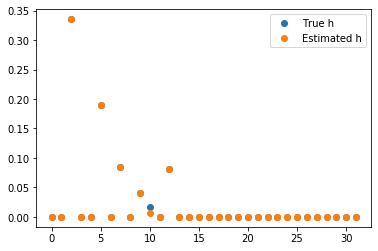

In [228]:
h_act, h_est = q5(N,L, zero_ind,trials)
plot_h(h_act,h_est)